In [1]:
from scipy import signal
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from copy import deepcopy

In [2]:
def load(file_path):
    dataframe = pd.read_pickle(file_path)
    values_to_remove = [5, 6, 7]
    mask = np.isin(dataframe['label'], values_to_remove, invert=True)
    dataframe['label'] = dataframe['label'][mask]
    return dataframe

def plot_with_labels(data, labels, title):
    # Définir les couleurs pour chaque label
    label_colors = {0: 'grey', 1: 'blue', 2: 'red', 3: 'green', 4: 'orange'}

    # Définir les légendes personnalisées
    custom_labels = {
        0: 'not defined / transient',
        1: 'baseline',
        2: 'stress',
        3: 'amusement',
        4: 'meditation'
    }

    # Déterminer le nombre de sous-graphiques nécessaires (ajouter 2 si 'ACC' a 3 dimensions)
    num_subplots = len(
        data) + 2 if 'ACC' in data and data['ACC'].shape[1] == 3 else len(data)

    # Ajuster la taille de la figure en fonction du nombre de sous-graphiques
    plt.figure(figsize=(12, num_subplots * 2))

    subplot_idx = 1  # Commencer l'index du sous-graphique

    # Tracer chaque signal sauf 'ACC'
    for key in data:
        if key != 'ACC':  # Ignorer 'ACC' pour le moment
            plt.subplot(num_subplots, 1, subplot_idx)
            signal = data[key]

            for label in np.unique(labels):
                mask = labels == label
                indices = np.where(mask)[0]
                plt.scatter(indices, signal[indices], c=label_colors[label],
                            s=1, label=custom_labels[label] if subplot_idx == 1 else "")

            plt.title(f'{title} - {key}')
            plt.xlabel('Échantillons')
            plt.ylabel('Amplitude')

            if subplot_idx == 1:  # Ajouter la légende uniquement au premier sous-graphique
                plt.legend(markerscale=3, bbox_to_anchor=(
                    1.05, 1), loc='upper left')
            subplot_idx += 1

    # Tracer chaque dimension 'ACC' séparément maintenant
    if 'ACC' in data:
        acc_signals = ['ACC_X', 'ACC_Y', 'ACC_Z']
        for i, axis in enumerate(acc_signals):
            plt.subplot(num_subplots, 1, subplot_idx)
            # Sélectionner la colonne pour l'axe actuel
            signal = data['ACC'][:, i]

            for label in np.unique(labels):
                mask = labels == label
                indices = np.where(mask)[0]
                plt.scatter(indices, signal[indices], c=label_colors[label],
                            s=1, label=custom_labels[label] if subplot_idx == 1 else "")

            plt.title(f'{title} - {axis}')
            plt.xlabel('Échantillons')
            plt.ylabel('Amplitude')

            subplot_idx += 1

    plt.tight_layout()
    plt.show()

# Define the target sampling rates
sampling_rates = {
    'Label': 700,  # Hz
    'ACC': 32,  # Hz
    'BVP': 64,  # Hz
    'EDA': 4,   # Hz
    'TEMP': 4   # Hz
}

# Function to sample the data


def sample_data(data, sensor_rate, target_rate):
    data_length = len(data)
    sampled_data = [data[int(i * sensor_rate / target_rate)]
                    for i in range(int(data_length * target_rate / sensor_rate))]
    return np.array(sampled_data)

np.interp(np.arange(0, len(wrist_data['Label']), len(wrist_data['Label'])/len(wrist_data['EDA'])), np.arange(0, len(wrist_data['Label'])), wrist_data['Label']).astype(int)

In [3]:
def CorrelationChest(df_chest):
    # Calculez les matrices de corrélation
    correlation_matrix_chest = df_chest.corr()

    # Configurez la taille de la figure
    plt.figure(figsize=(12, 8))

    # Plottez la heatmap pour la matrice de corrélation de la poitrine
    plt.subplot(1, 2, 1)
    sns.heatmap(correlation_matrix_chest, cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5)
    plt.title("Matrice de corrélation - Poitrine")

    # Affichez la figure
    plt.show()


In [ ]:
# A faire :
# Regréssion logistique

# Random Forest à faire sur plusieurs patients
# Changer train test : Entrainer sur un sujet et tester sur l'autre

# Observer variable en fonction du stress et enlever les moins significatives (penser à regarder le readme du patient)

In [81]:
"""
## Pre-Processing CHEST

# Initialiser le dictionnaire principal pour stocker les dataframes de chaque sujet
DF_Chest = {}

for i in range(2, 18):
    if i != 12:
        # Supposant que la convention de nommage des fichiers est similaire pour tous les sujets
        os.chdir('C:\\Users\\PC\\Documents\\Cours Master 2\\PFE\\WESAD\\S'+str(i)+'\\')
        file_path = 'S'+str(i)+'.pkl'
        
        # Charger les données
        dataframe = load(file_path)

        # Appliquer vos opérations sur chest_data et wrist_data
        chest_data = {key: dataframe['signal']['chest'][key][:len(dataframe['label'])] for key in dataframe['signal']['chest']}
        chest_data['ACC'] = chest_data['ACC'][:, :3]

        acc_x_chest = np.transpose(chest_data['ACC'])[0]
        acc_y_chest = np.transpose(chest_data['ACC'])[1]
        acc_z_chest = np.transpose(chest_data['ACC'])[2]
        temp = chest_data['Temp']

        chest_data['ACCX'] = acc_x_chest
        chest_data['ACCY'] = acc_y_chest
        chest_data['ACCZ'] = acc_z_chest
        chest_data['TEMP'] = temp

        del chest_data['Temp']
        del chest_data['ACC']

        df_chest = pd.DataFrame([chest_data])

        cle_chest = list(df_chest.keys())

        df_chest = df_chest.explode(cle_chest)

        df_chest['Label'] = dataframe['label']

        cle_chest1 = list(df_chest.keys())

        # Supprimer les crochets autour des valeurs dans les colonnes contenant des listes
        for cle in cle_chest1:
            df_chest[cle] = df_chest[cle].apply(lambda x: x[0] if isinstance(x, np.ndarray) and len(x) == 1 else x)
            
        # Stocker le dataframe résultant dans le dictionnaire principal
        DF_Chest[i] = df_chest

        # Indiçage des données
        DF_Chest[i].reset_index(drop=True, inplace=True)
        DF_Chest[i].index = DF_Chest[i].index + 1

        # Binarisation (Label 1, 3, 4 deviennent 0)
        
        for j in [1,3,4]:
            DF_Chest[i]['Label'][DF_Chest[i]['Label']==j] = np.zeros(len(DF_Chest[i]['Label'][DF_Chest[i]['Label']==j]))

# Sauvegarde du dictionnaire DF_Chest dans un fichier binaire
with open('DF_Chest.pkl', 'wb') as file:
    pickle.dump(DF_Chest, file)
"""
# A exécuter une seule fois car créer une fichier qui sauvegarde le dictionnaire

"\n## Pre-Processing CHEST\n\n# Initialiser le dictionnaire principal pour stocker les dataframes de chaque sujet\nDF_Chest = {}\n\nfor i in range(2, 18):\n    if i != 12:\n        # Supposant que la convention de nommage des fichiers est similaire pour tous les sujets\n        os.chdir('C:\\Users\\PC\\Documents\\Cours Master 2\\PFE\\WESAD\\S'+str(i)+'\\')\n        file_path = 'S'+str(i)+'.pkl'\n        \n        # Charger les données\n        dataframe = load(file_path)\n\n        # Appliquer vos opérations sur chest_data et wrist_data\n        chest_data = {key: dataframe['signal']['chest'][key][:len(dataframe['label'])] for key in dataframe['signal']['chest']}\n        chest_data['ACC'] = chest_data['ACC'][:, :3]\n\n        acc_x_chest = np.transpose(chest_data['ACC'])[0]\n        acc_y_chest = np.transpose(chest_data['ACC'])[1]\n        acc_z_chest = np.transpose(chest_data['ACC'])[2]\n        temp = chest_data['Temp']\n\n        chest_data['ACCX'] = acc_x_chest\n        chest_data

In [ ]:
# fonction qui fait tout ce processus (séparer acc en acc_x, acc_y, acc_z, reshape, normaliser)
def normalize(dict):
    for key in dict.keys():
        dict[key] = (dict[key] - np.mean(dict[key])) / np.std(dict[key])
    return dict


label_rate = 700  # Hz

# Define the target sampling rates
sampling_rates = {
    'Label': 700,  # Hz
    'ACC': 32,  # Hz
    'BVP': 64,  # Hz
    'EDA': 4,   # Hz
    'TEMP': 4   # Hz
}

# Function to sample the data


def sample_data(data, sensor_rate, target_rate):
    data_length = len(data)
    sampled_data = [data[int(i * sensor_rate / target_rate)]
                    for i in range(int(data_length * target_rate / sensor_rate))]
    return np.array(sampled_data)


def preprocess_data(dict):

    chest_data = dict['signal']['chest']
    wrist_data = dict['signal']['wrist']

    labels = dict['label']

    def separate_acc(data):
        acc = data['ACC']
        data['ACC_x'] = acc[:, 0]
        data['ACC_y'] = acc[:, 1]
        data['ACC_z'] = acc[:, 2]
        data.pop('ACC')
        return data

    chest_data = separate_acc(chest_data)
    wrist_data = separate_acc(wrist_data)

    # reshape
    for key in chest_data:
        chest_data[key] = chest_data[key].reshape(-1)
    for key in wrist_data:
        wrist_data[key] = wrist_data[key].reshape(-1)

    # normaliser
    normalize(chest_data)
    normalize(wrist_data)

    return pd.DataFrame(chest_data), wrist_data, labels


def load(file_path):
    dict = pd.read_pickle(file_path)
    df_c, df_w, labels = preprocess_data(dict)

    # sample the data
    sampled_eda = sample_data(
        df_w['EDA'], sampling_rates['EDA'], label_rate)
    sampled_temp = sample_data(
        df_w['TEMP'], sampling_rates['TEMP'], label_rate)
    sampled_bvp = sample_data(
        df_w['BVP'], sampling_rates['BVP'], label_rate)
    sampled_acc_x = sample_data(
        df_w['ACC_x'], sampling_rates['ACC'], label_rate)
    sampled_acc_y = sample_data(
        df_w['ACC_y'], sampling_rates['ACC'], label_rate)
    sampled_acc_z = sample_data(
        df_w['ACC_z'], sampling_rates['ACC'], label_rate)

    # Create a new dataframe with the sampled data
    df_w = pd.DataFrame({
        'ACC_x': sampled_acc_x,
        'ACC_y': sampled_acc_y,
        'ACC_z': sampled_acc_z,
        'BVP': sampled_bvp,
        'EDA': sampled_eda,
        'TEMP': sampled_temp,
        'label': labels
    })

    # add labels to the chest data
    df_c['label'] = labels
    
    # Remove the labels 5, 6, 7
    values_to_remove = [5, 6, 7]
    
    # We need to apply the mask to remove the labels 5, 6, 7 then make all the labels that aren't 2 or 0 to 0
    mask = np.isin(df_w['label'], values_to_remove, invert=True)
    mask = np.isin(df_c['label'], values_to_remove, invert=True)
    df_w = df_w[mask]
    df_c = df_c[mask]

    # change the label to 0 if it's not 2
    df_w['label'] = df_w['label'].apply(lambda x: 0 if x != 2 else x)
    df_c['label'] = df_c['label'].apply(lambda x: 0 if x != 2 else x)

    return df_c, df_w

In [ ]:
wrist_data['EDA'] = sample_data(wrist_data['EDA'], sampling_rates['EDA'], sampling_rates['Label'])
wrist_data['TEMP'] = sample_data(wrist_data['TEMP'], sampling_rates['TEMP'], sampling_rates['Label'])
wrist_data['BVP'] = sample_data(wrist_data['BVP'], sampling_rates['BVP'], sampling_rates['Label'])
wrist_data['ACCX'] = sample_data(wrist_data['ACCX'], sampling_rates['ACCX'], sampling_rates['Label'])
wrist_data['ACCY'] = sample_data(wrist_data['ACCY'], sampling_rates['ACCY'], sampling_rates['Label'])
wrist_data['ACCZ'] = sample_data(wrist_data['ACCZ'], sampling_rates['ACCZ'], sampling_rates['Label'])

In [36]:
## Pre-Processing WRIST
"""
# Initialiser le dictionnaire principal pour stocker les dataframes de chaque sujet
DF_Wrist = {}

for i in range(2, 18):
    if i != 12:
        # Supposant que la convention de nommage des fichiers est similaire pour tous les sujets
        os.chdir('C:\\Users\\PC\\Documents\\Cours Master 2\\PFE\\WESAD\\S'+str(i)+'\\')
        file_path = 'S'+str(i)+'.pkl'
        
        # Charger les données
        dataframe = pd.read_pickle(file_path)

        # Appliquer vos opérations sur wrist_data et wrist_data
        wrist_data = {key: dataframe['signal']['wrist'][key][:len(dataframe['label'])] for key in dataframe['signal']['wrist']}
        wrist_data['ACC'] = wrist_data['ACC'][:, :3]

        acc_x_wrist = np.transpose(wrist_data['ACC'])[0]
        acc_y_wrist = np.transpose(wrist_data['ACC'])[1]
        acc_z_wrist = np.transpose(wrist_data['ACC'])[2]

        wrist_data['ACCX'] = acc_x_wrist
        wrist_data['ACCY'] = acc_y_wrist
        wrist_data['ACCZ'] = acc_z_wrist

        del wrist_data['ACC']

        # Adaptation des fréquences
        wrist_data['EDA'] = sample_data(wrist_data['EDA'], sampling_rates['EDA'], sampling_rates['Label'])
        wrist_data['TEMP'] = sample_data(wrist_data['TEMP'], sampling_rates['TEMP'], sampling_rates['Label'])
        wrist_data['BVP'] = sample_data(wrist_data['BVP'], sampling_rates['BVP'], sampling_rates['Label'])
        wrist_data['ACCX'] = sample_data(wrist_data['ACCX'], sampling_rates['ACC'], sampling_rates['Label'])
        wrist_data['ACCY'] = sample_data(wrist_data['ACCY'], sampling_rates['ACC'], sampling_rates['Label'])
        wrist_data['ACCZ'] = sample_data(wrist_data['ACCZ'], sampling_rates['ACC'], sampling_rates['Label'])
        wrist_data['Label'] = dataframe['label']

        df_wrist = pd.DataFrame([wrist_data])

        cle_wrist = list(df_wrist.keys())

        df_wrist = df_wrist.explode(cle_wrist)

        cle_wrist1 = list(df_wrist.keys())

        # Supprimer les crochets autour des valeurs dans les colonnes contenant des listes
        for cle in cle_wrist1:
            df_wrist[cle] = df_wrist[cle].apply(lambda x: x[0] if isinstance(x, np.ndarray) and len(x) == 1 else x)

        # Stocker le dataframe résultant dans le dictionnaire principal
        DF_Wrist[i] = df_wrist

        # Supprimer les lignes où label est égal à 5, 6 ou 7
        DF_Wrist[i] = DF_Wrist[i][~DF_Wrist[i]['Label'].isin([5, 6, 7])]

        # Indiçage des données
        DF_Wrist[i].reset_index(drop=True, inplace=True)
        DF_Wrist[i].index = DF_Wrist[i].index + 1

        # Binarisation (Label 1, 3, 4 deviennent 0)
        
        for j in [1,3,4]:
            DF_Wrist[i]['Label'][DF_Wrist[i]['Label']==j] = np.zeros(len(DF_Wrist[i]['Label'][DF_Wrist[i]['Label']==j]))
"""
# Sauvegarde du dictionnaire DF_Wrist dans un fichier binaire
with open('DF_Wrist.pkl', 'wb') as file:
    pickle.dump(DF_Wrist, file)

# A exécuter une seule fois car créer une fichier qui sauvegarde le dictionnaire

In [39]:
np.shape(DF_Wrist[2])

(4165000, 7)

In [4]:
# Chargement du dictionnaire DF_Chest depuis un fichier
with open('C:\\Users\\PC\\Documents\\Cours Master 2\\PFE\\WESAD\\DF_Chest.pkl', 'rb') as file:
    DF_Chest = pickle.load(file)

In [6]:
plus_petit = None
plus_grand = None

for i in range(2, 18):
    if i != 12 and i in DF_Chest:  # Vérifie si i est une clé dans le dictionnaire DF_Chest
        df_actuel = DF_Chest[i]
        if plus_petit is None or len(df_actuel) < len(DF_Chest[plus_petit]):
            plus_petit = i
        if plus_grand is None or len(df_actuel) > len(DF_Chest[plus_grand]):
            plus_grand = i

print("Le DataFrame avec le moins de lignes est:", plus_petit)
print("Le DataFrame avec le plus de lignes est:", plus_grand)

Le DataFrame avec le moins de lignes est: 9
Le DataFrame avec le plus de lignes est: 6


In [8]:
len(DF_Chest[6])

4825799

In [5]:
# Chargement du dictionnaire DF_Wrist depuis un fichier
with open('C:\\Users\\PC\\Documents\\Cours Master 2\\PFE\\WESAD\\DF_Wrist.pkl', 'rb') as file:
    DF_Wrist = pickle.load(file)

In [ ]:
N = np.arange(0,len(DF_Chest[2]))

plt.figure(figsize=(14, 6))
plt.plot(N, DF_Chest[2]['EDA'].iloc[N])

Y1_indices = DF_Chest[2]['Label'][DF_Chest[2]['Label']==2].index
plt.scatter(Y1_indices, DF_Chest[2]['EDA'].iloc[Y1_indices], color='red', marker='o', label='Vrai stress')

plt.figure(figsize=(14, 6))
plt.plot(N, DF_Chest[2]['EDA'].iloc[N])

Y1_indices = DF_Chest[2]['Label'][DF_Chest[2]['Label']==2].index
plt.scatter(Y1_indices, DF_Chest[2]['EDA'].iloc[Y1_indices], color='red', marker='o', label='Vrai stress')

plt.show()

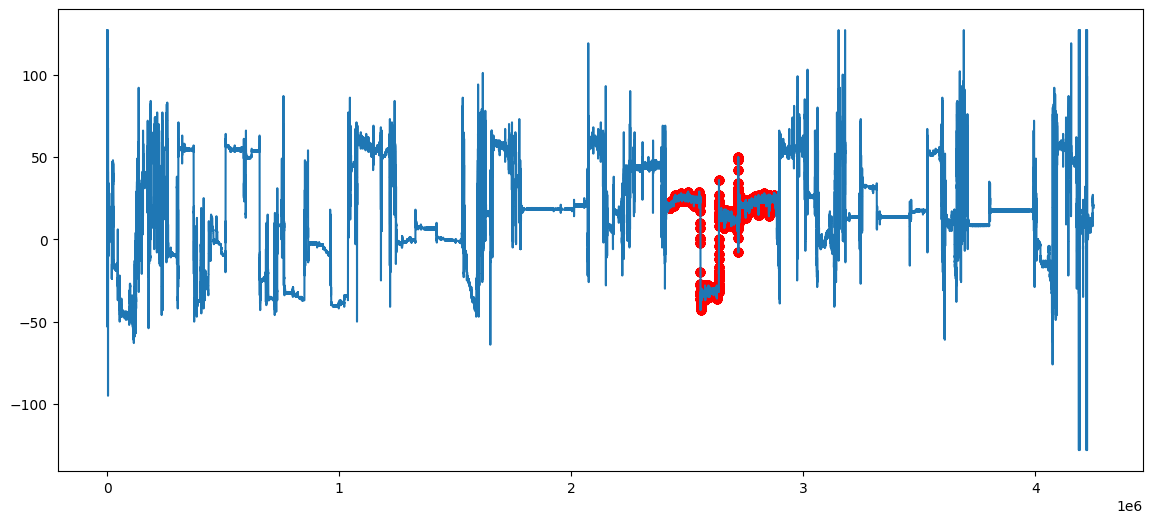

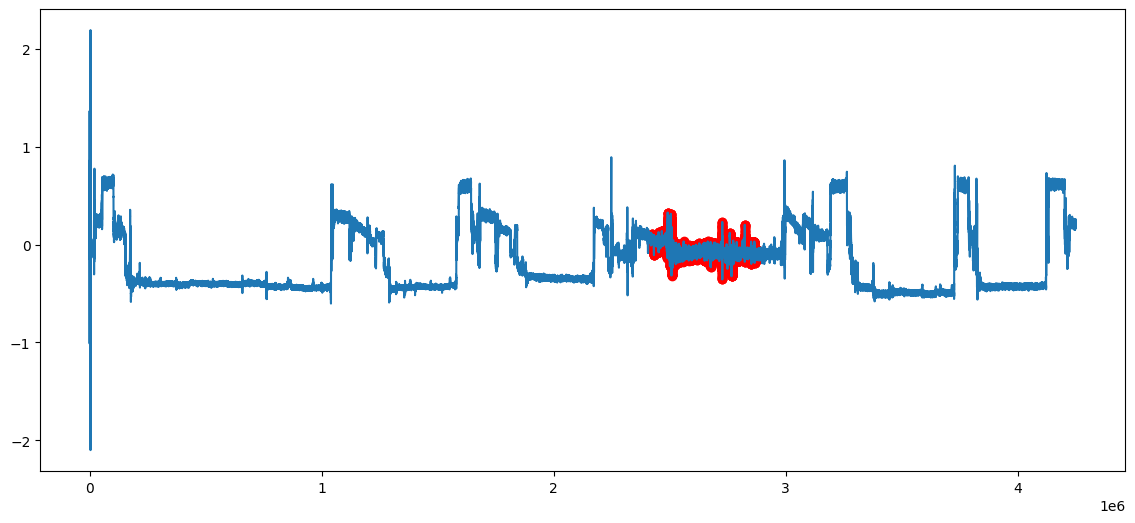

In [49]:
Y_TEST, Y_PRED, SujetTest1, SujetTest2, SujetTest3 = RandomForest(DF_Chest, 70, 4, 13, 9)

Y_PRED1 = Y_PRED[: len(DF_Chest[SujetTest1])]
Y_PRED2 = Y_PRED[len(DF_Chest[SujetTest1]) : len(DF_Chest[SujetTest1]) + len(DF_Chest[SujetTest2])]
Y_PRED3 = Y_PRED[len(DF_Chest[SujetTest1]) + len(DF_Chest[SujetTest2]) :]

Y_TEST1 = Y_TEST[: len(DF_Chest[SujetTest1])]
Y_TEST2 = Y_TEST[len(DF_Chest[SujetTest1]) : len(DF_Chest[SujetTest1]) + len(DF_Chest[SujetTest2])]
Y_TEST3 = Y_TEST[len(DF_Chest[SujetTest1]) + len(DF_Chest[SujetTest2]) :]

pred = [Y_PRED1, Y_PRED2, Y_PRED3]
test = [Y_TEST1, Y_TEST2, Y_TEST3]
sujettest = [SujetTest1, SujetTest2, SujetTest3]

for i in [0,1,2]:
    N = np.arange(0, len(DF_Chest[sujettest[i]]), 10)

    plt.figure(figsize=(12, 5))

    plt.plot(N, DF_Chest[sujettest[i]]['TEMP'].iloc[N], label=f'TEMP du Sujet {sujettest[i]}')


    Y1_indices = test[i][test[i]==2].index
    plt.scatter(Y1_indices, DF_Chest[sujettest[i]]['TEMP'].iloc[Y1_indices], color='red', marker='o', label='Vrai stress')


    Y2_indices = np.where(pred[i] == 2)[0]
    plt.scatter(Y2_indices, DF_Chest[sujettest[i]]['TEMP'].iloc[Y2_indices], color='blue', marker='.', label='Stress prédit')

    plt.legend()
    plt.show()

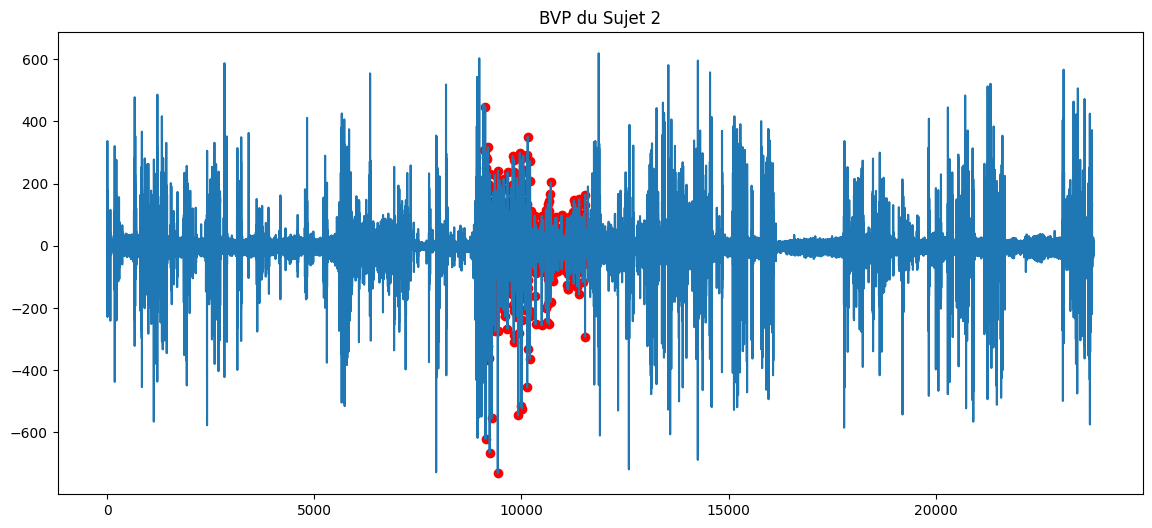

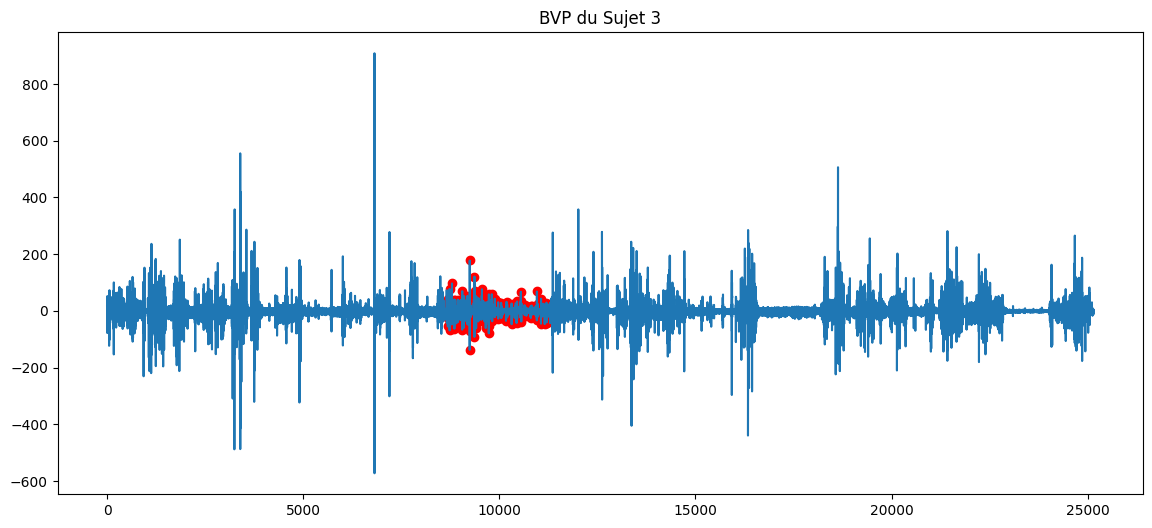

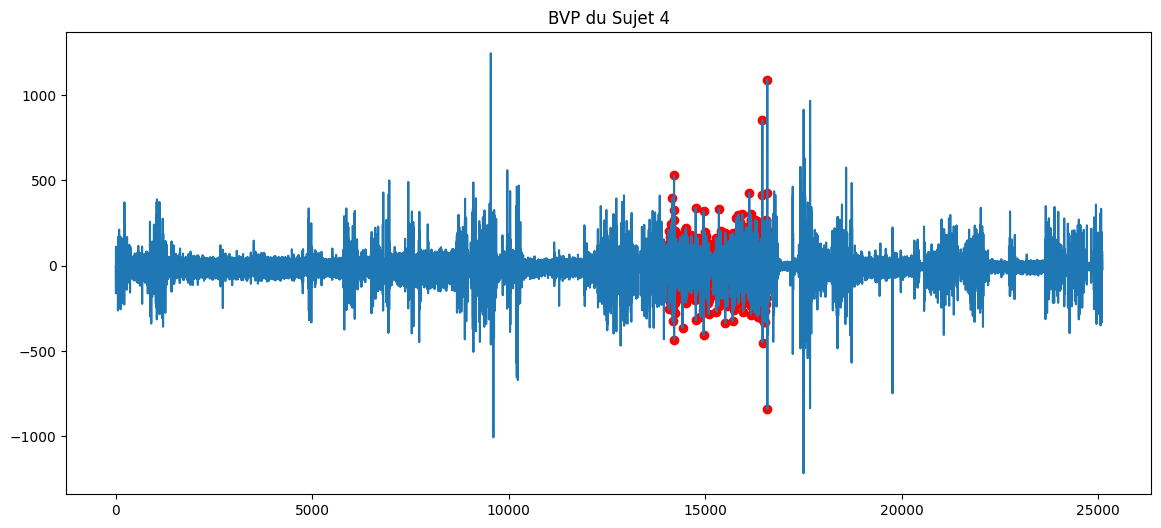

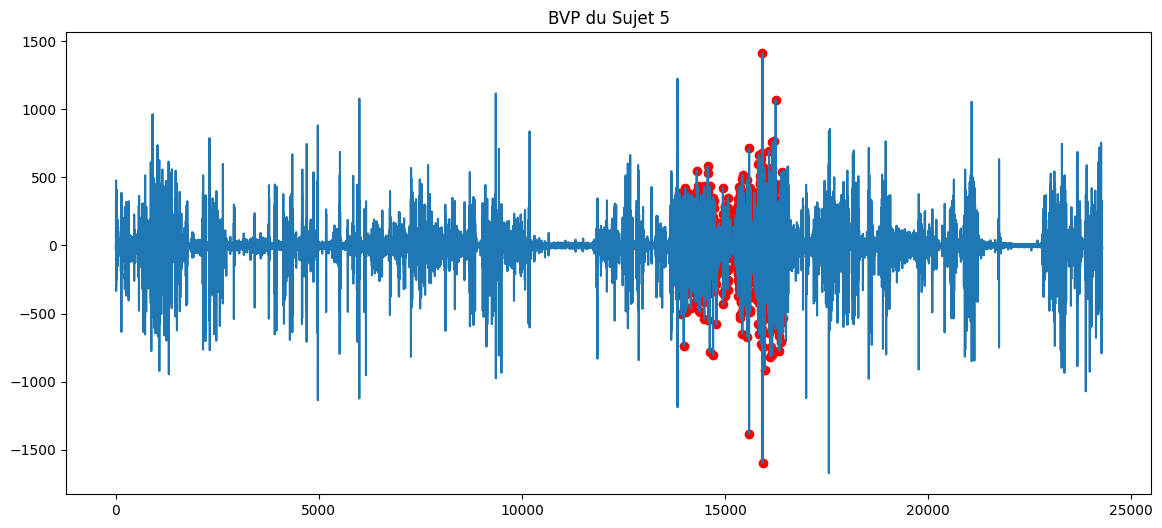

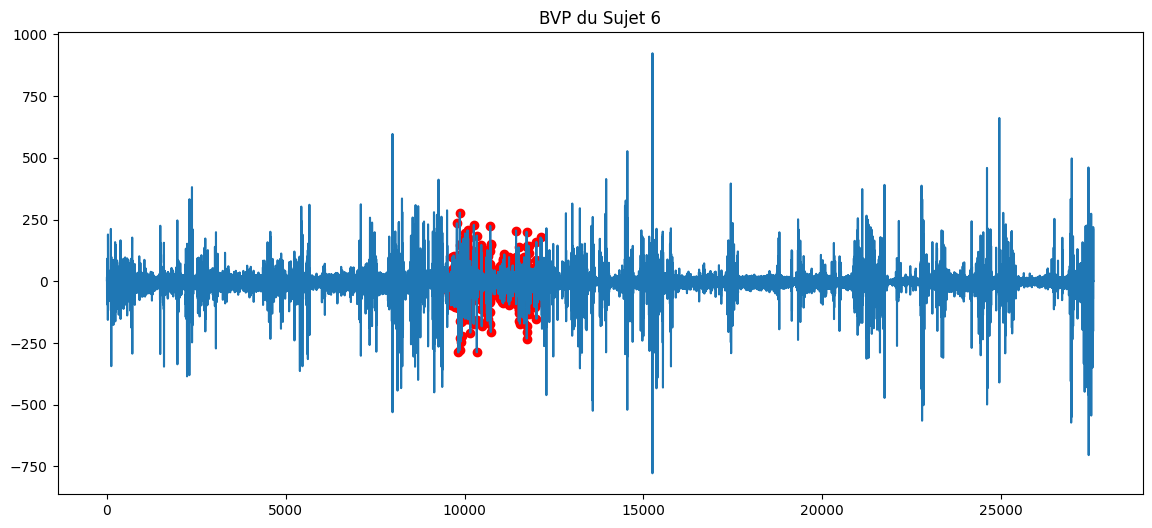

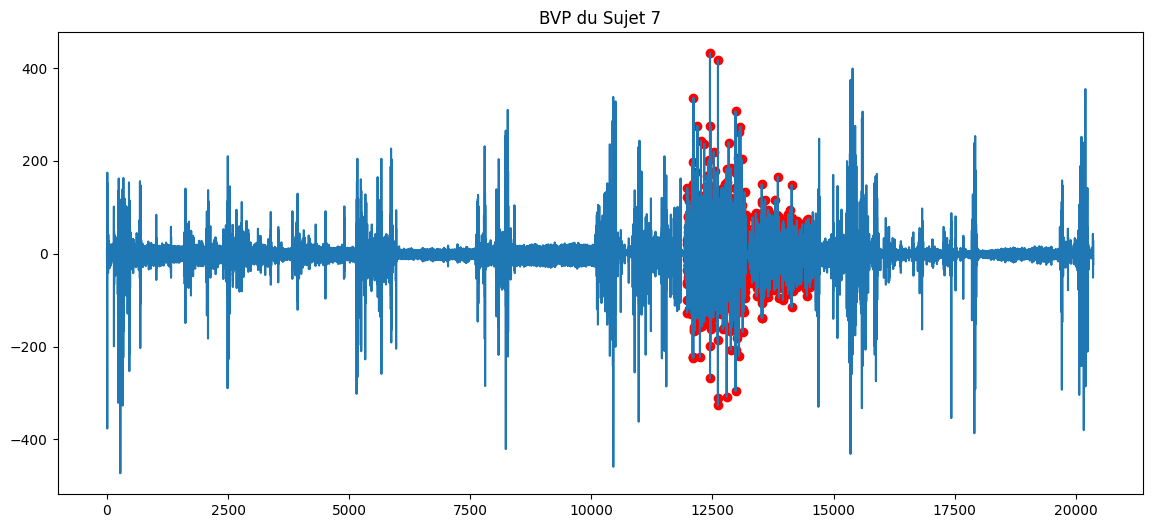

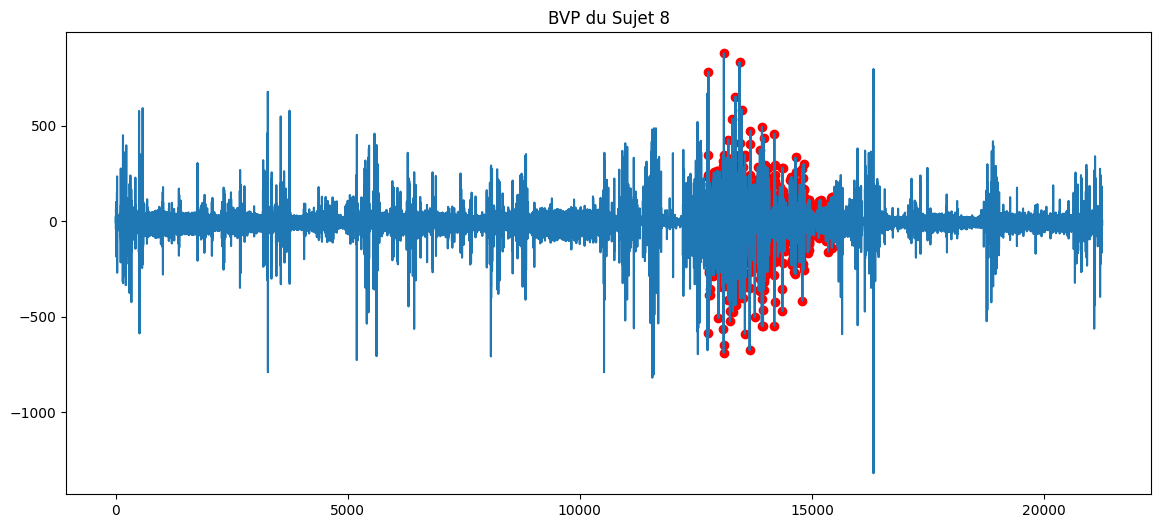

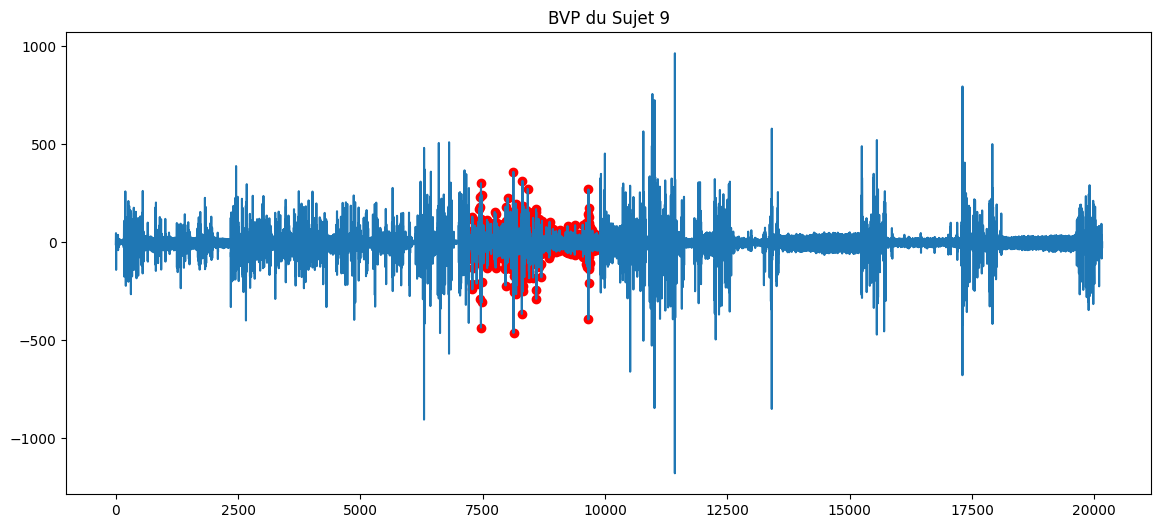

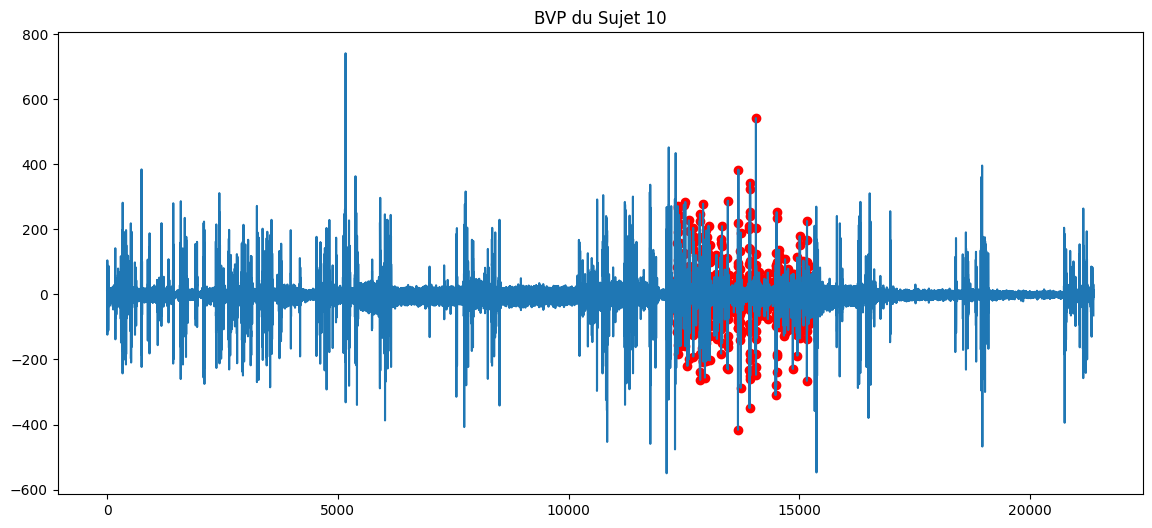

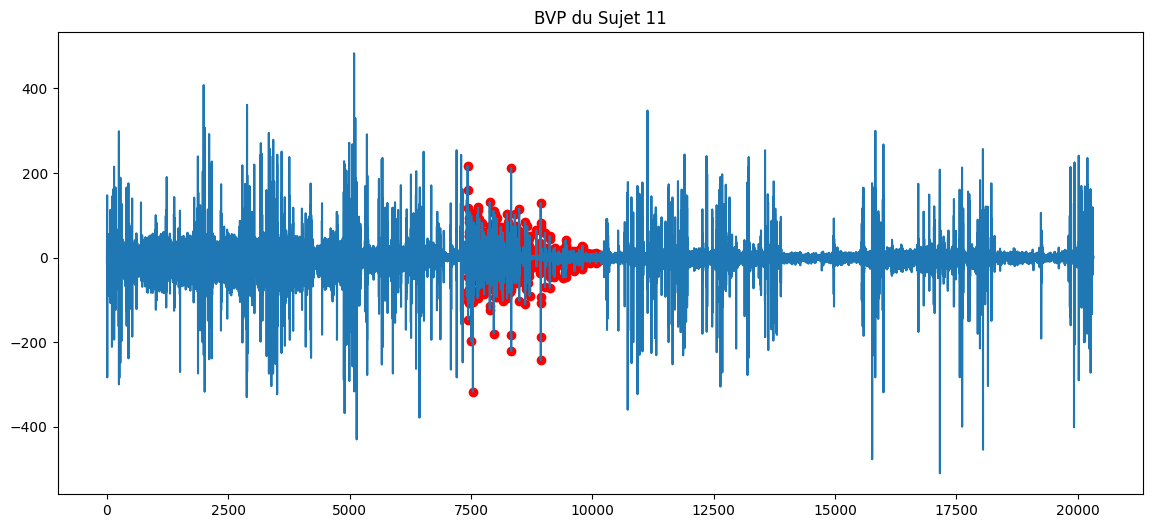

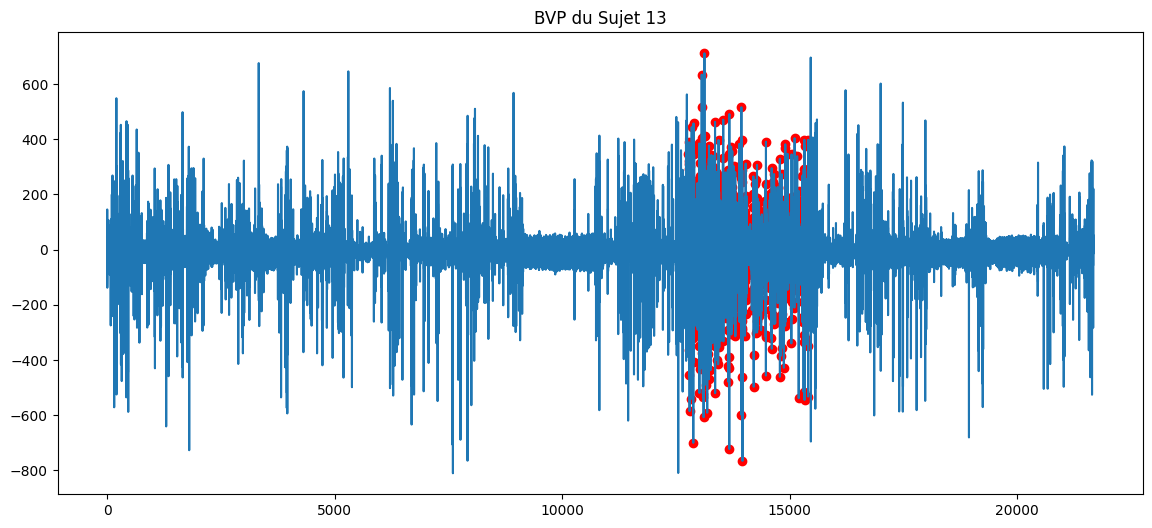

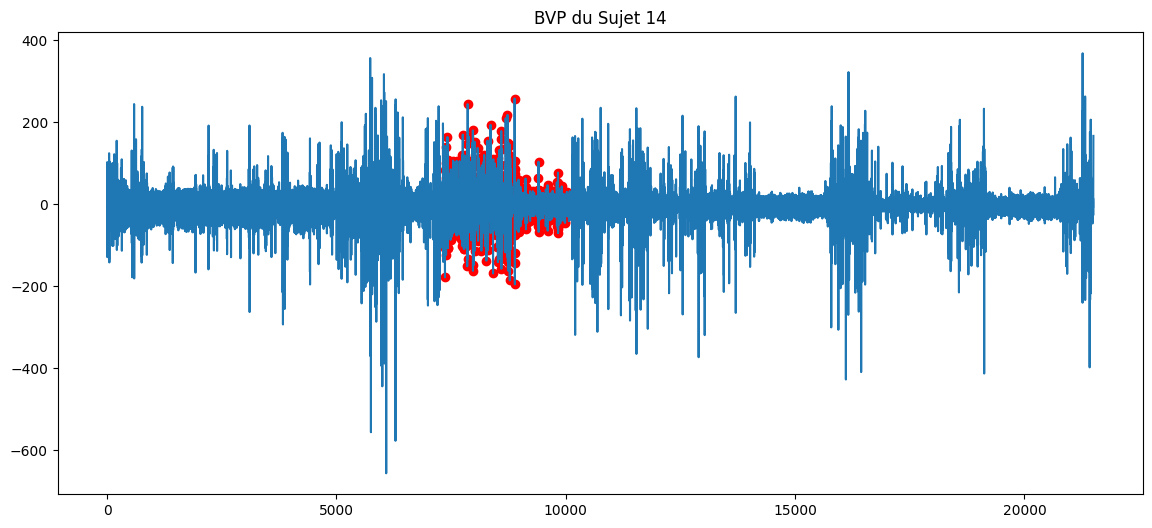

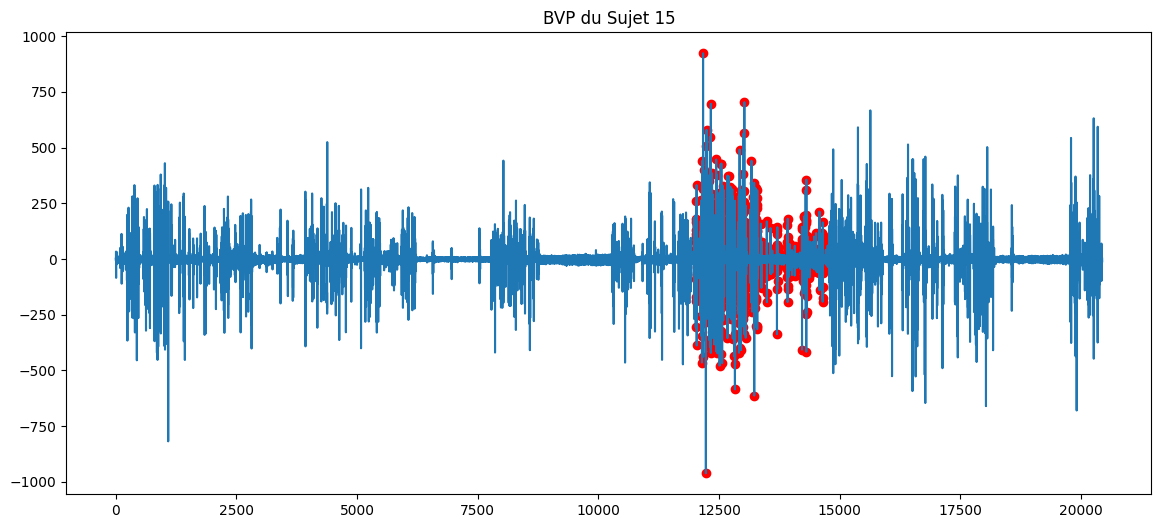

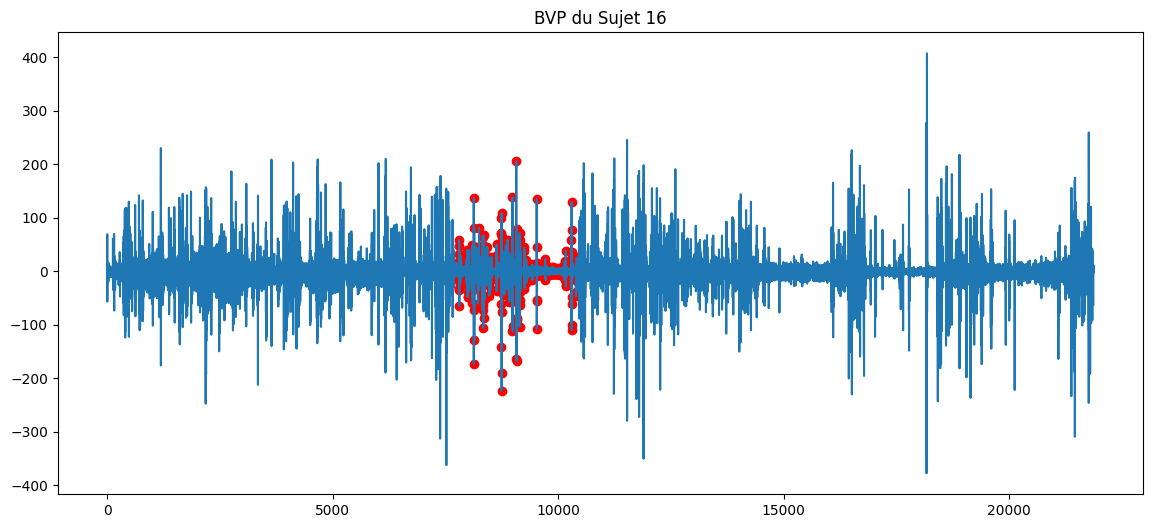

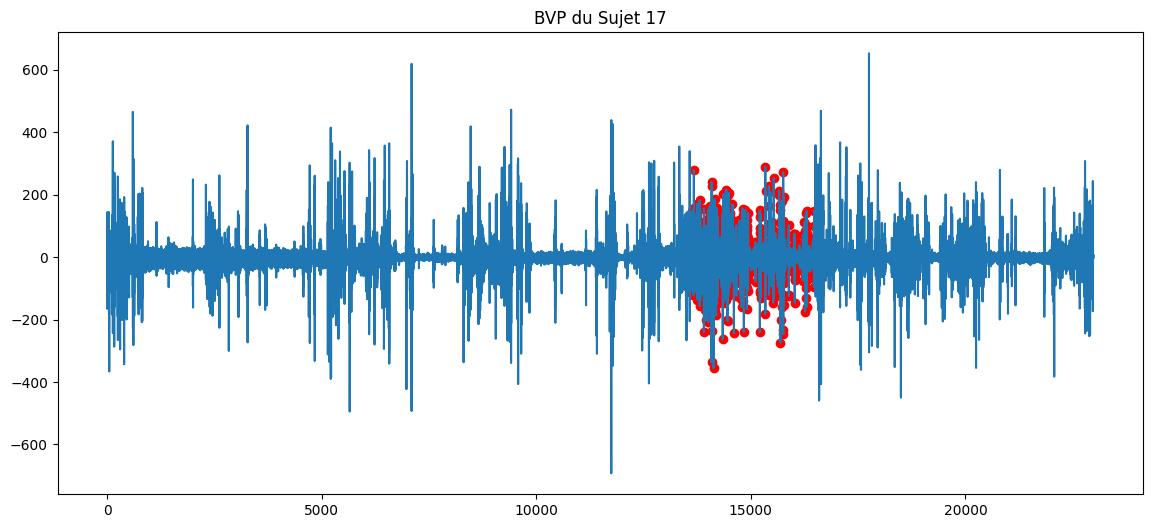

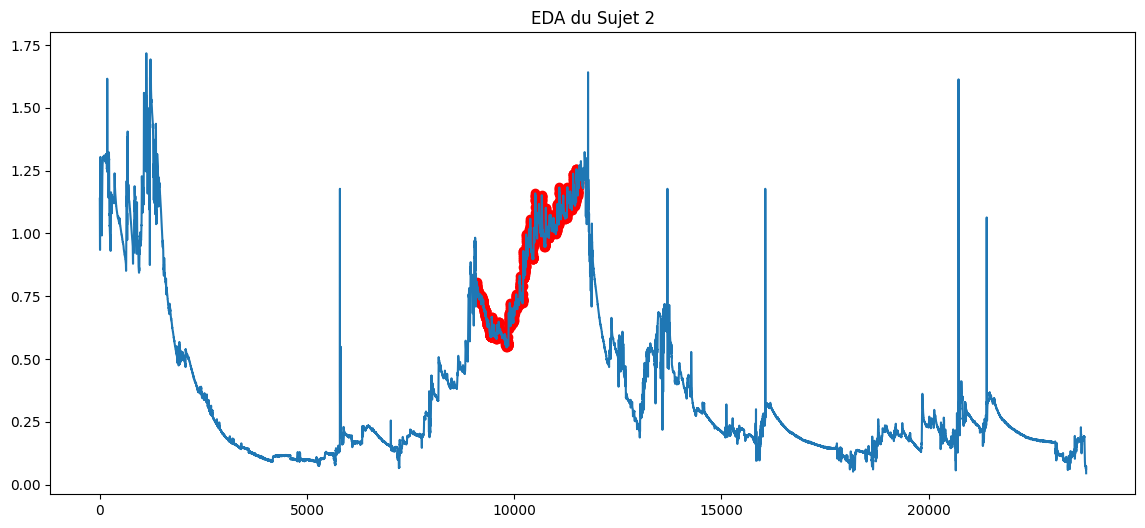

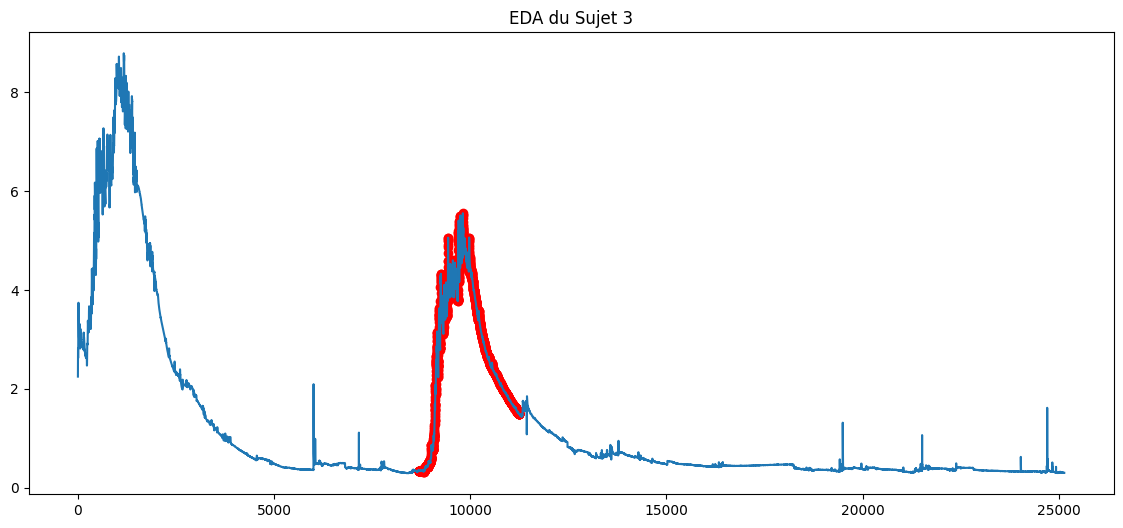

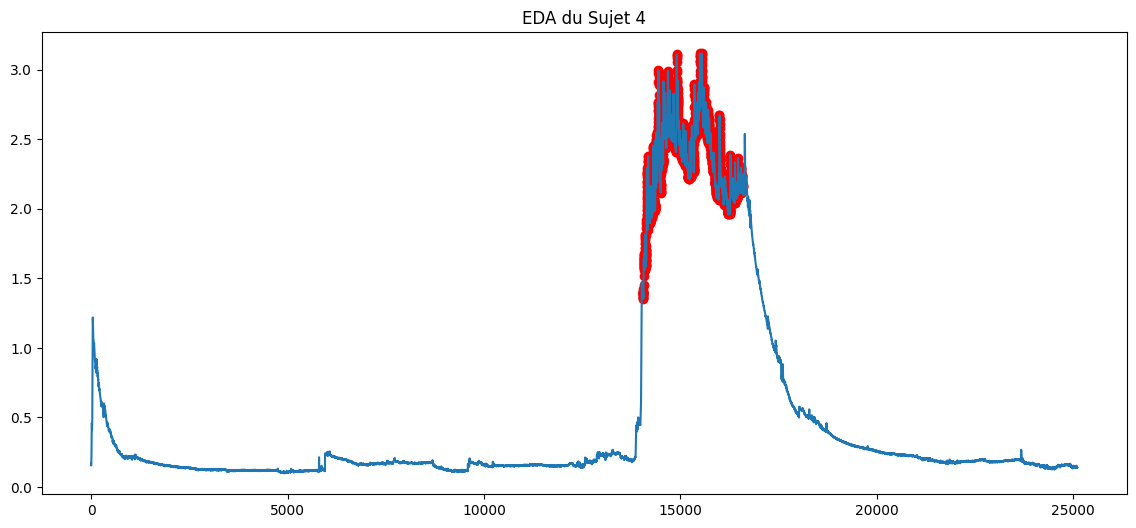

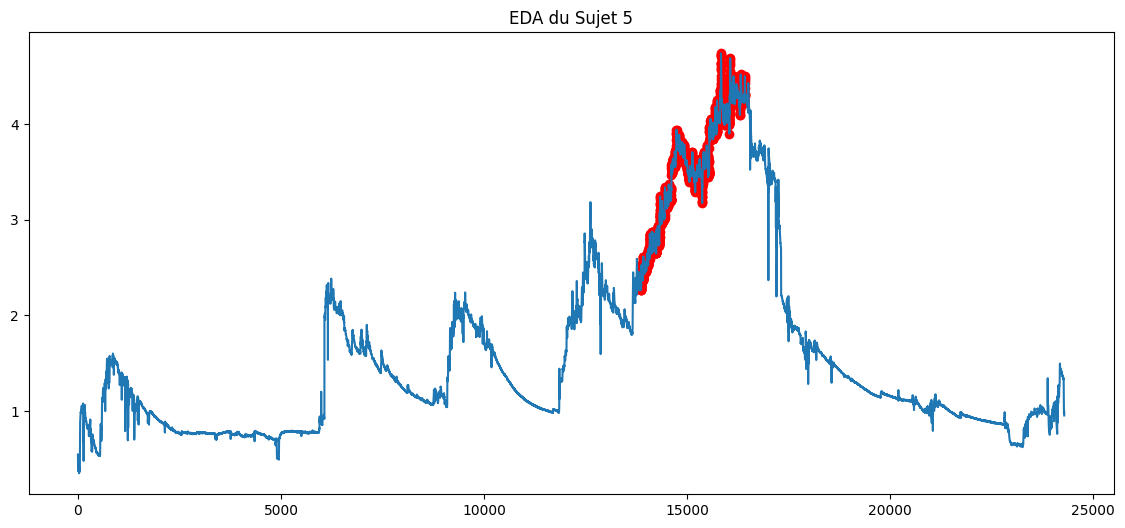

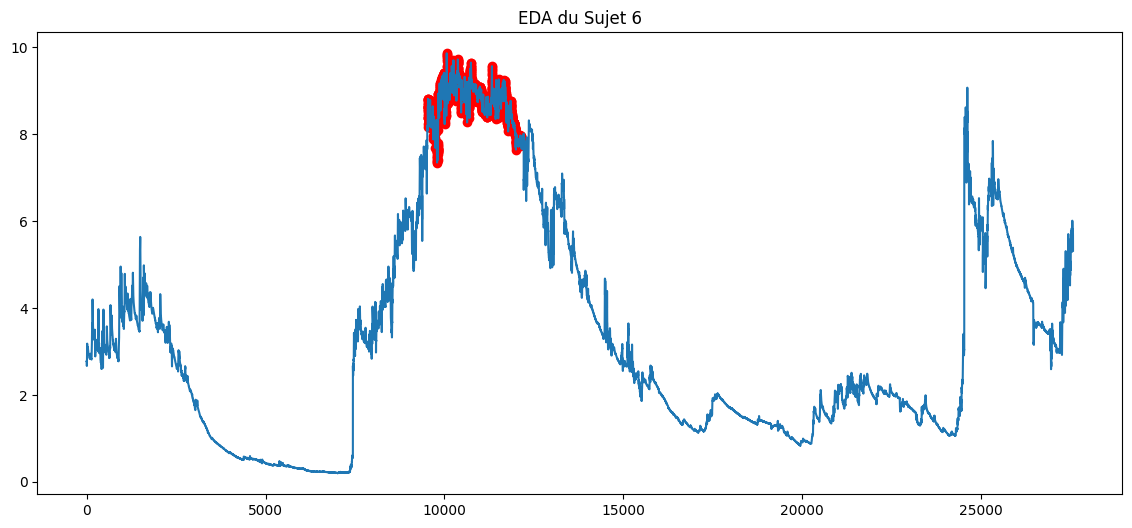

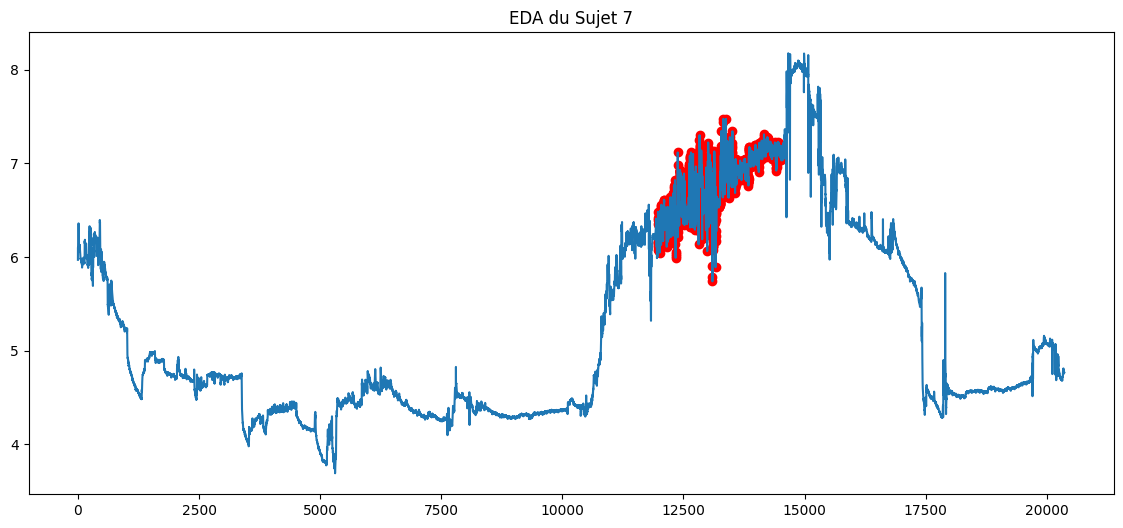

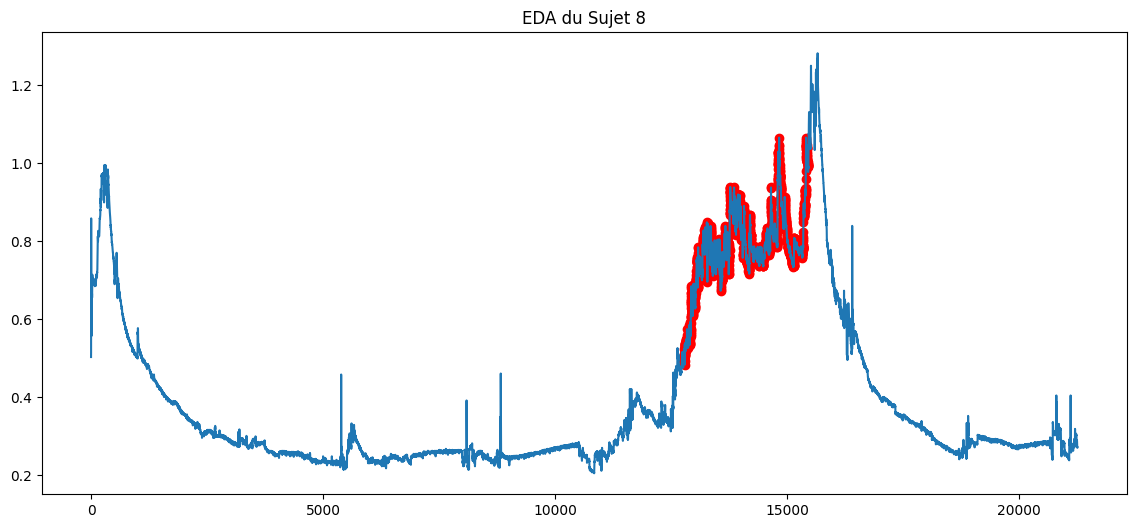

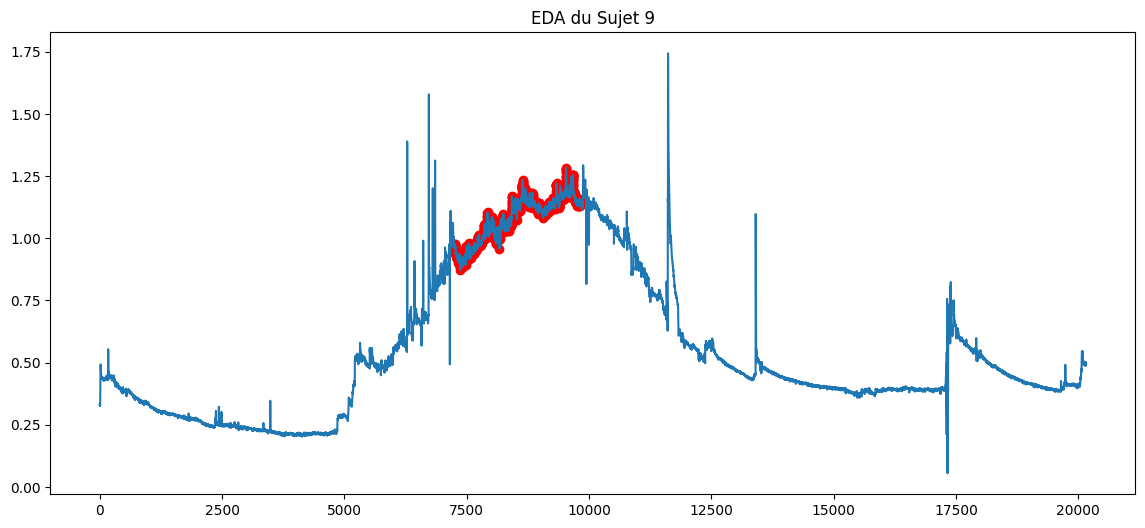

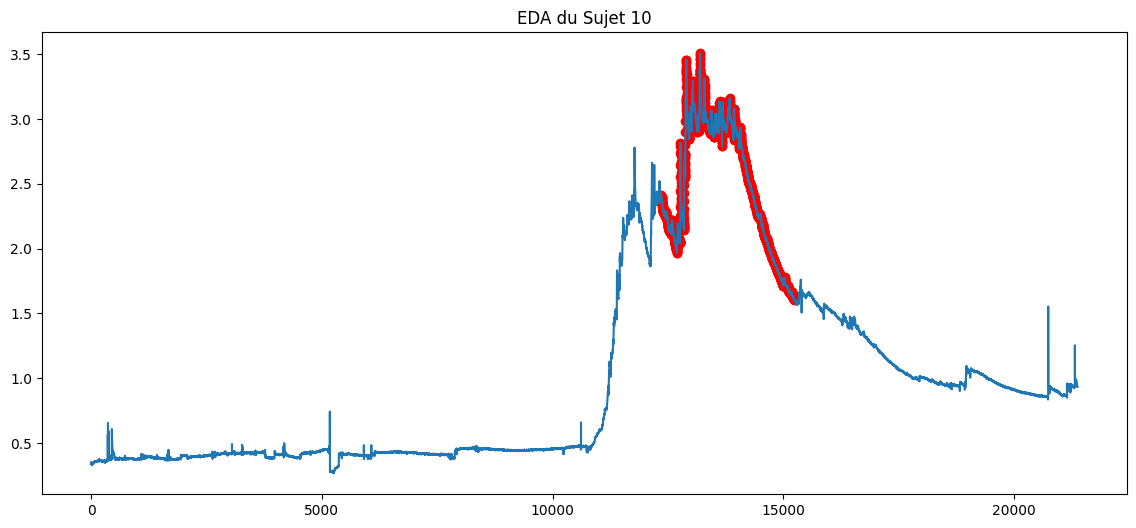

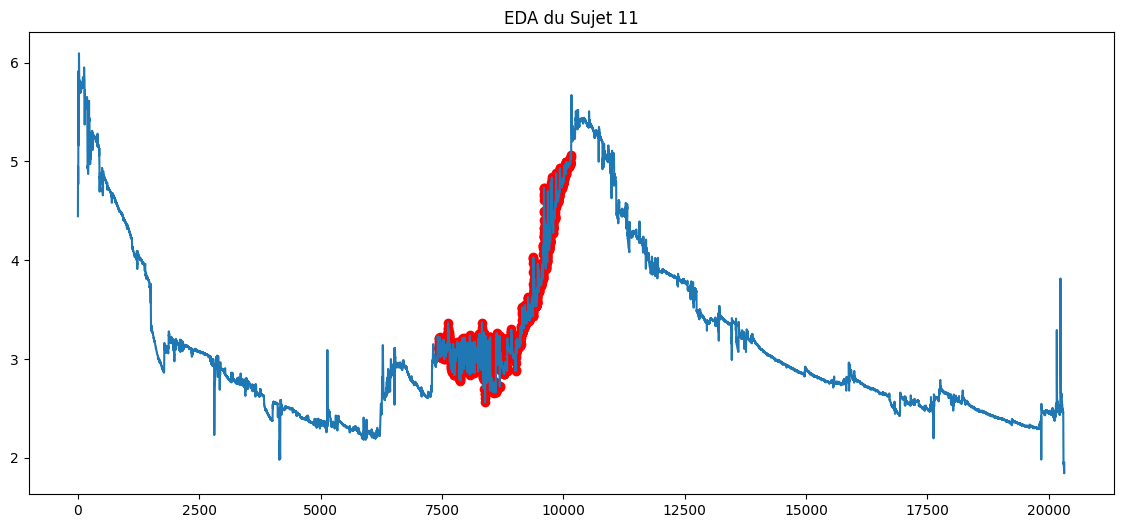

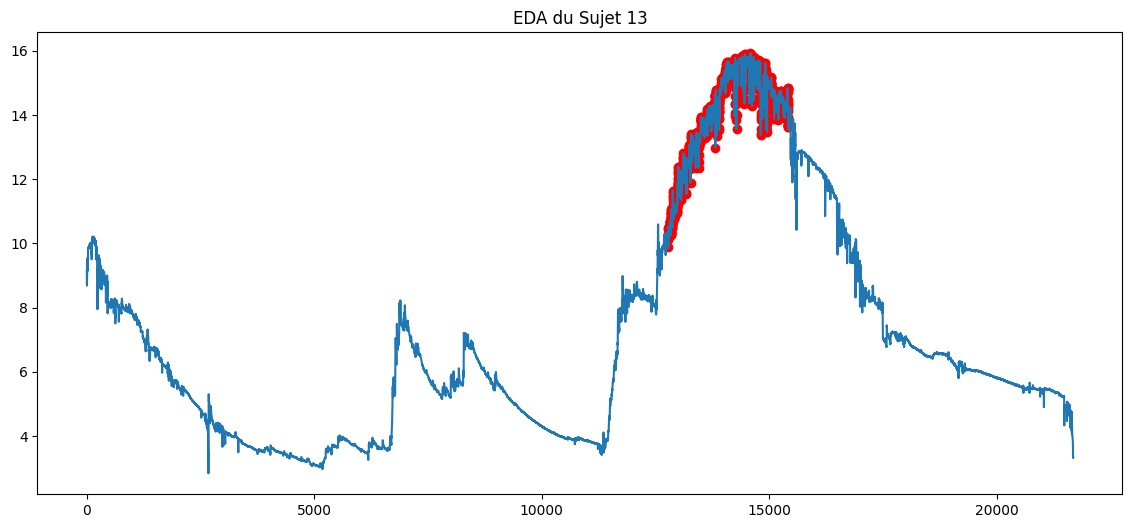

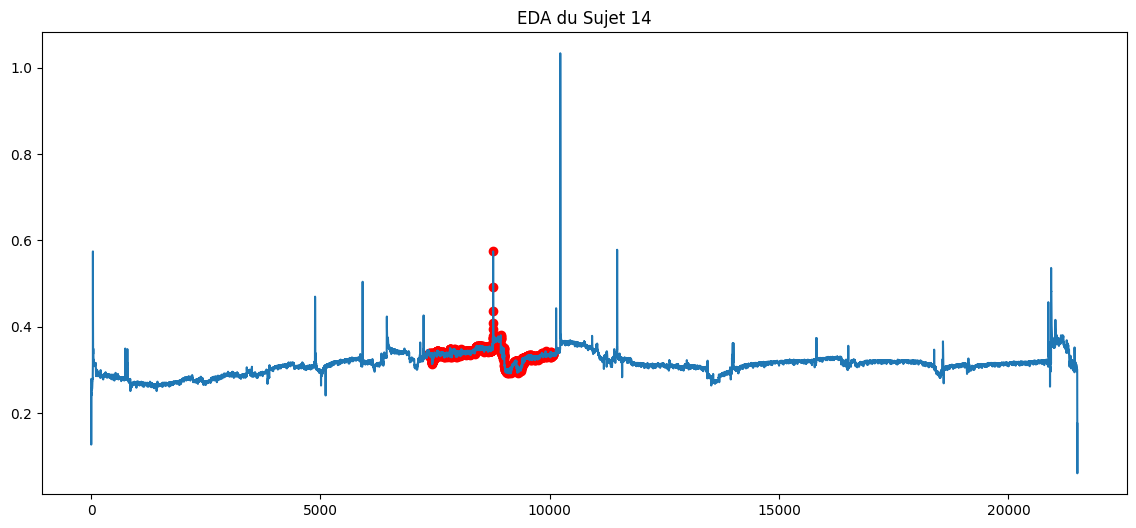

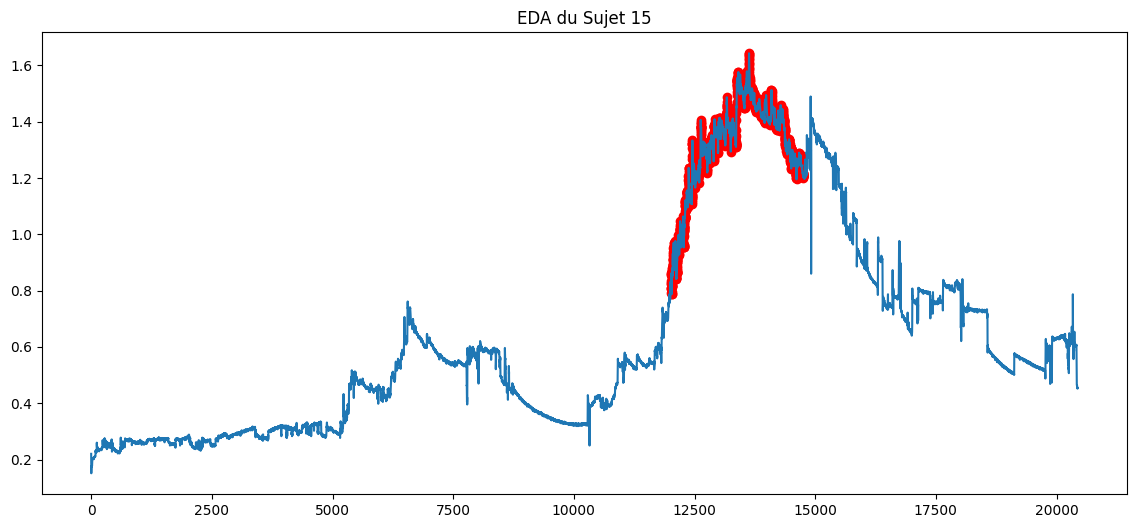

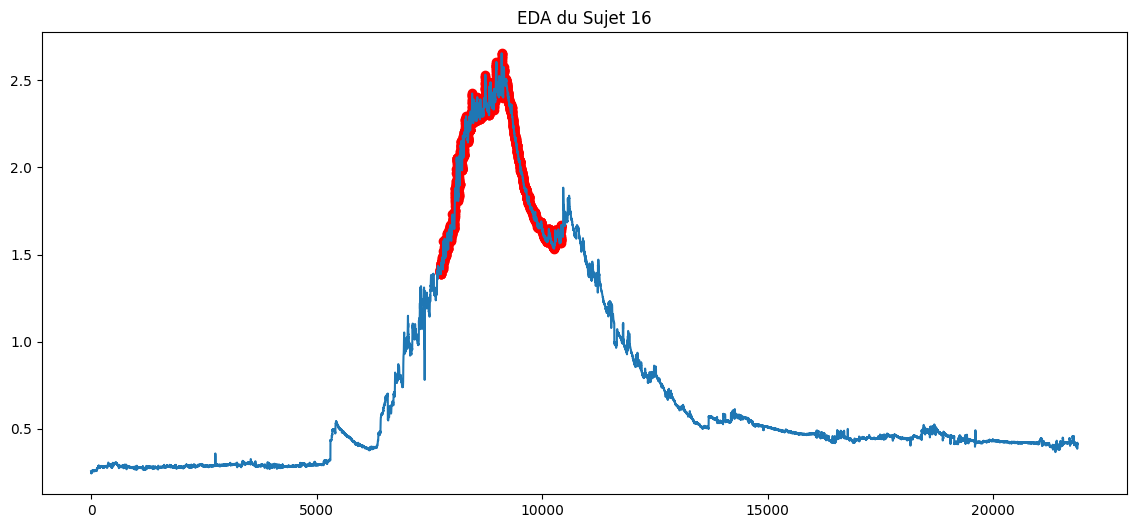

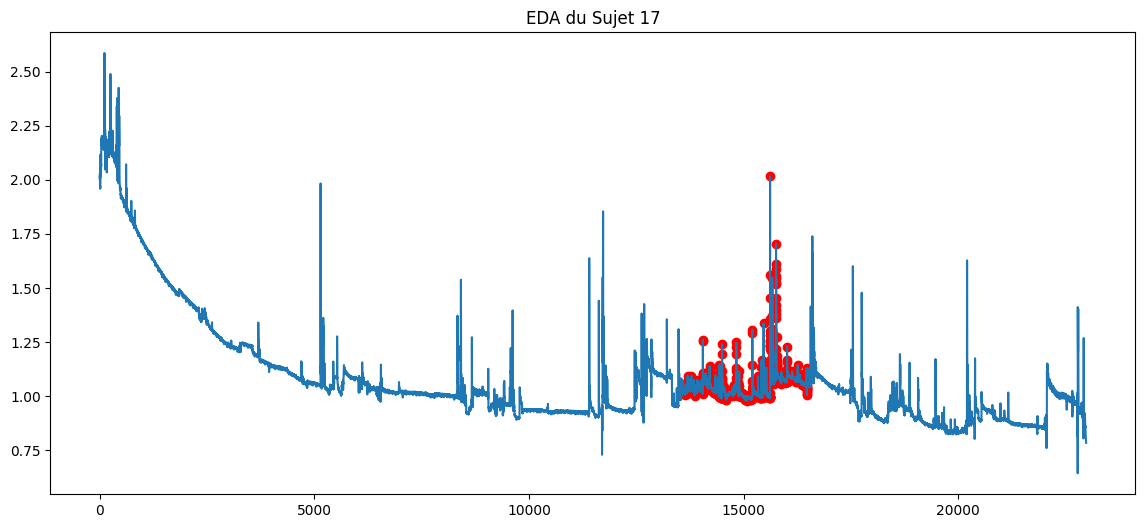

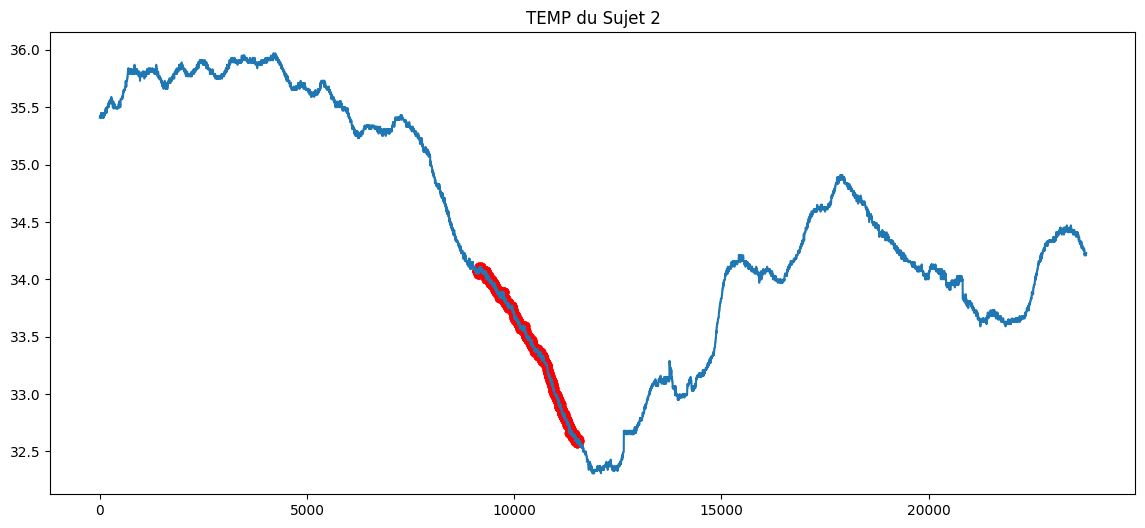

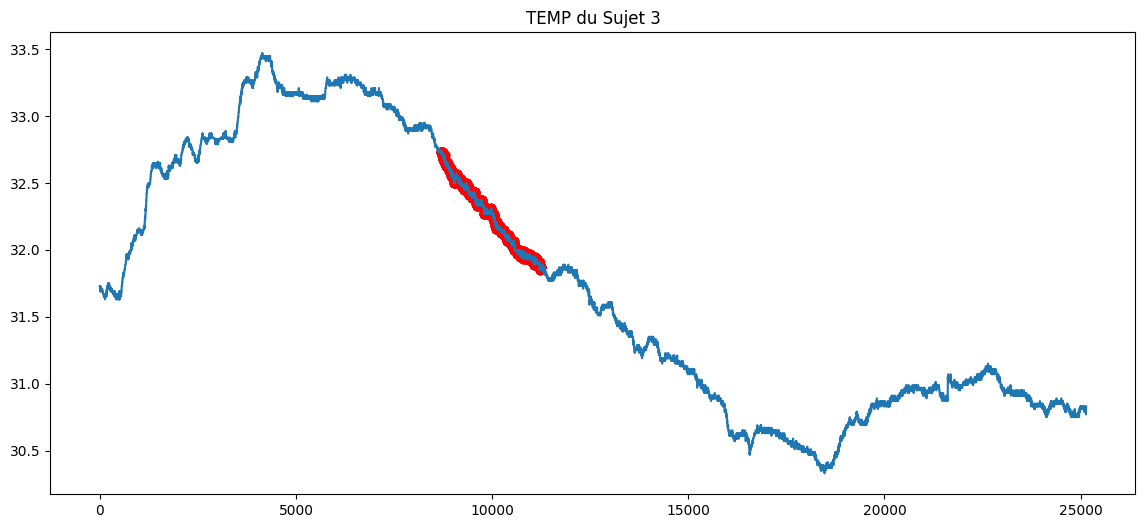

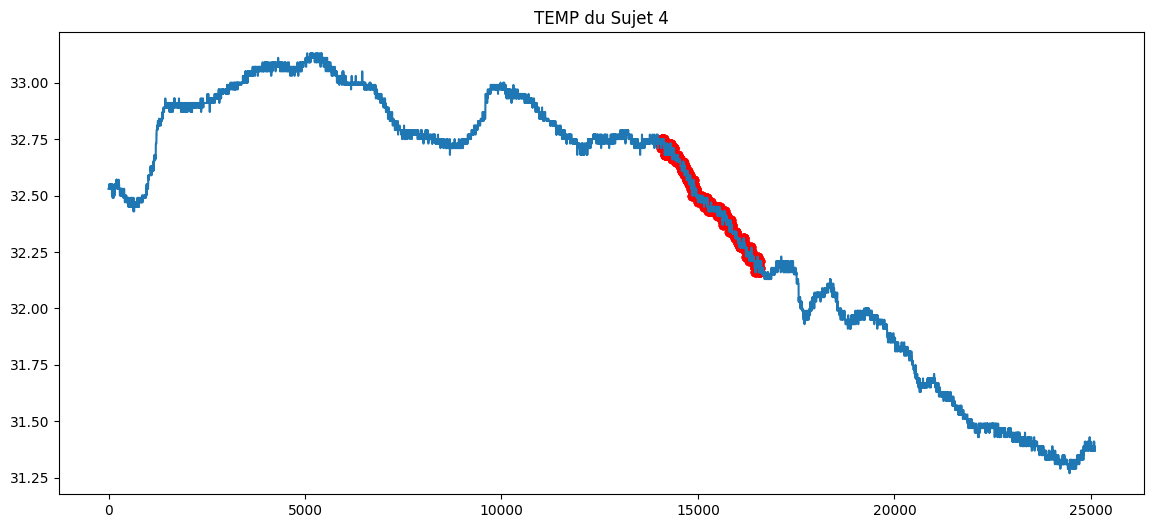

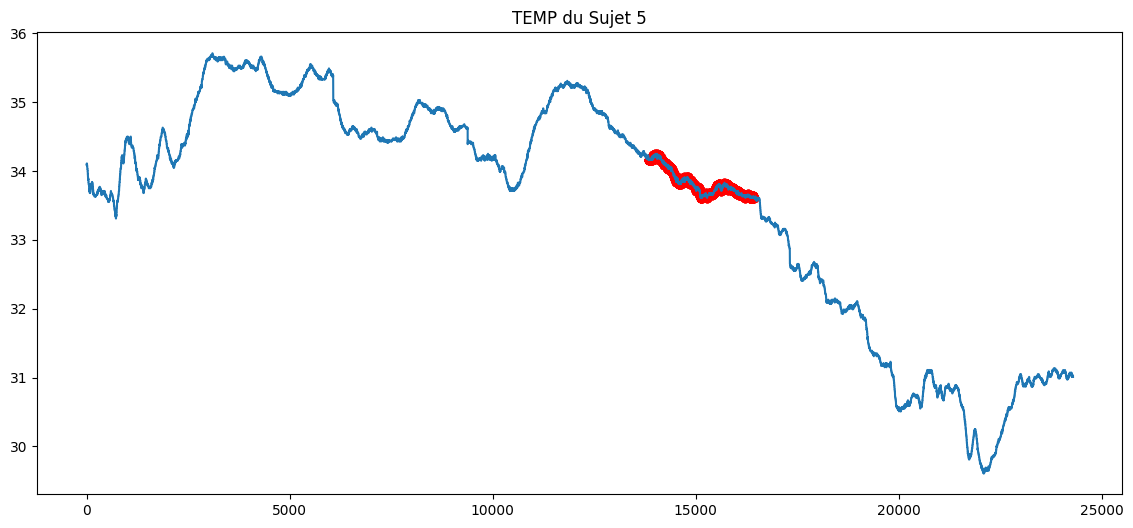

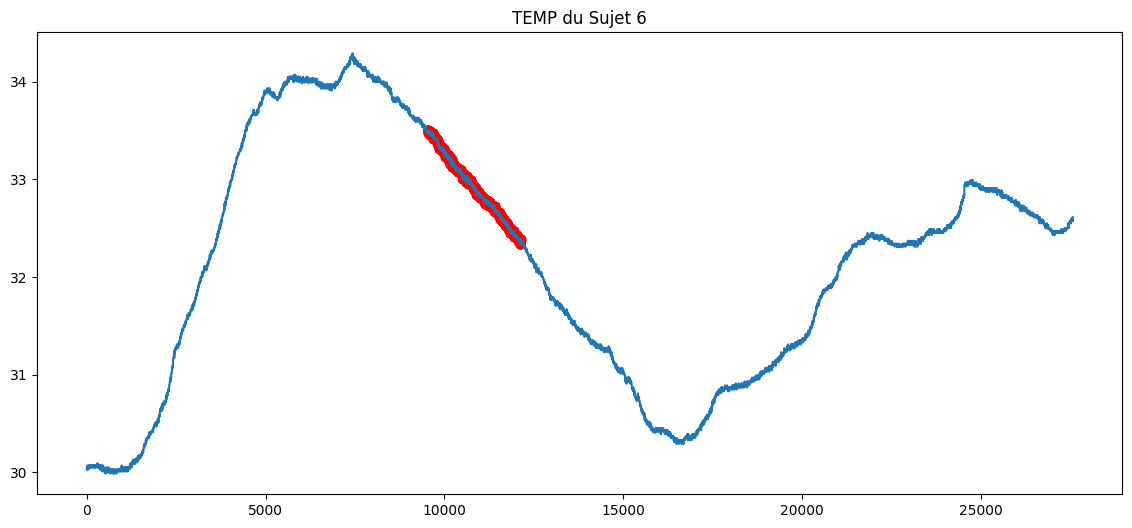

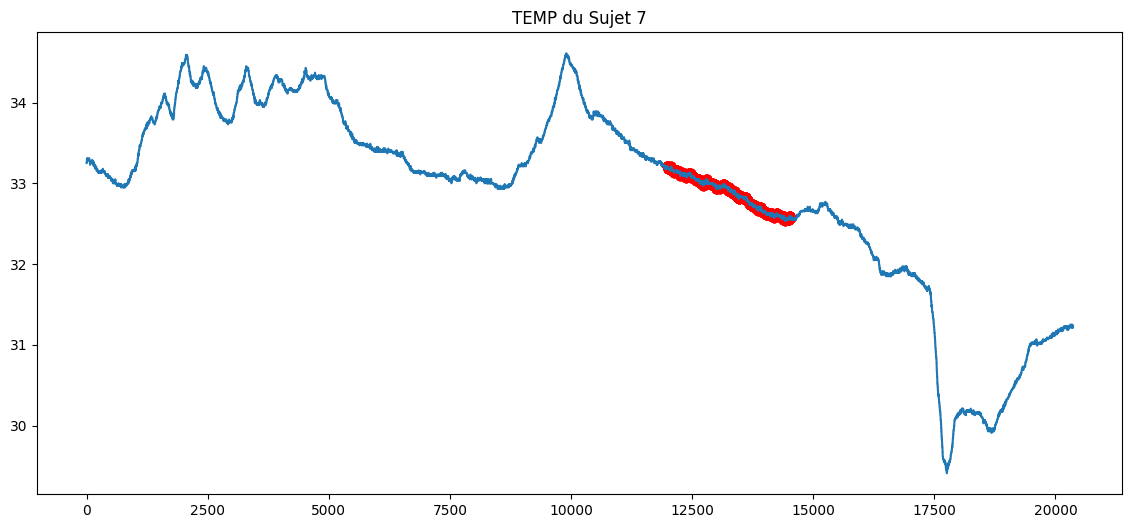

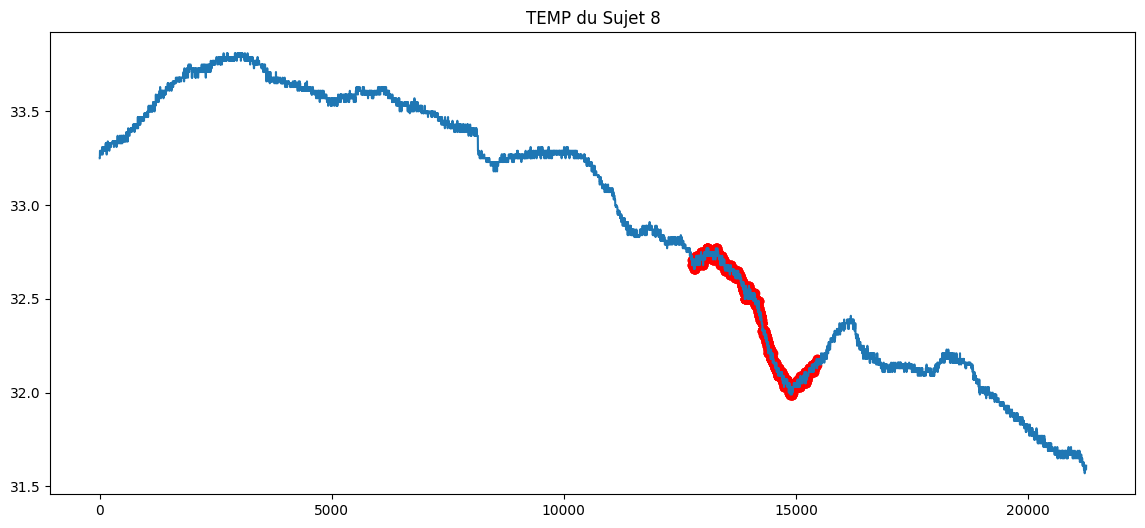

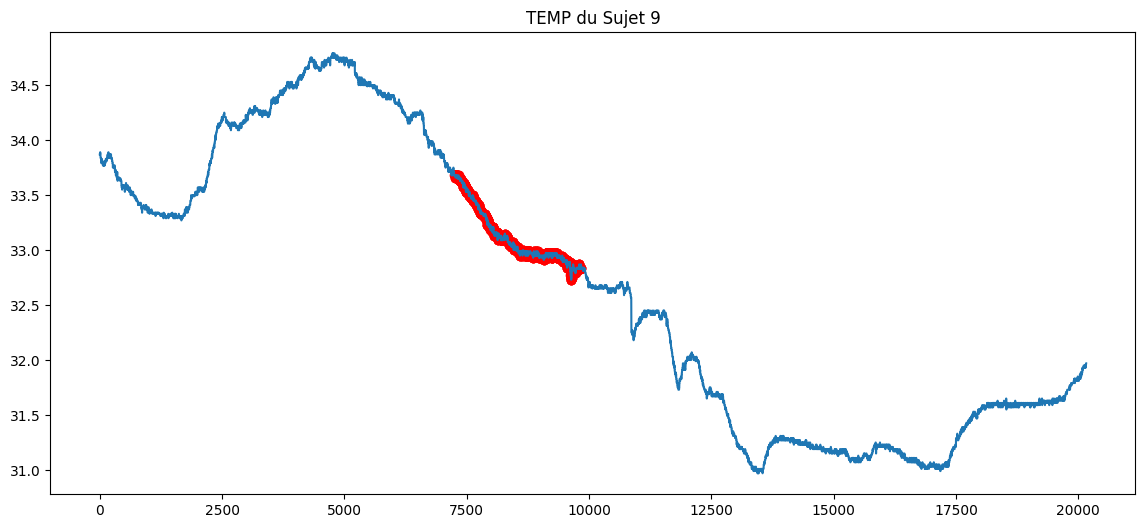

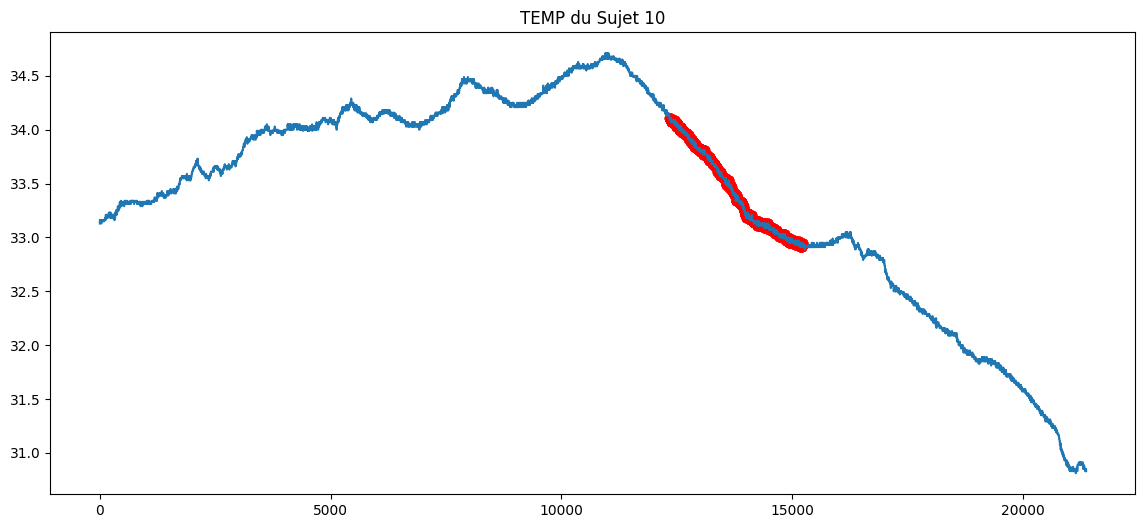

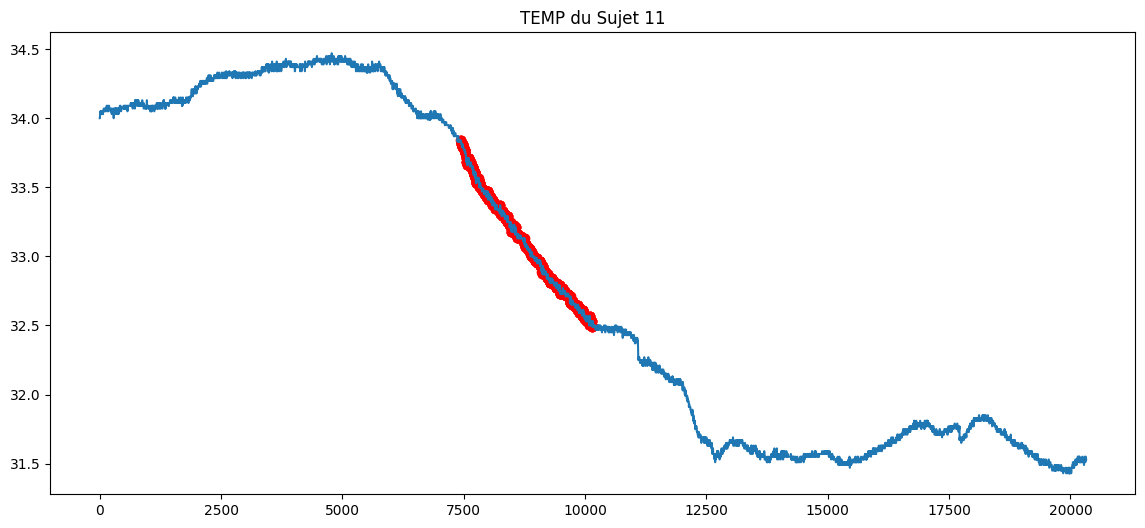

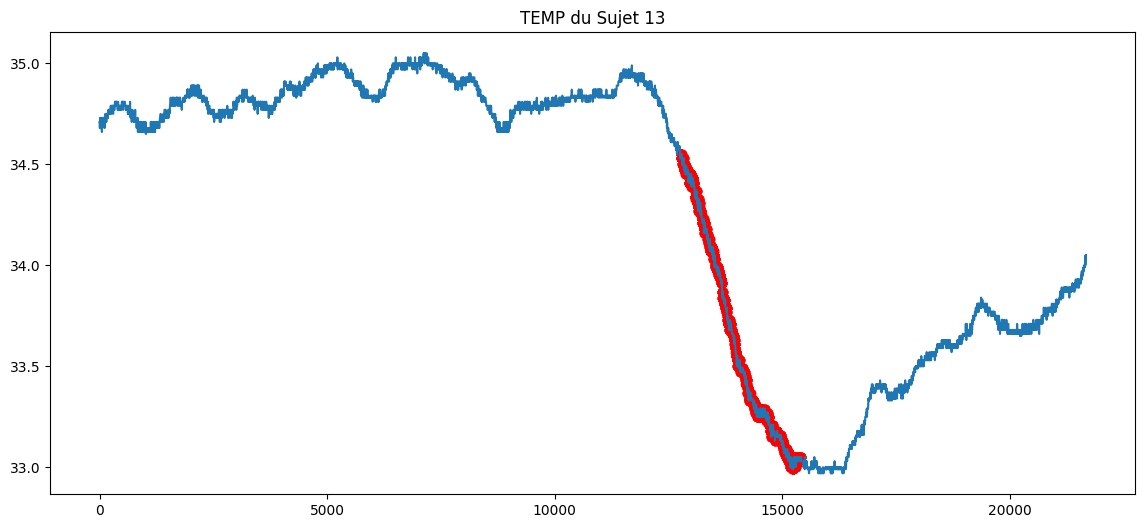

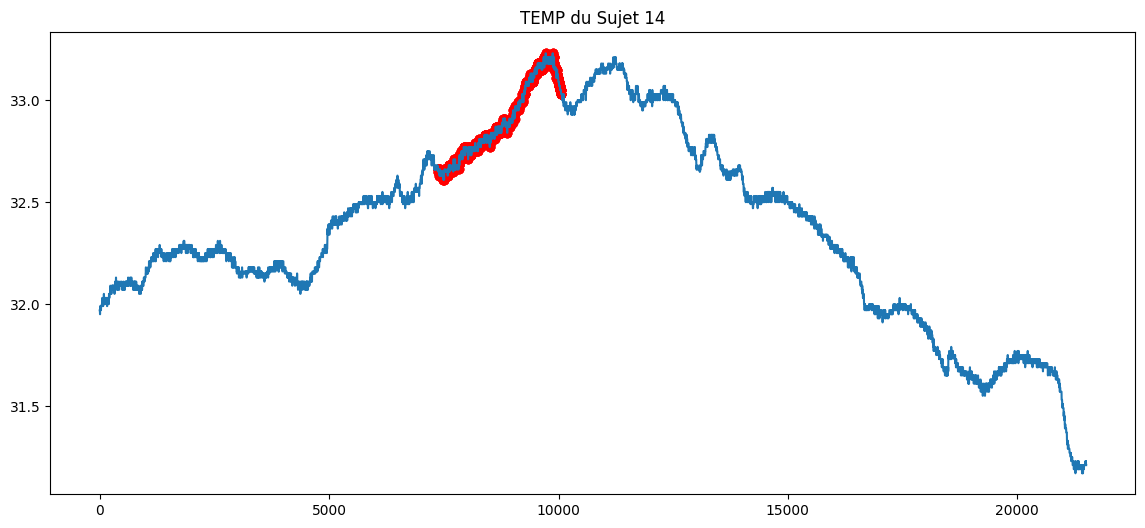

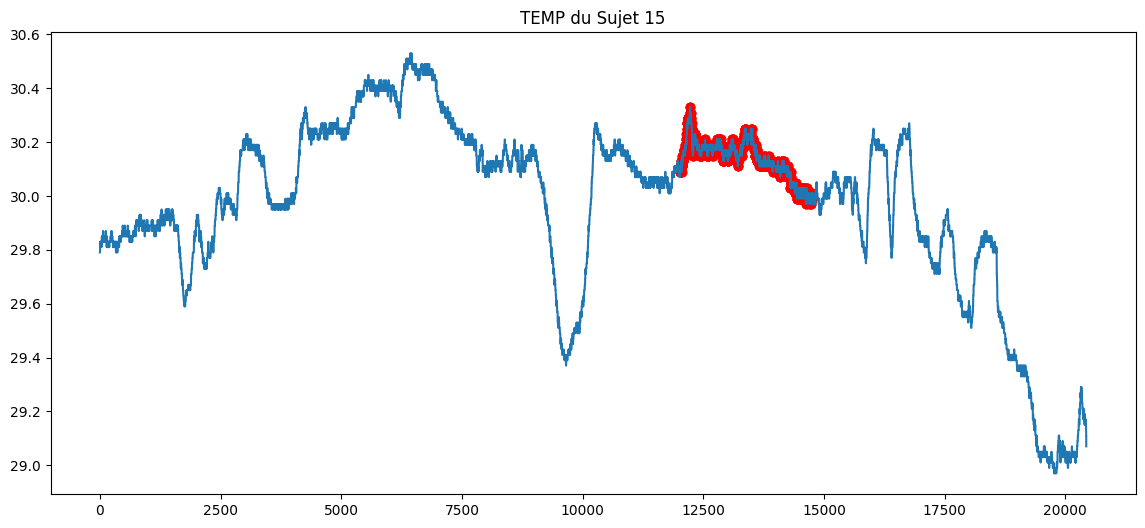

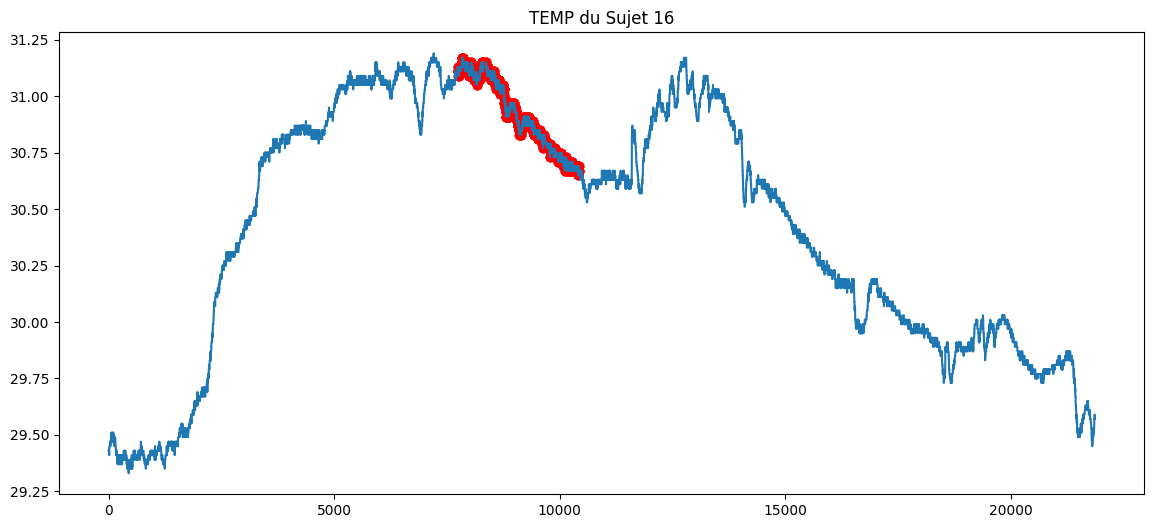

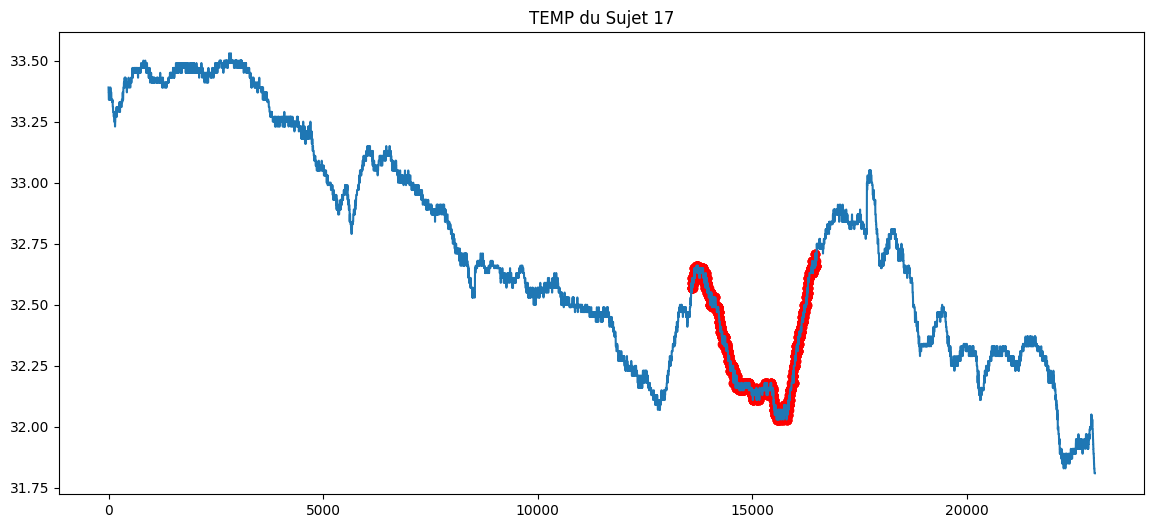

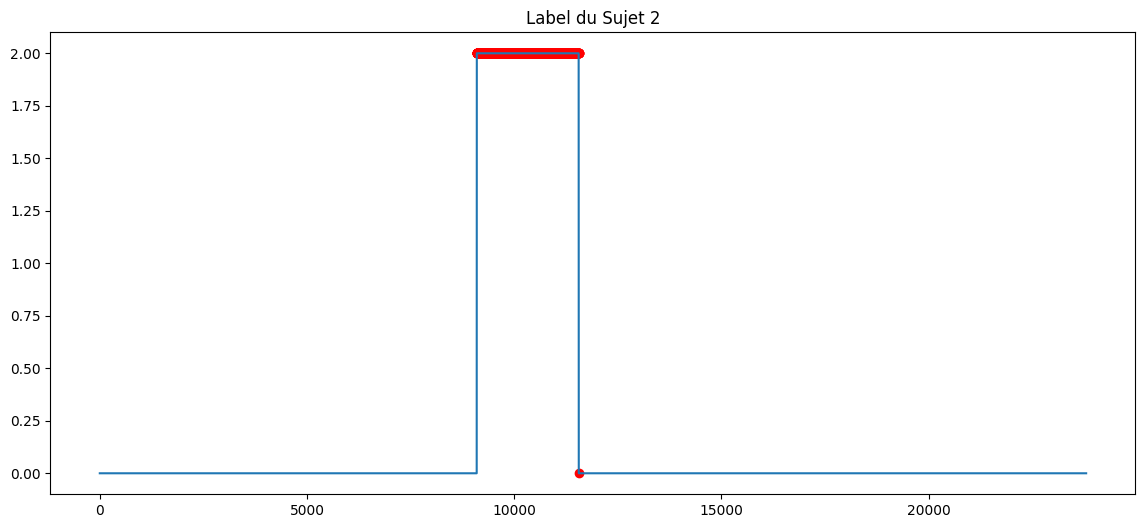

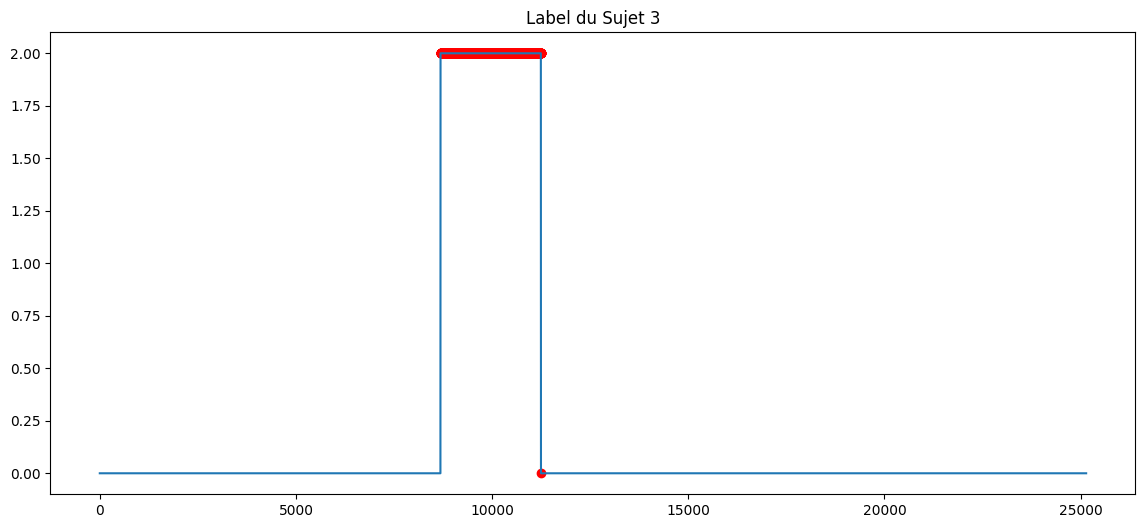

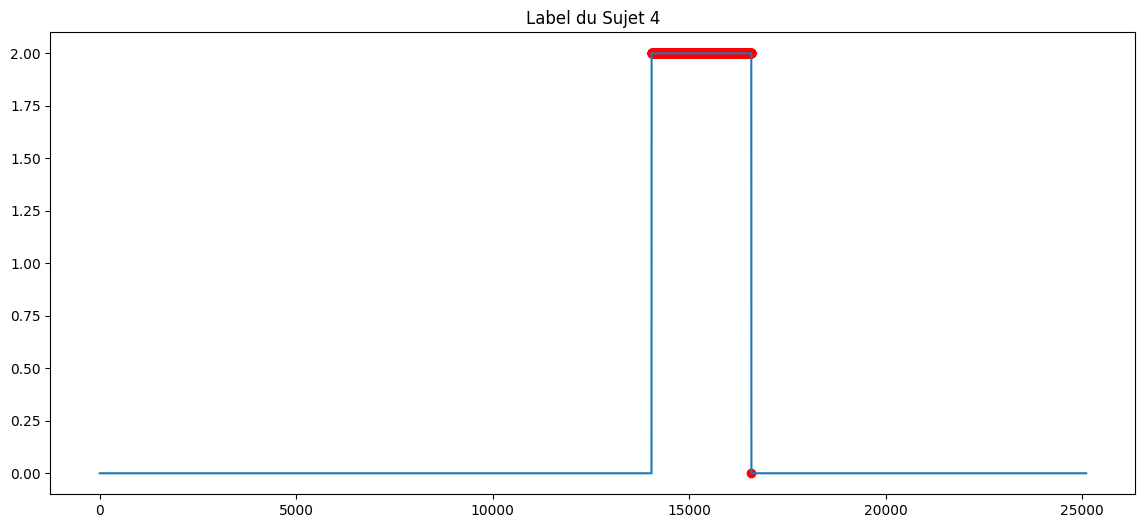

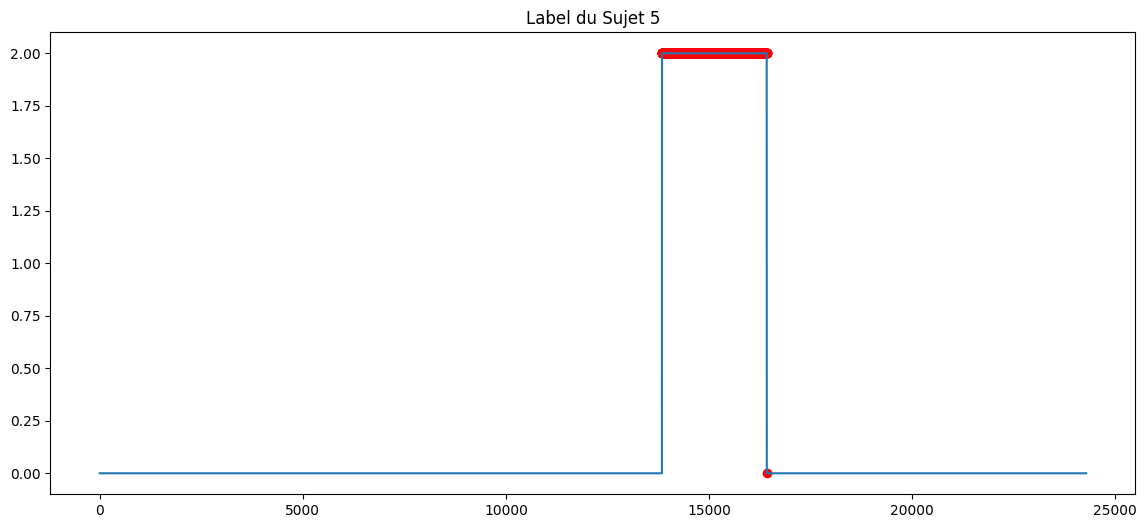

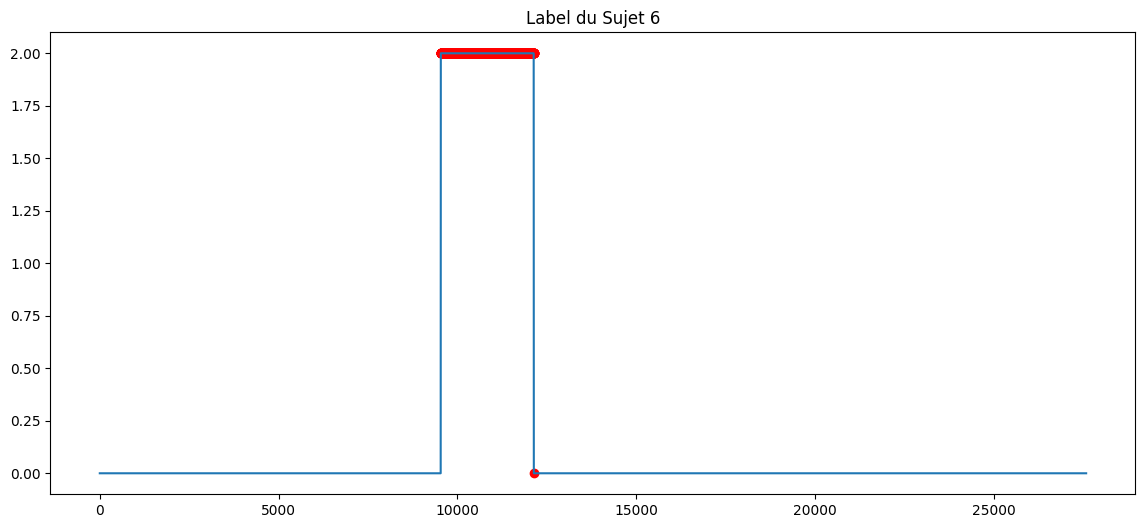

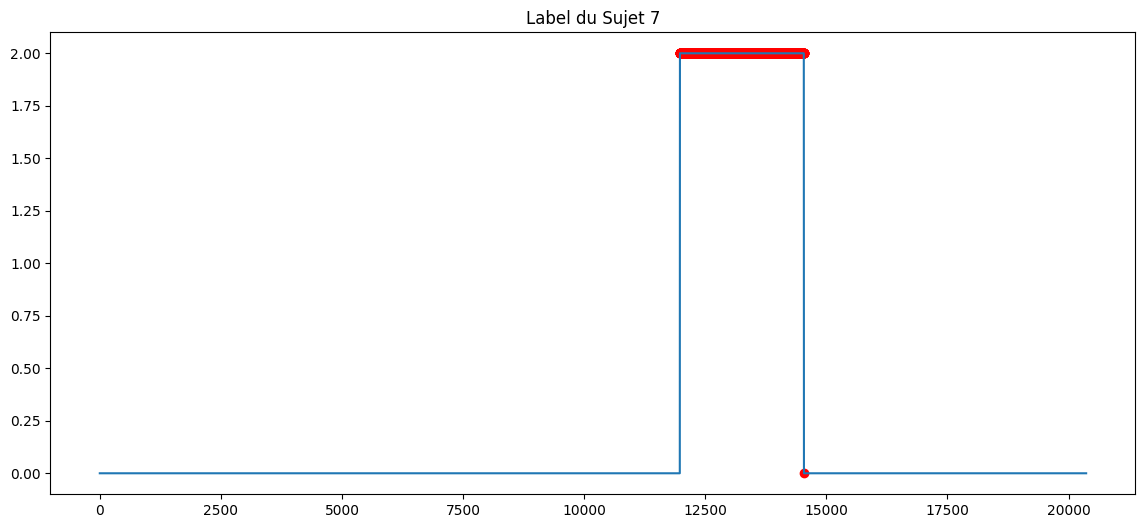

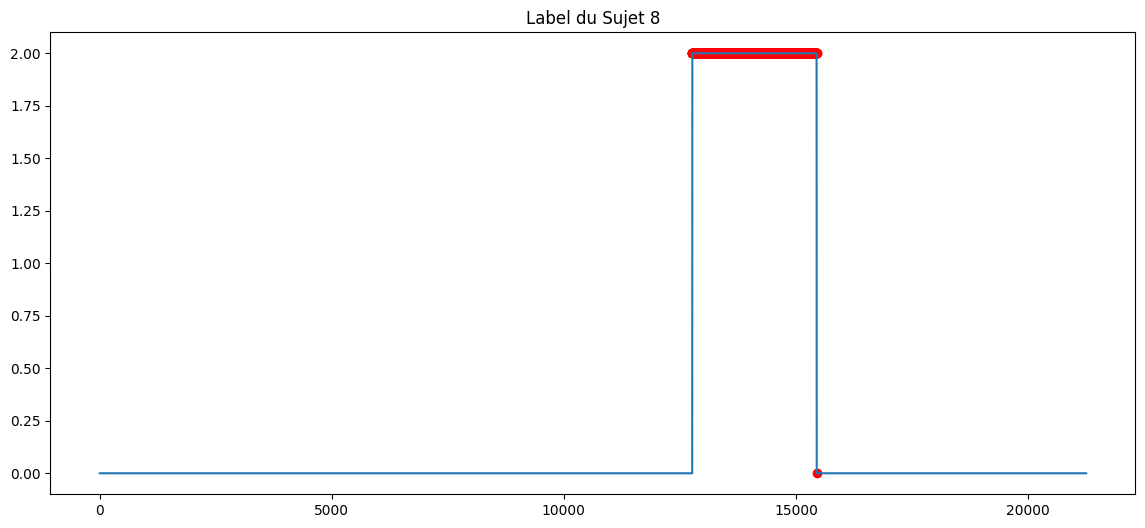

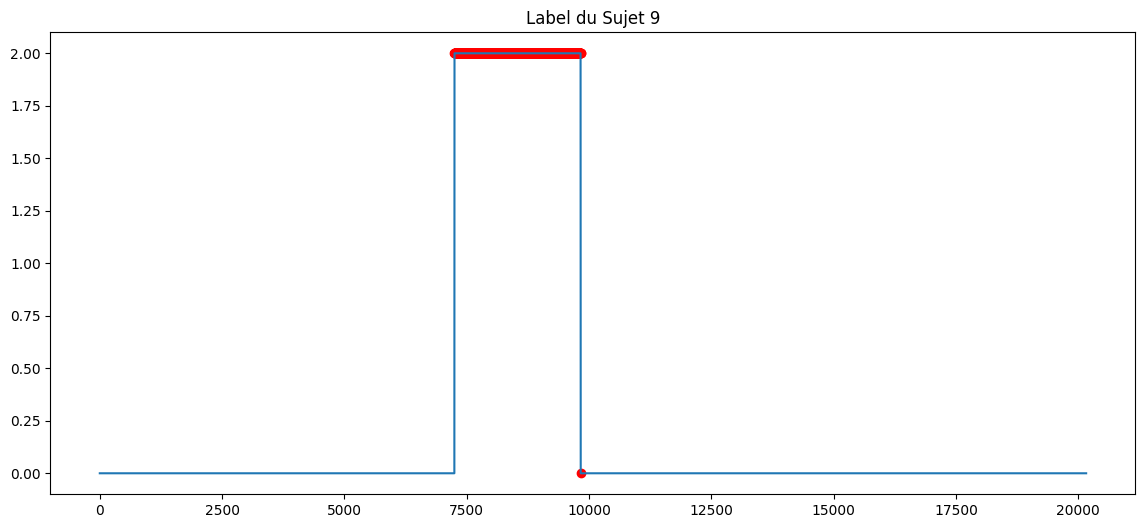

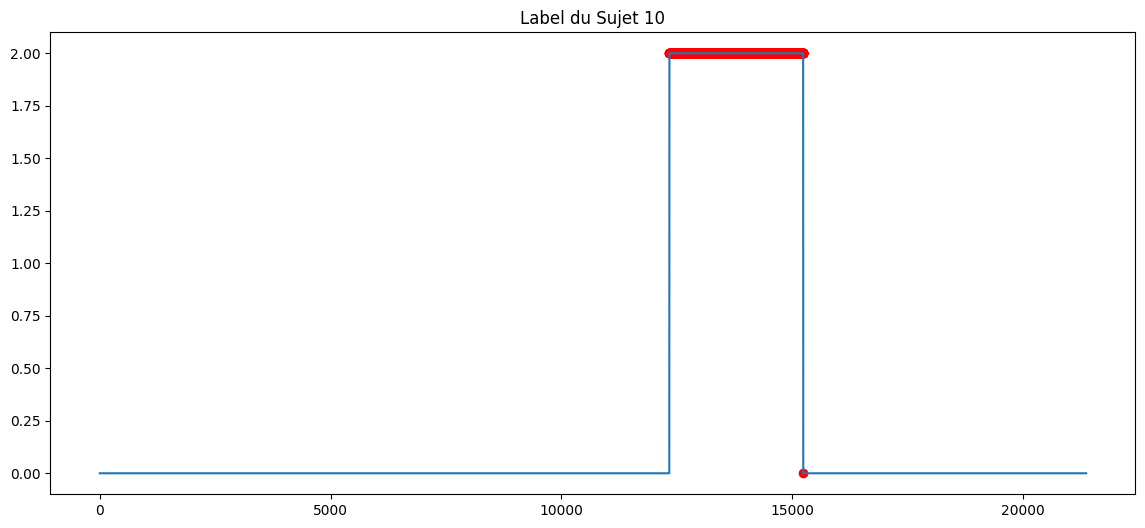

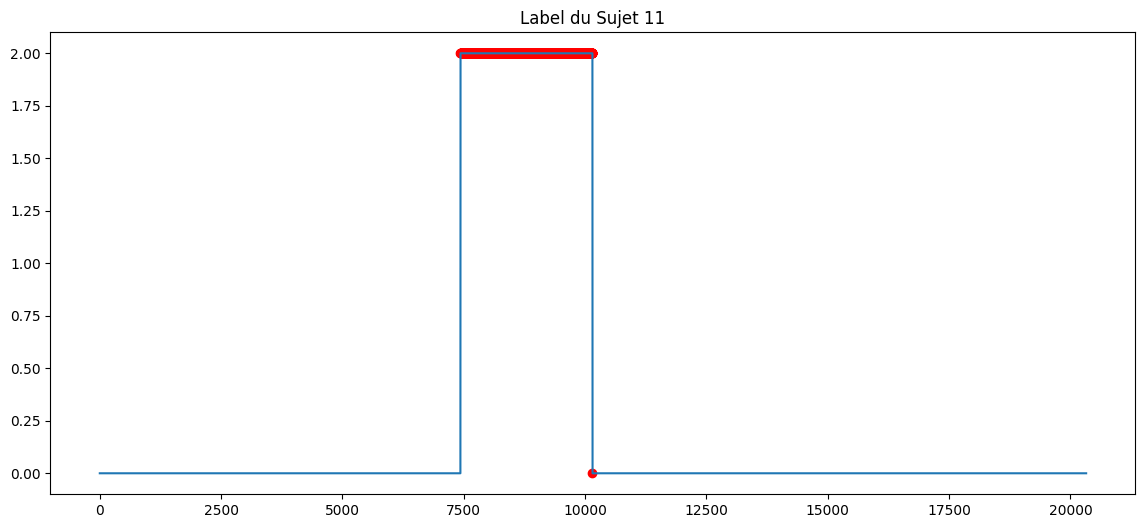

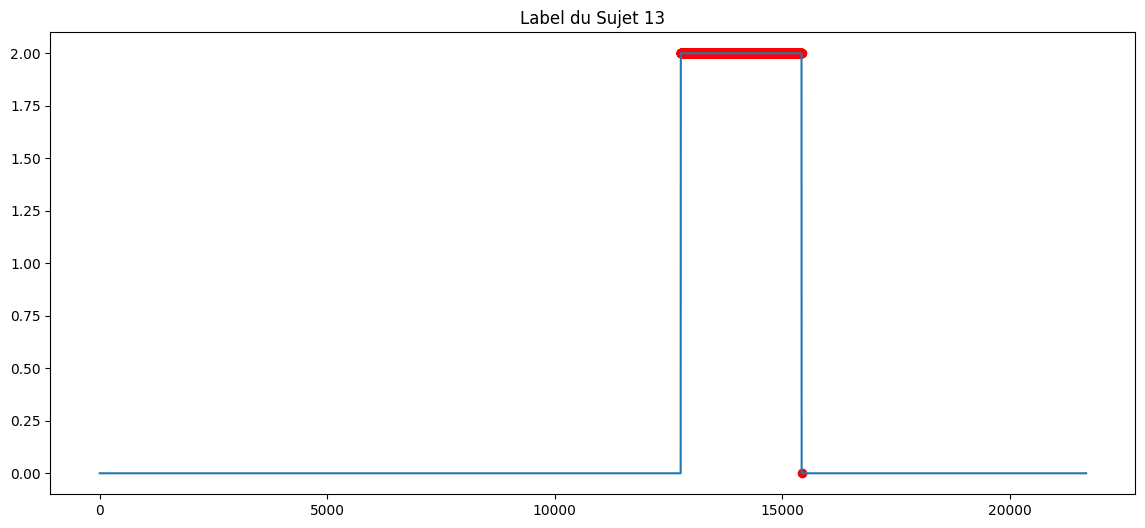

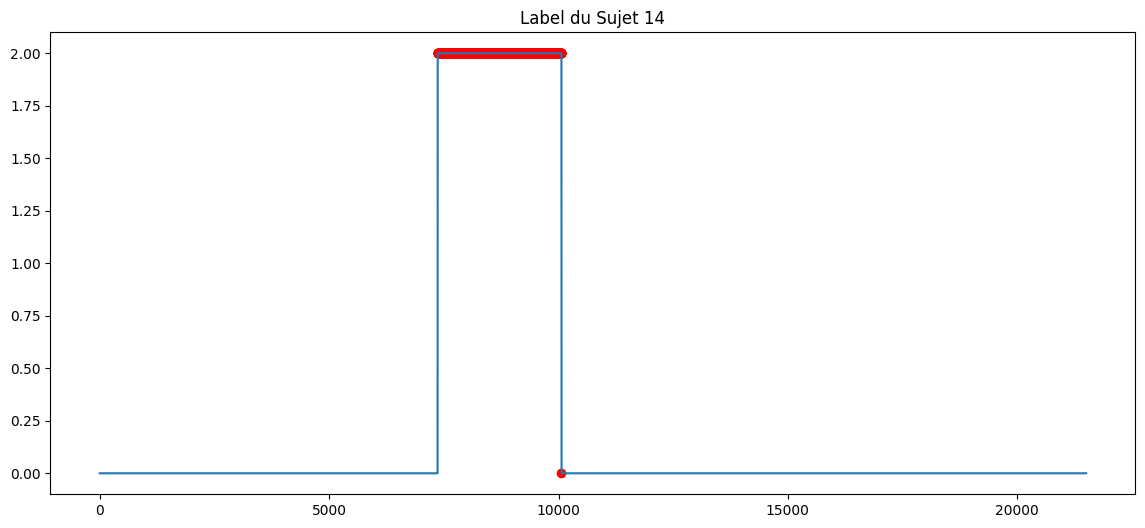

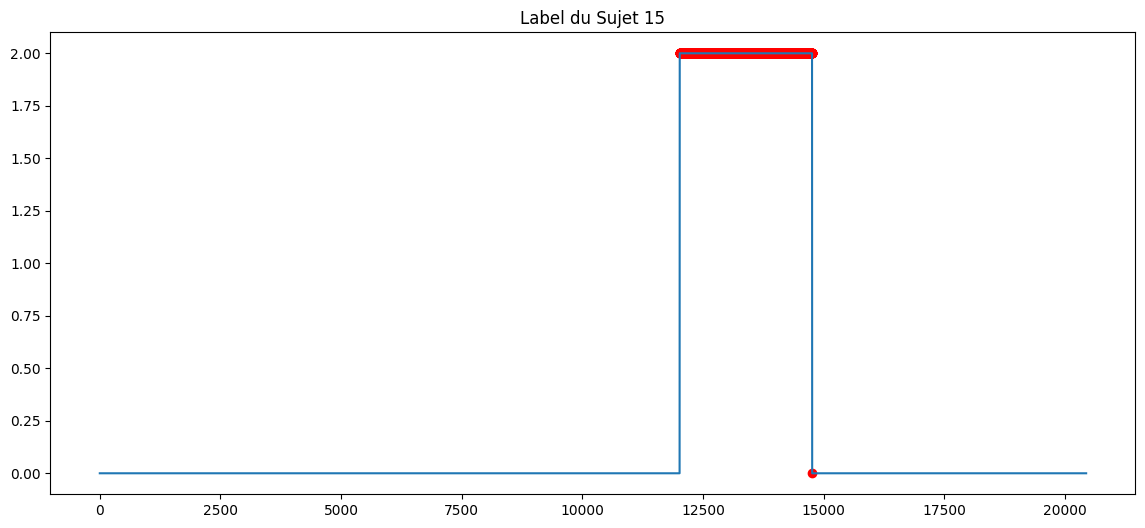

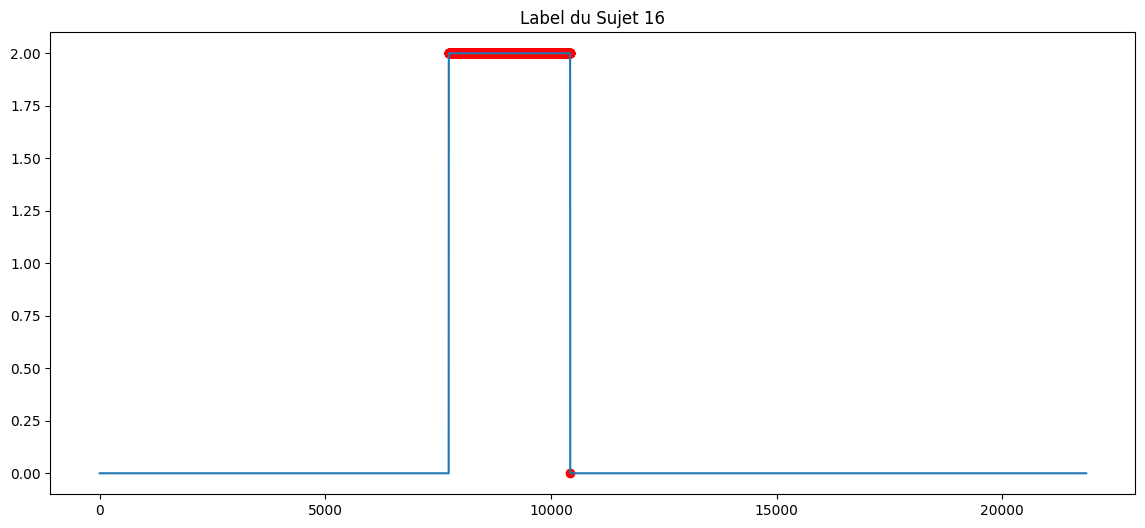

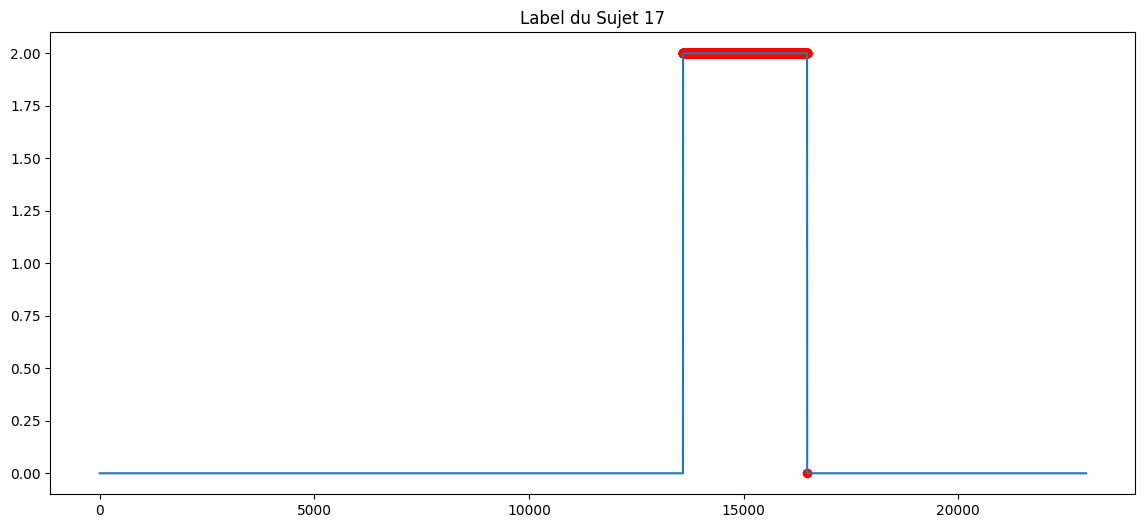

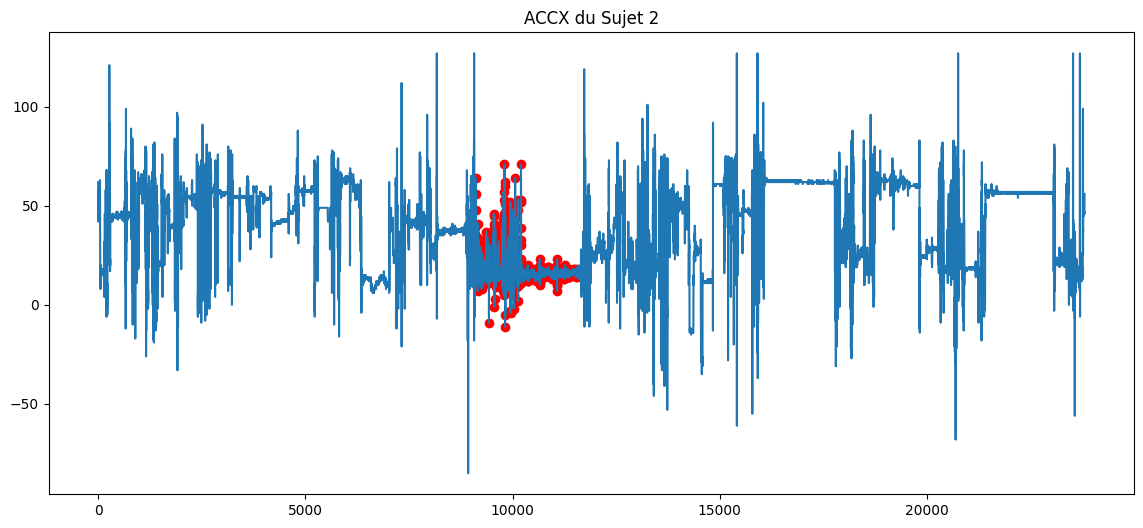

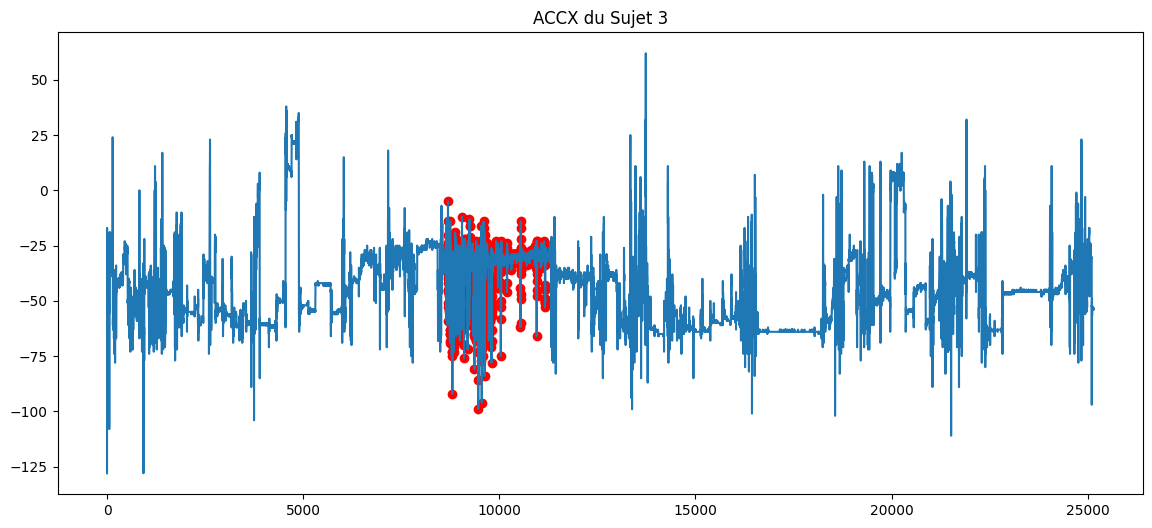

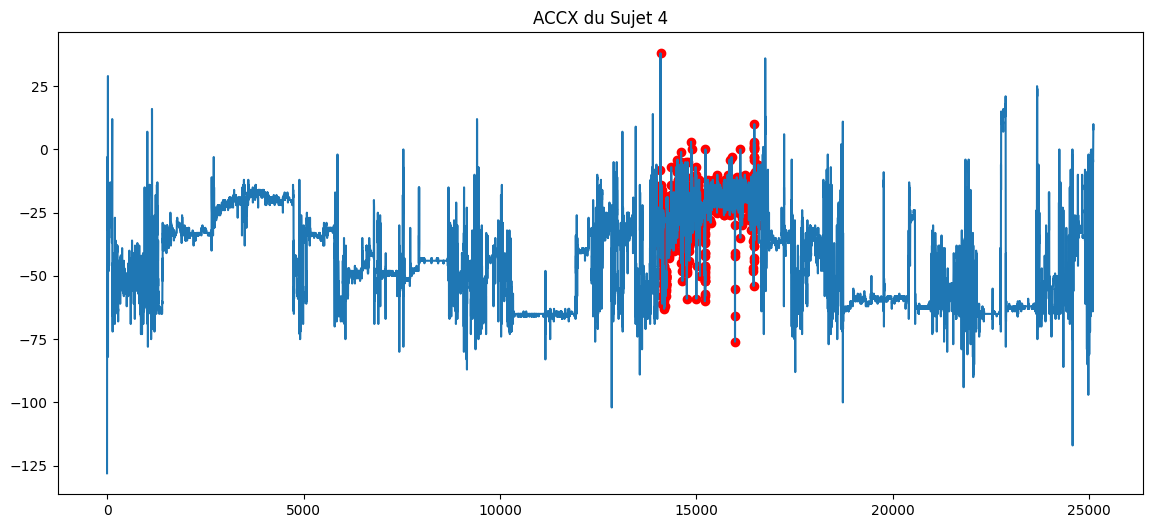

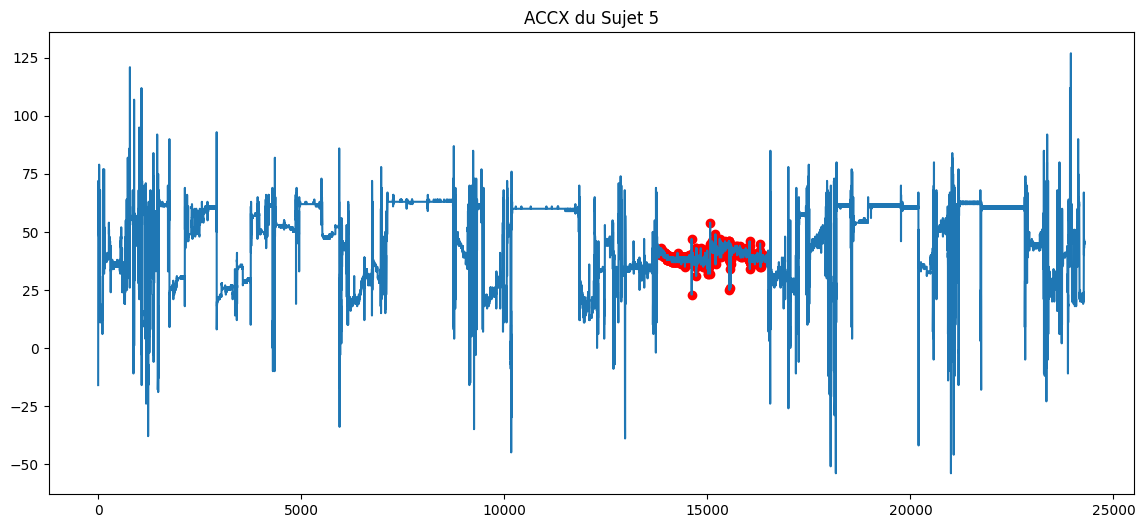

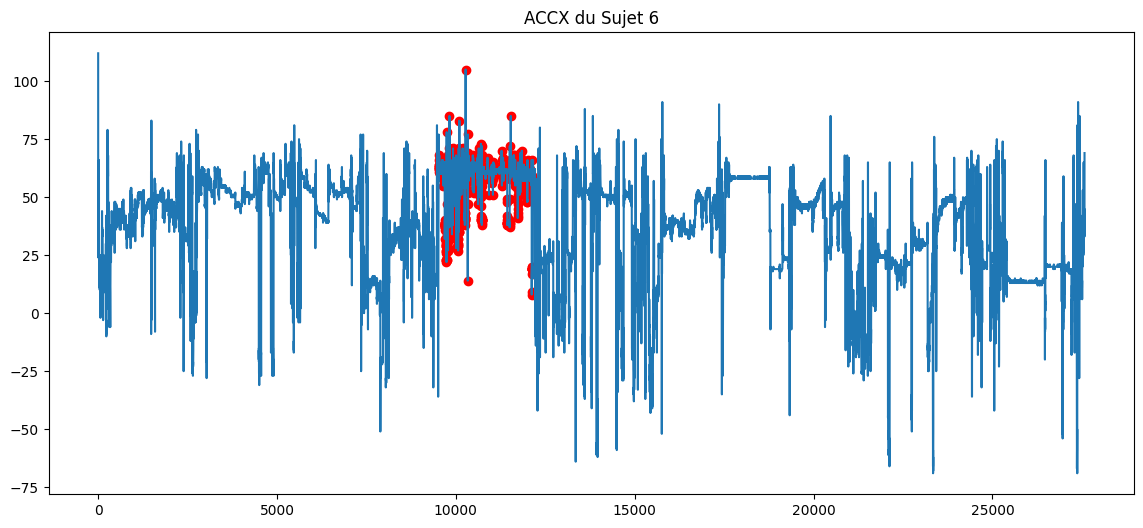

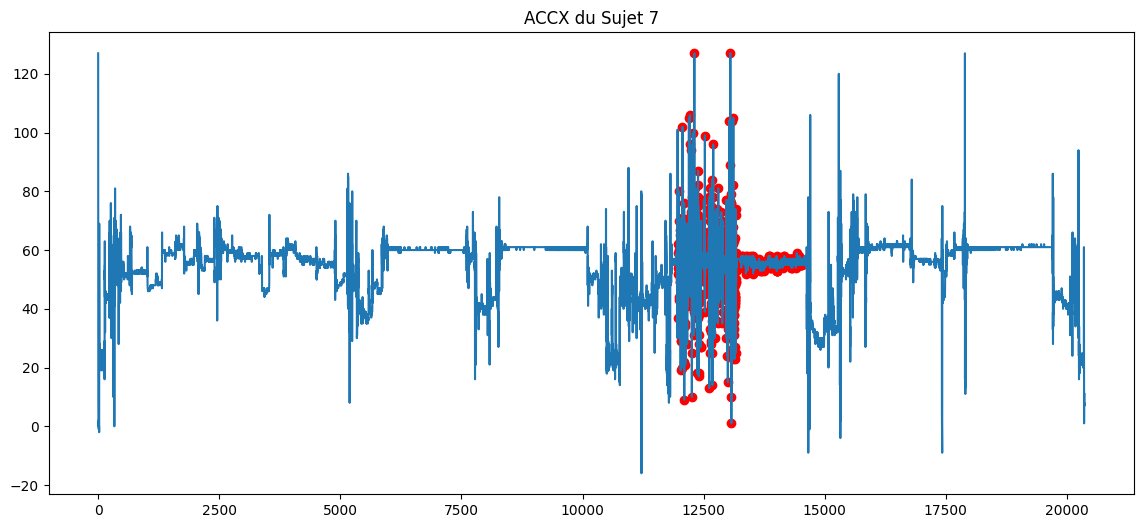

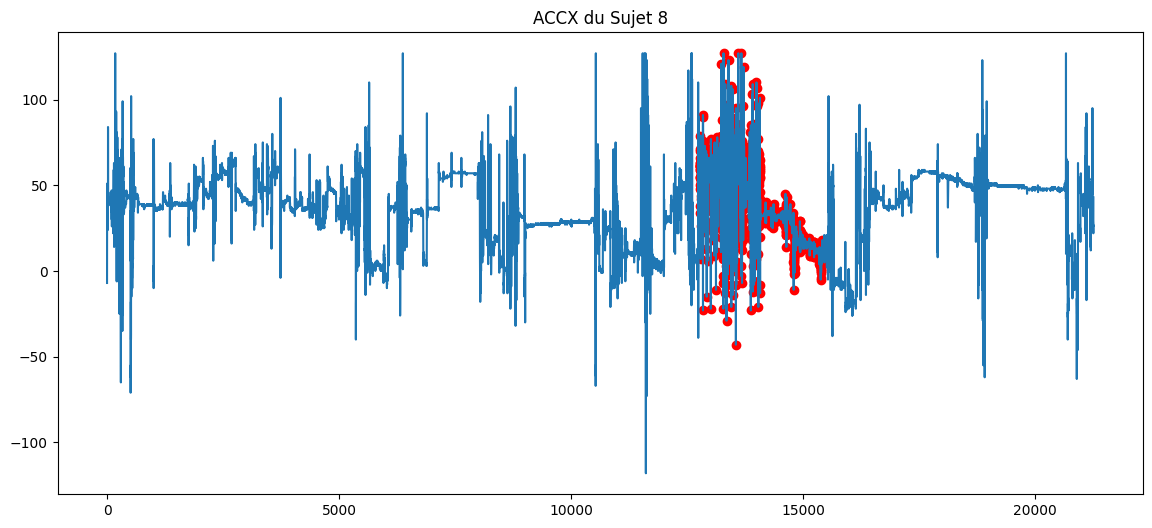

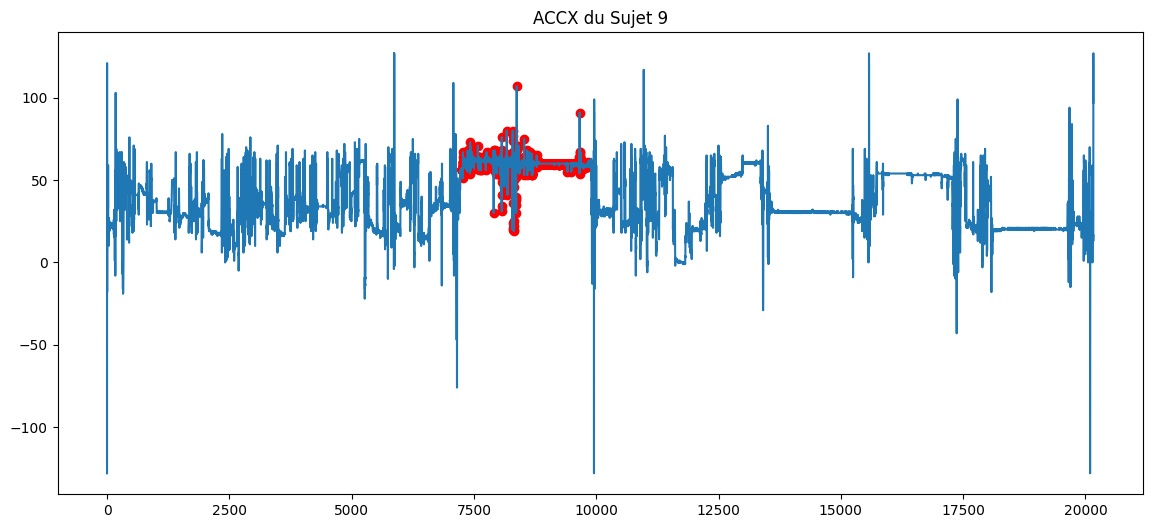

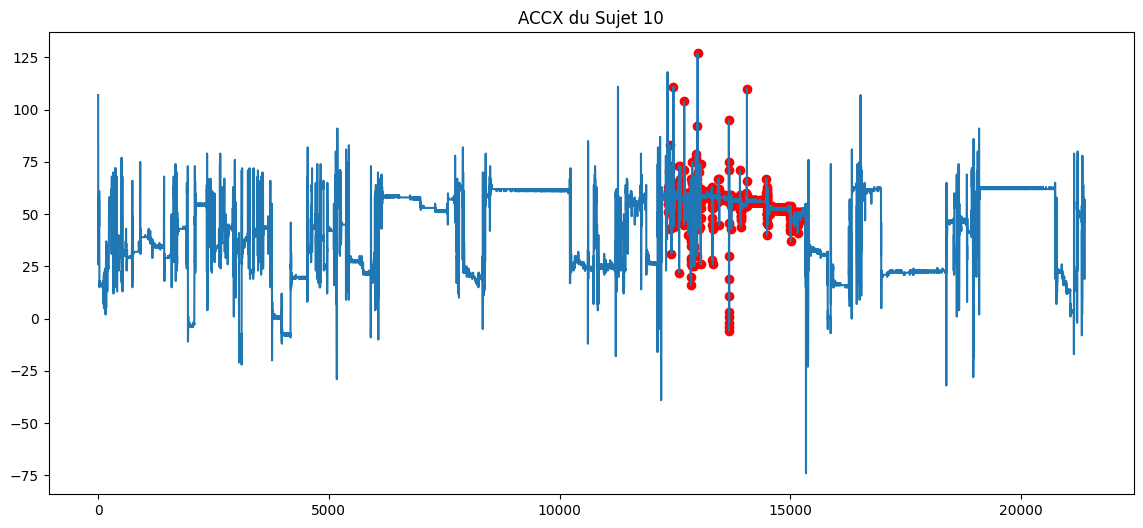

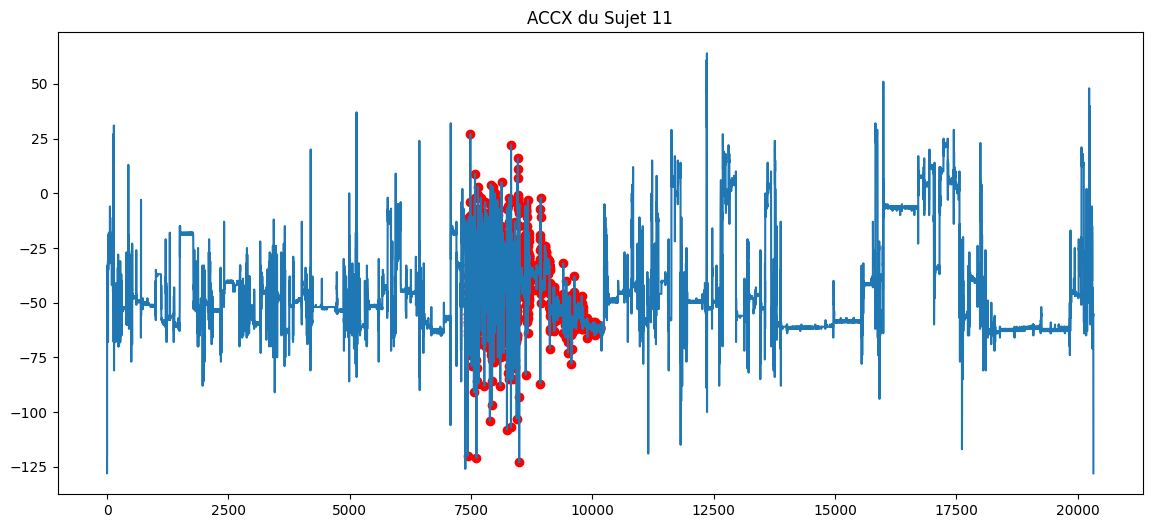

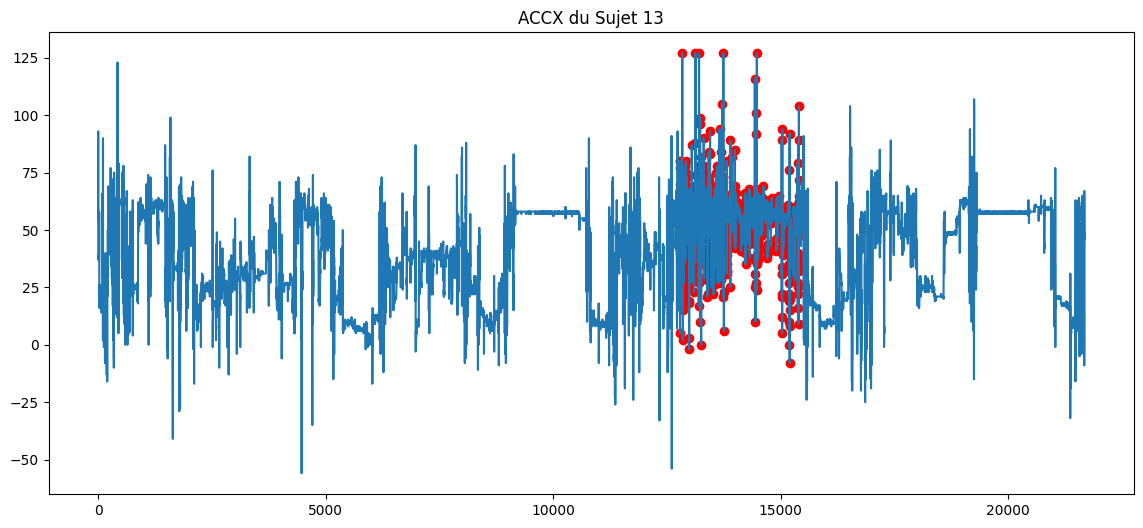

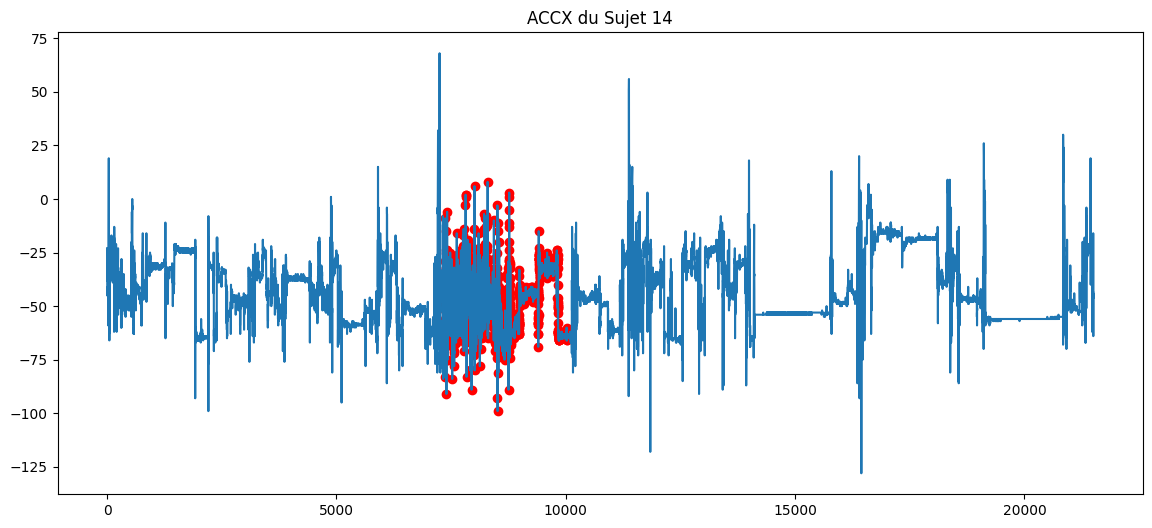

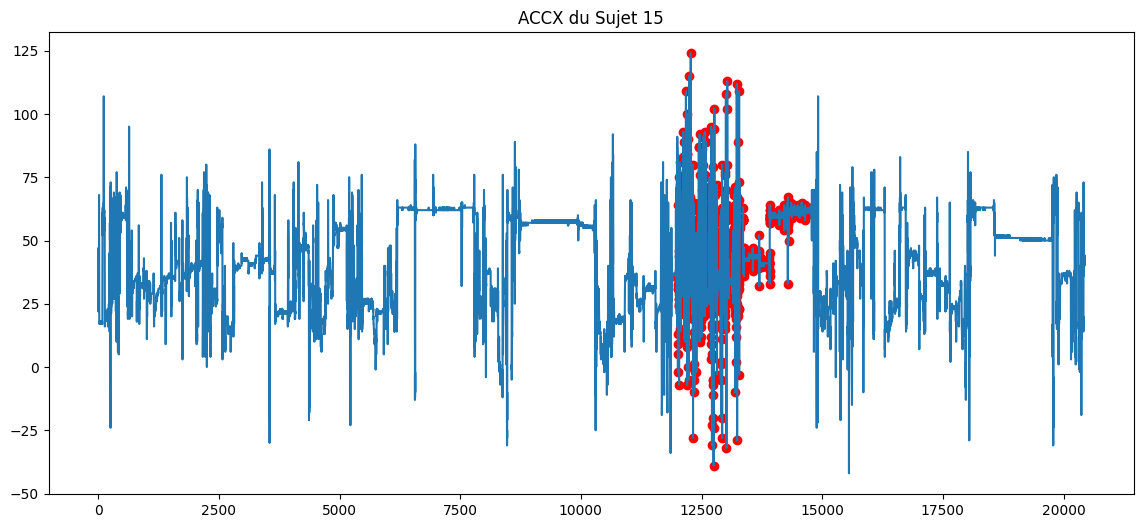

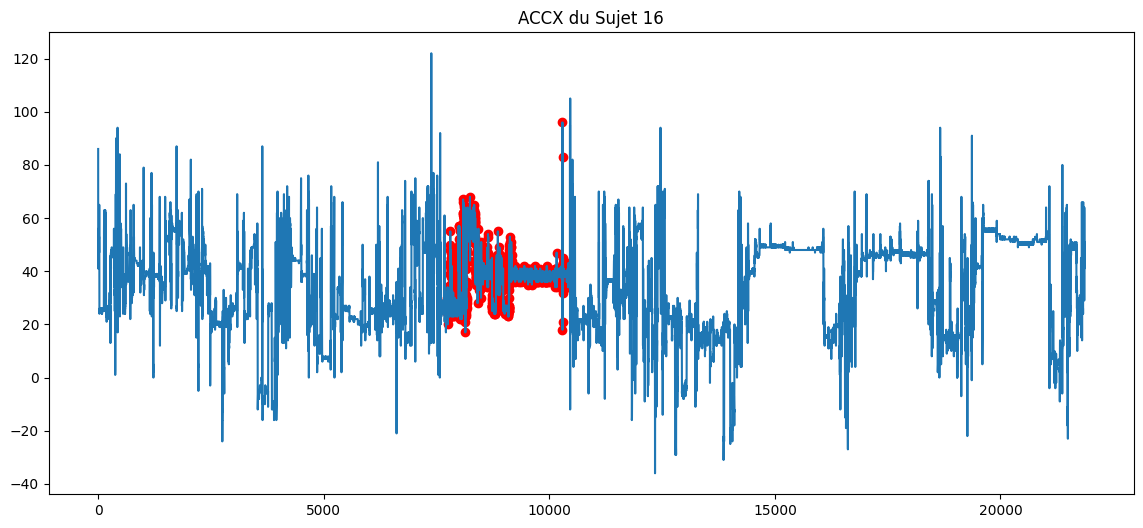

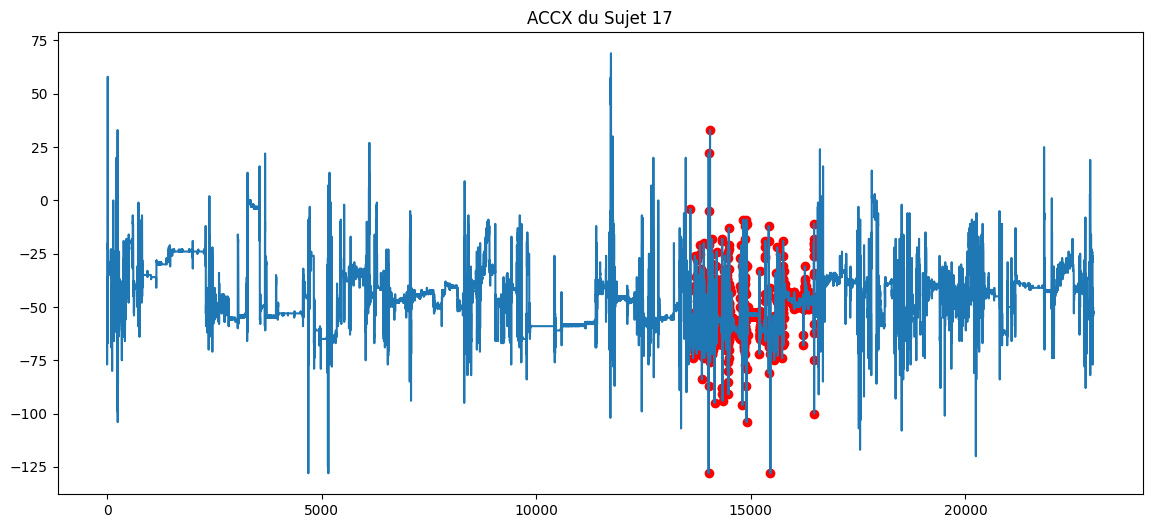

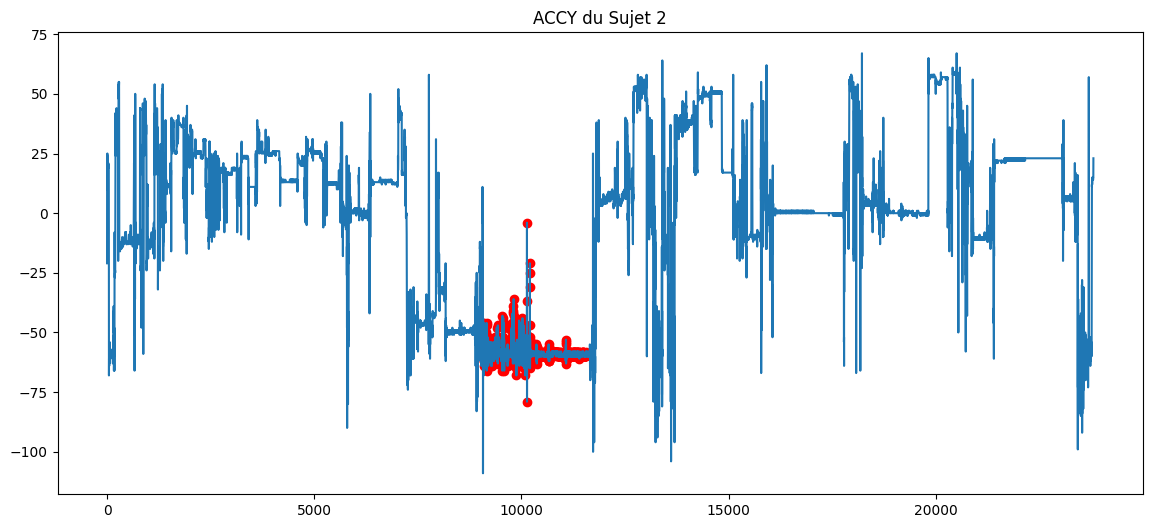

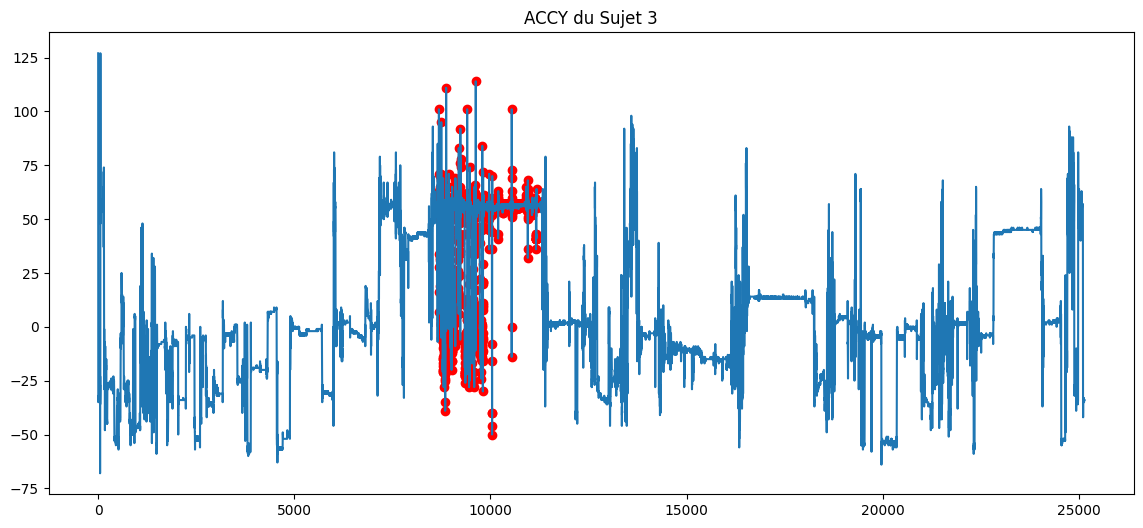

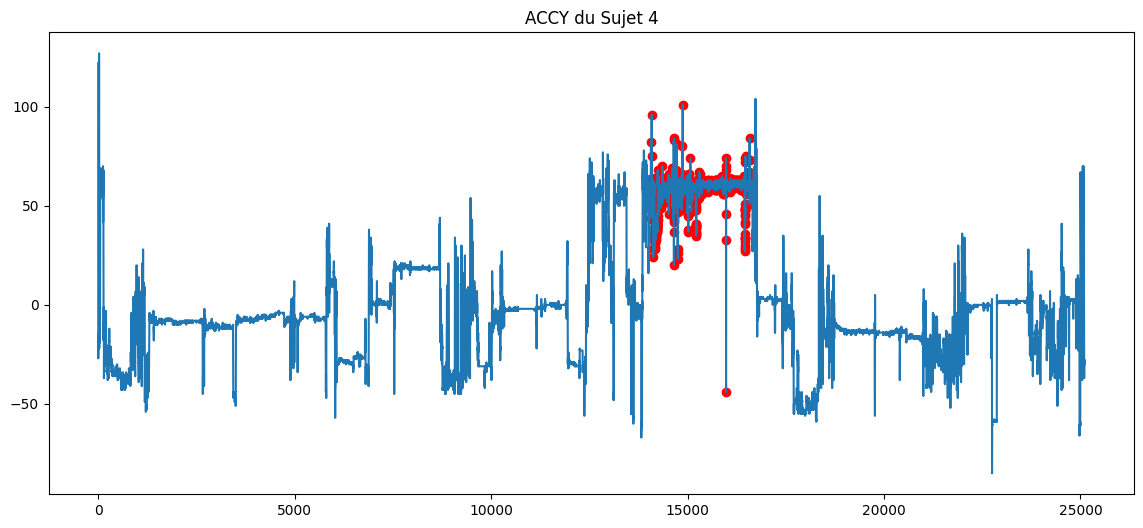

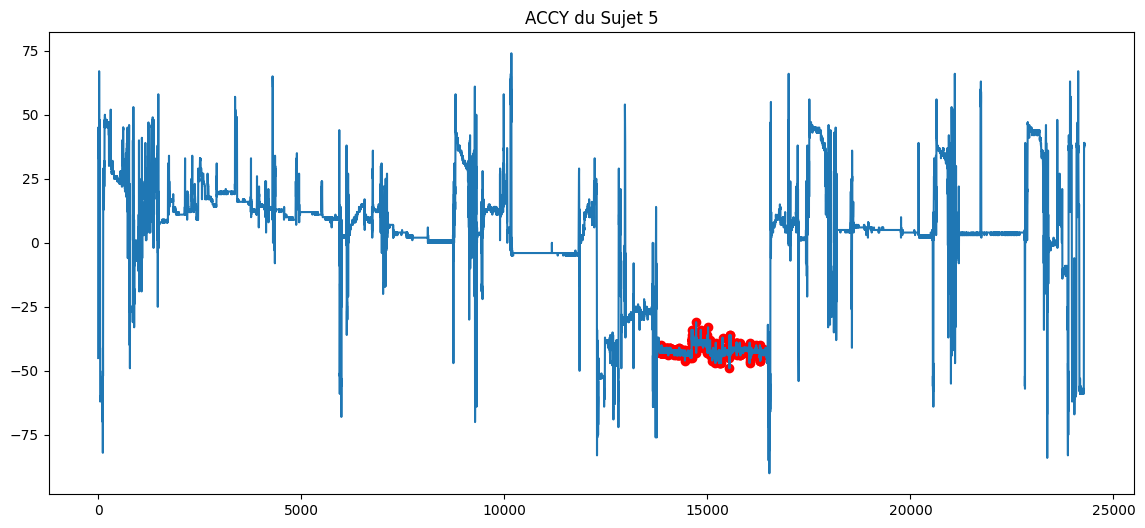

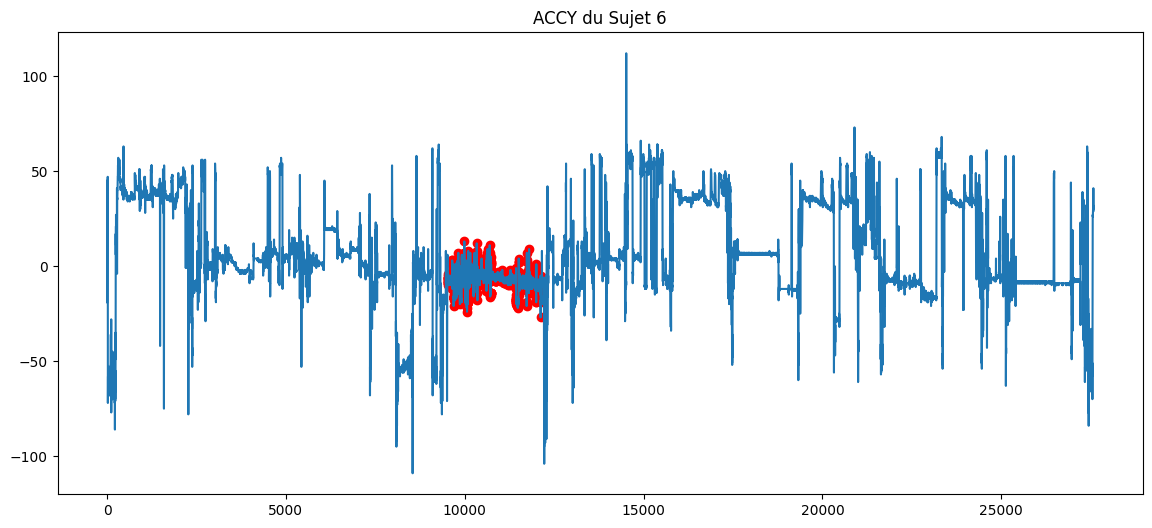

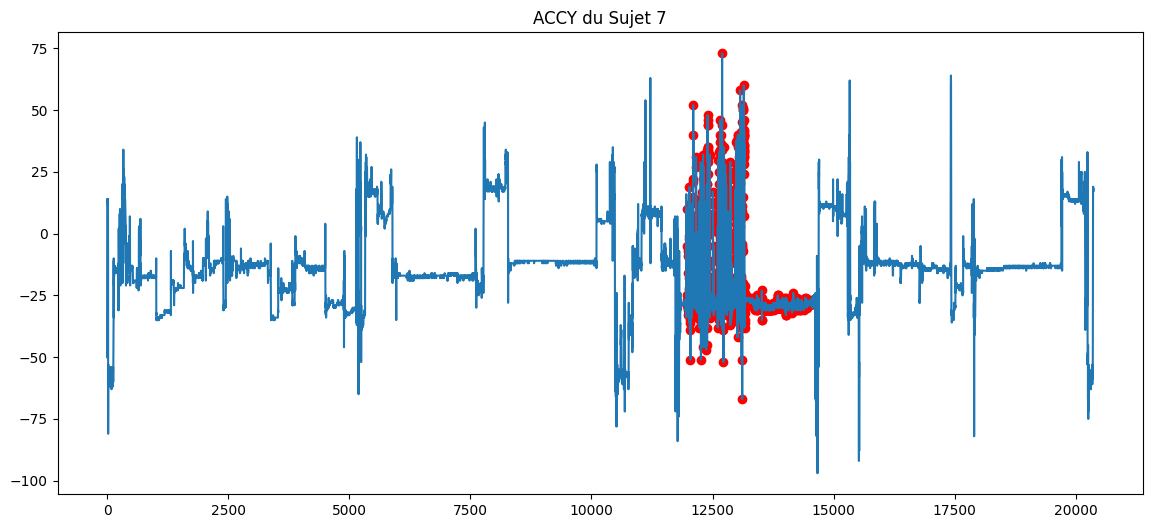

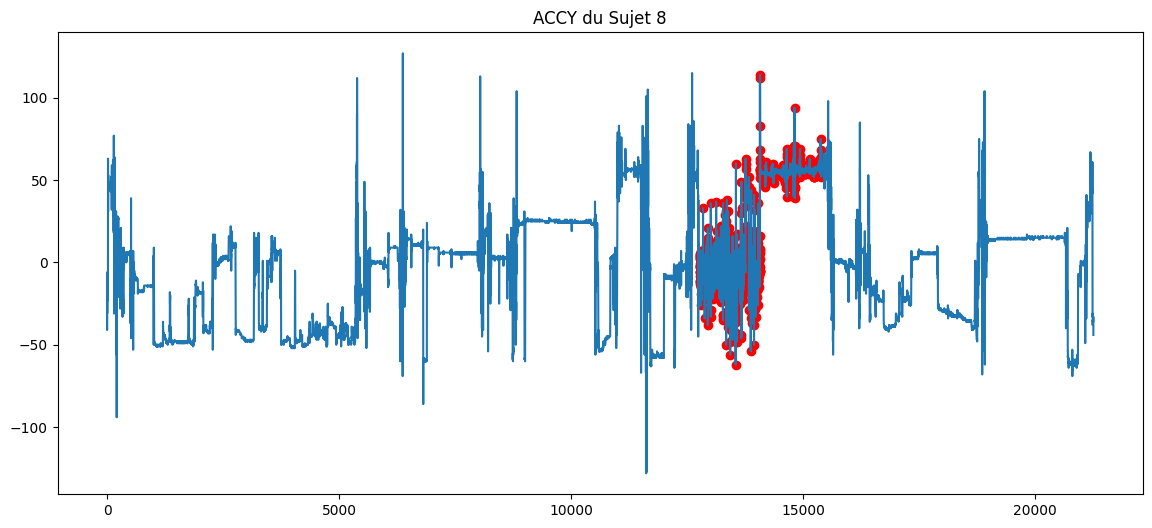

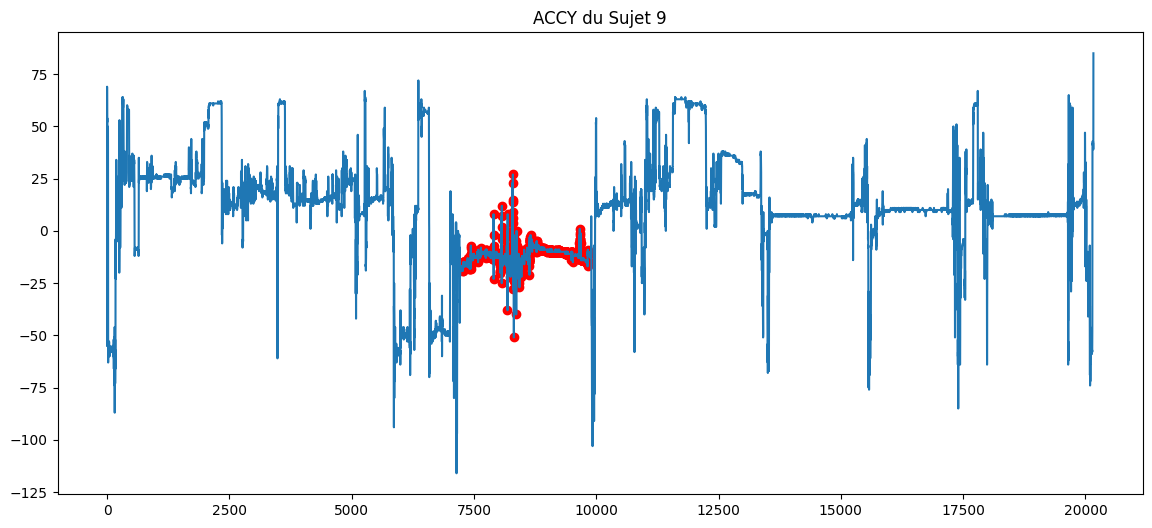

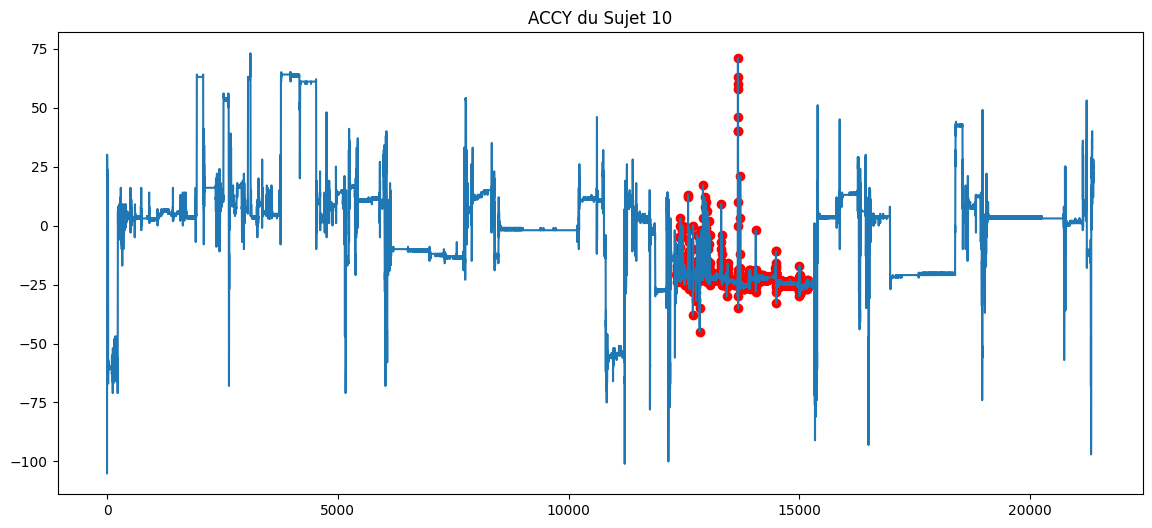

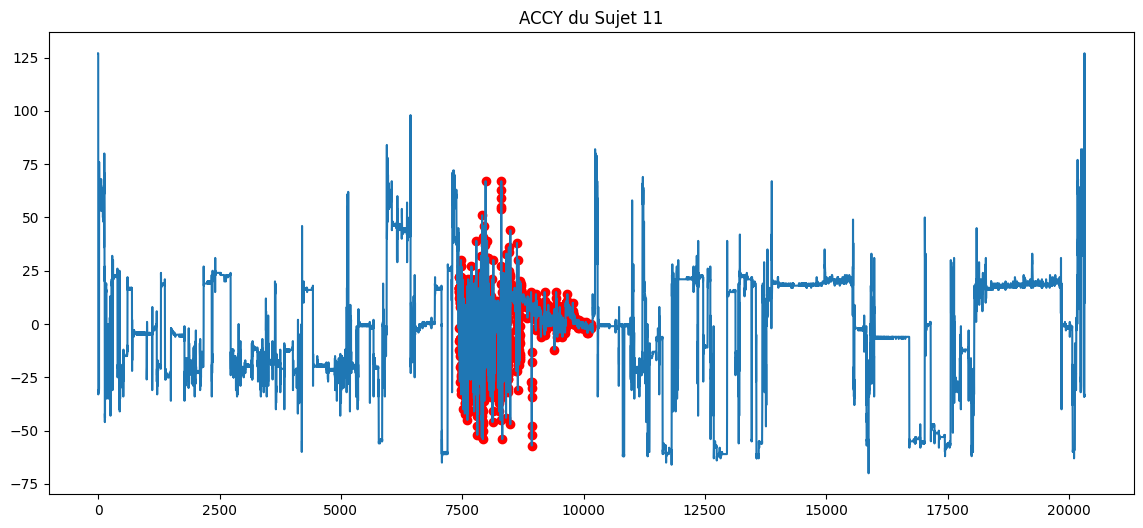

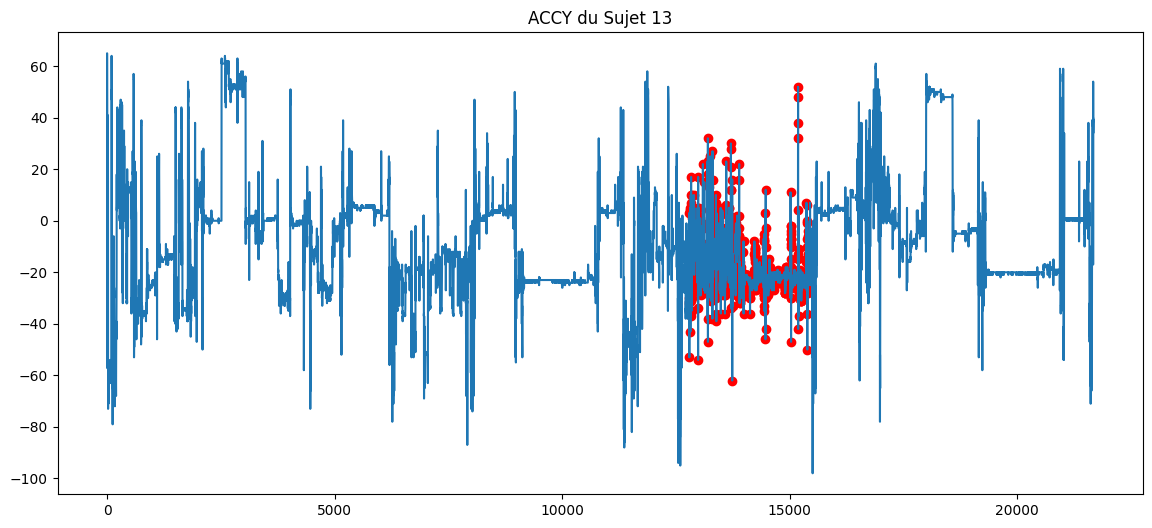

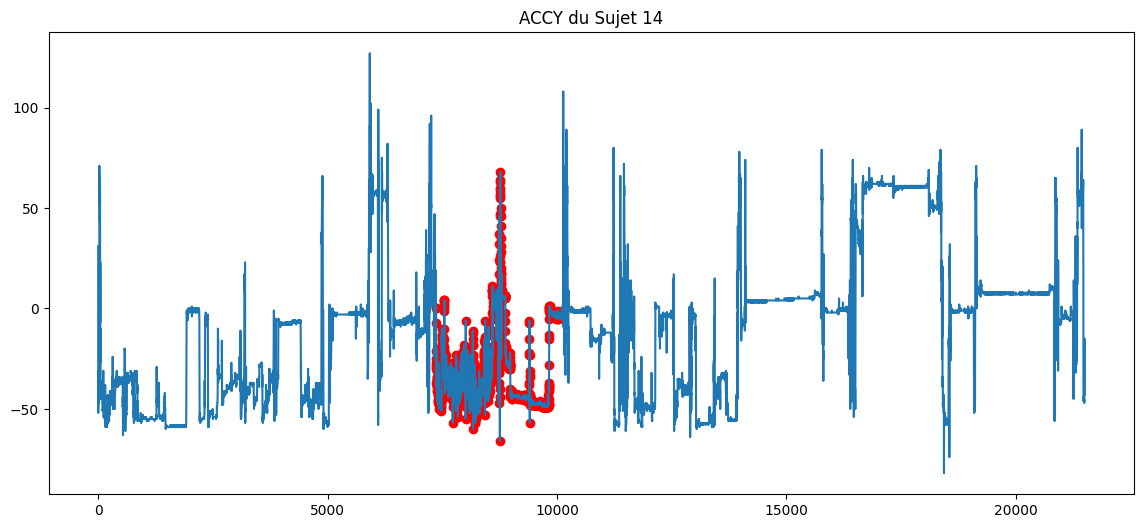

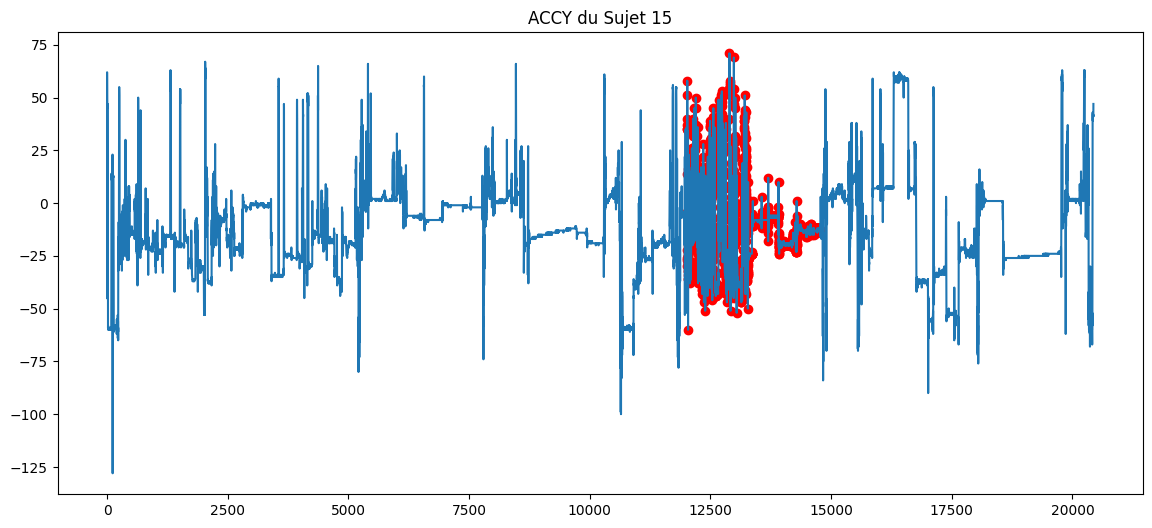

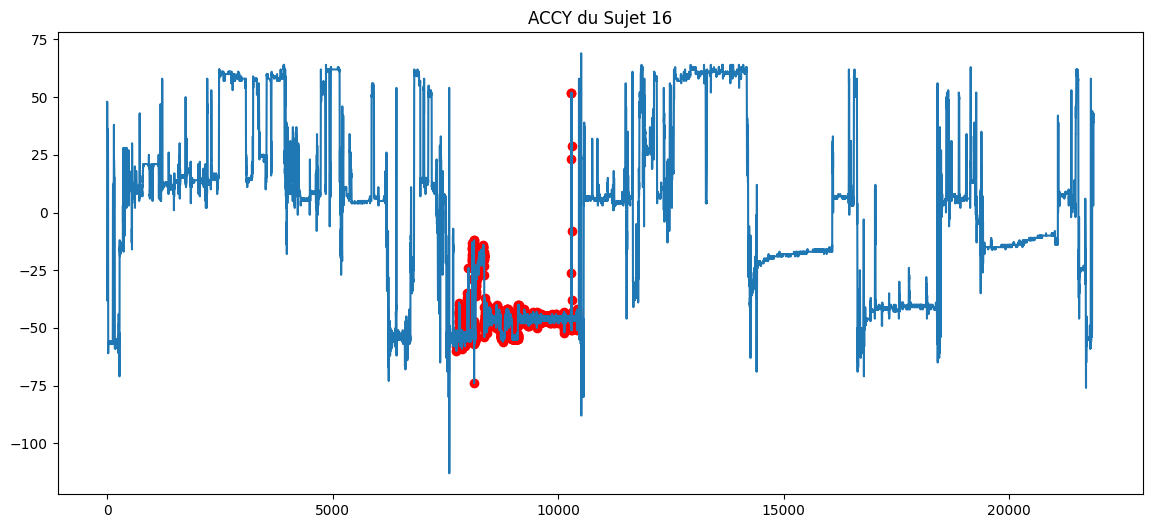

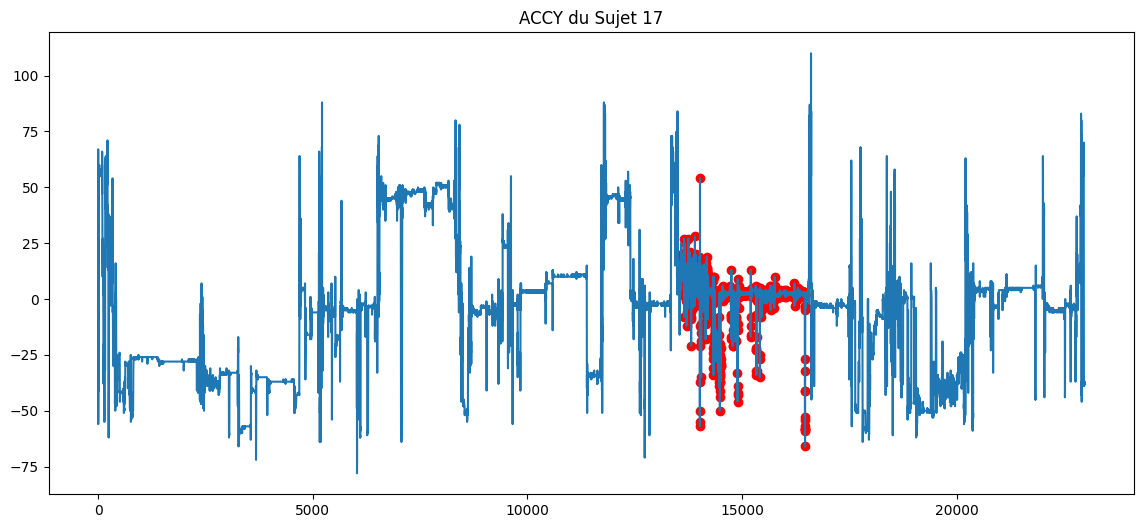

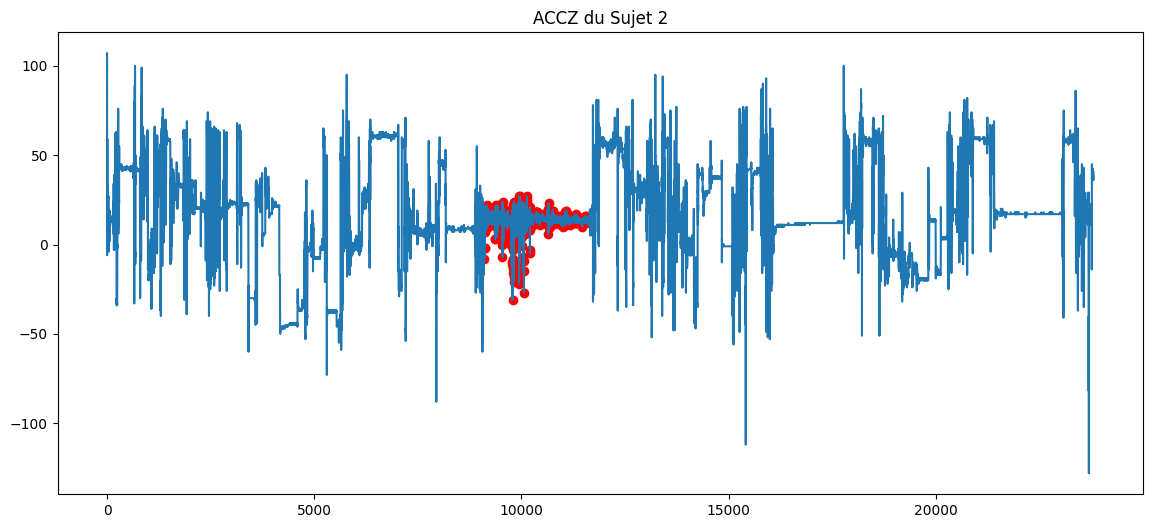

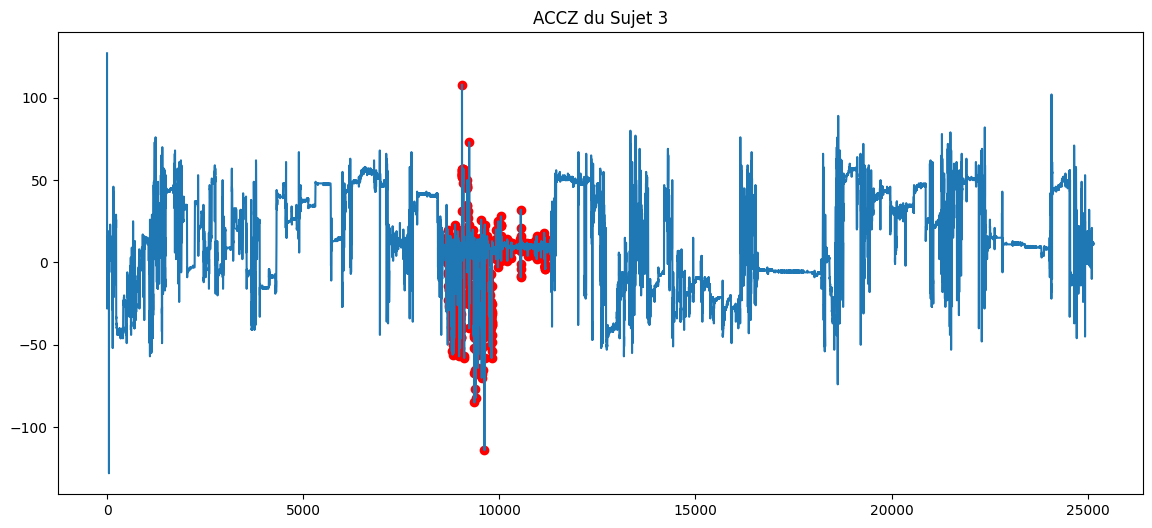

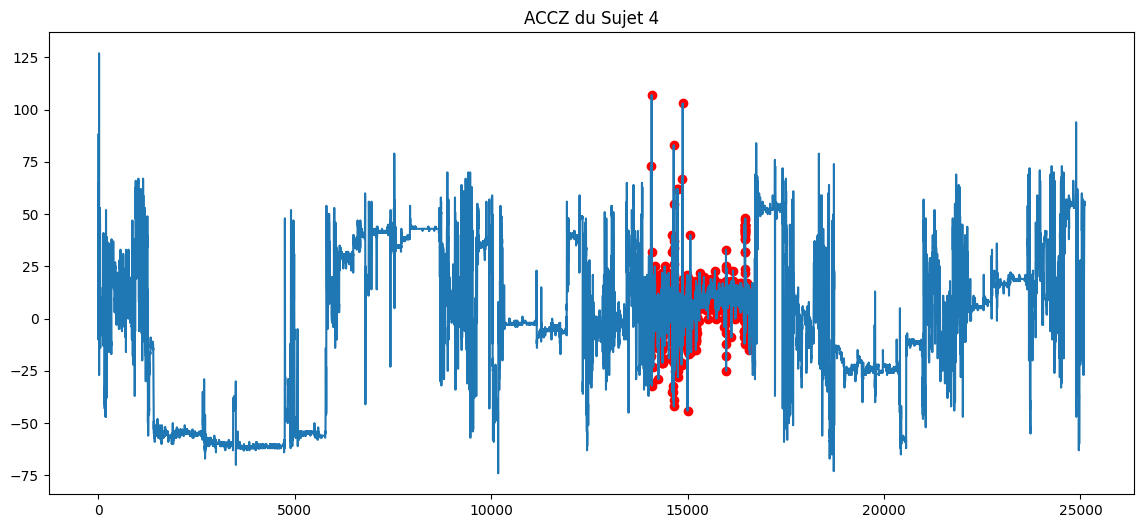

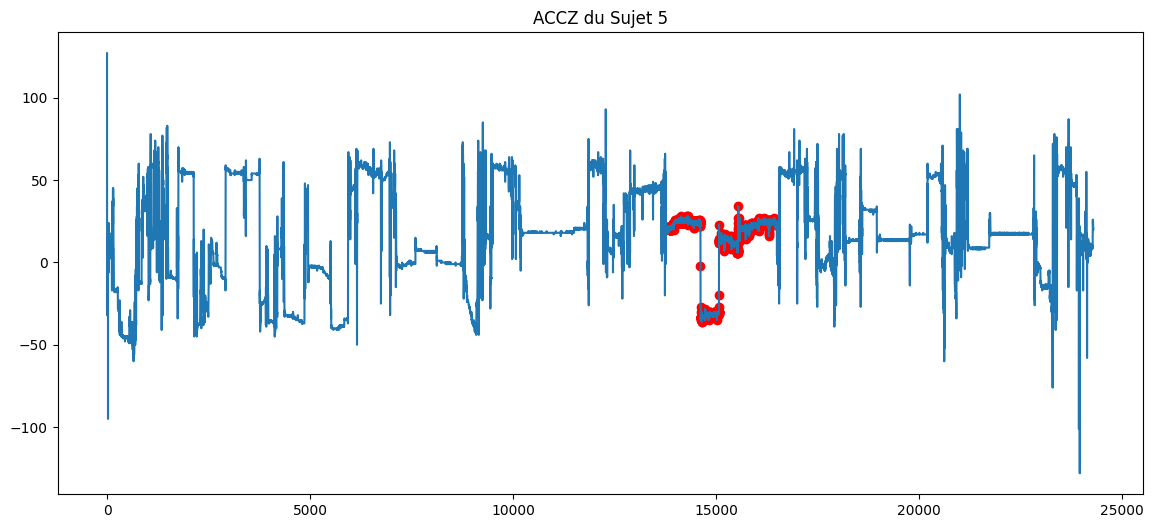

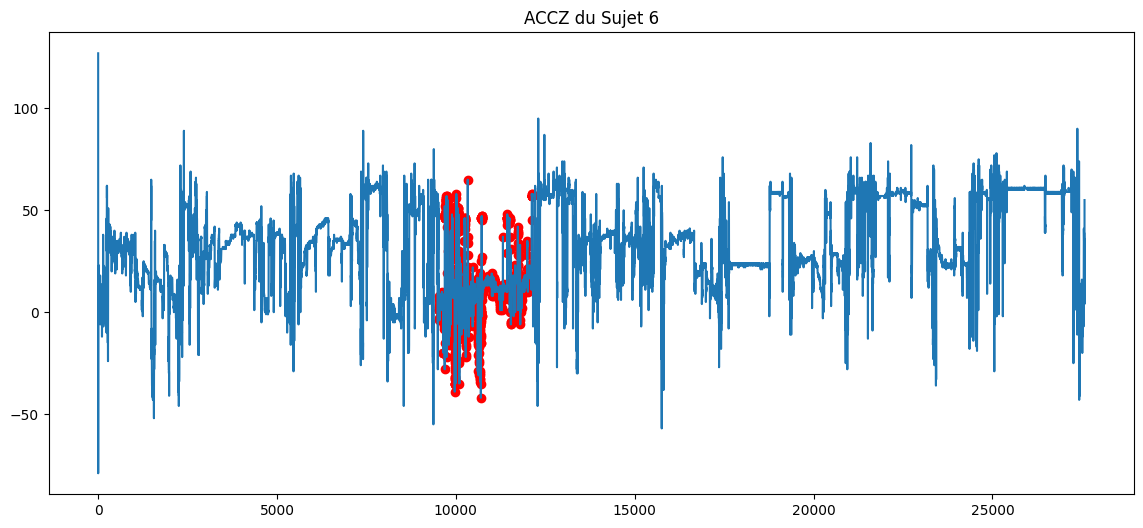

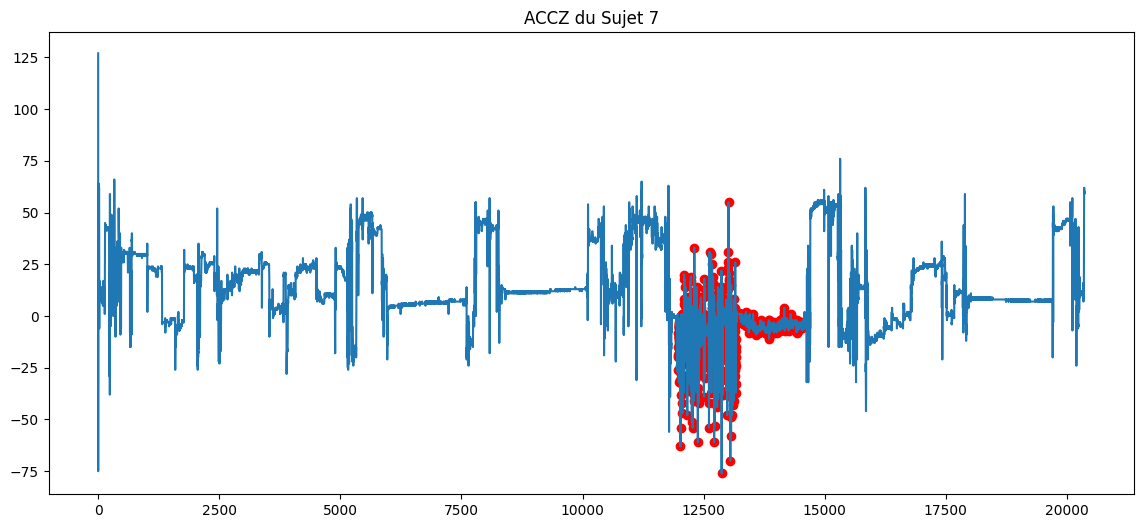

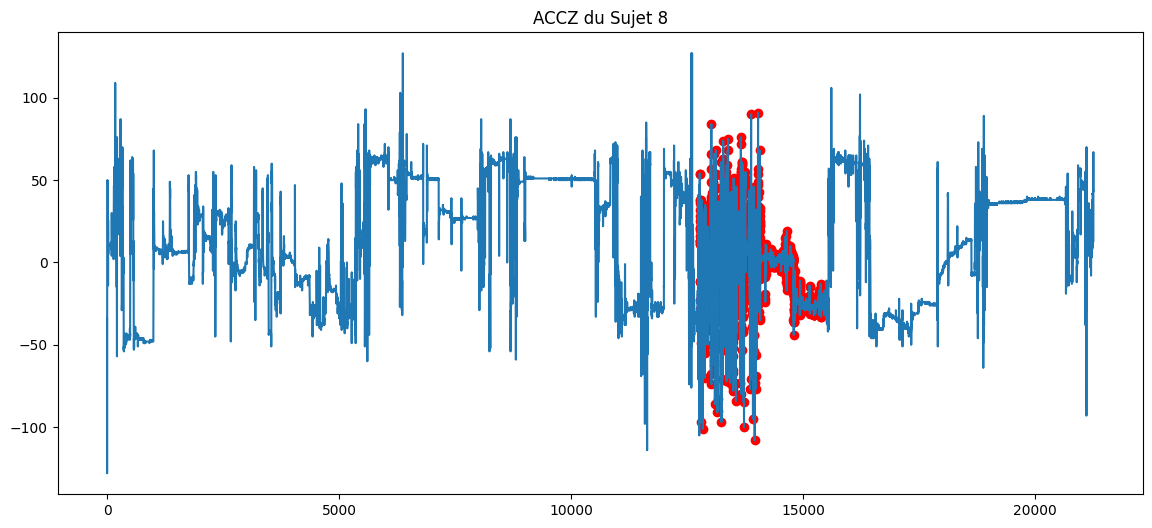

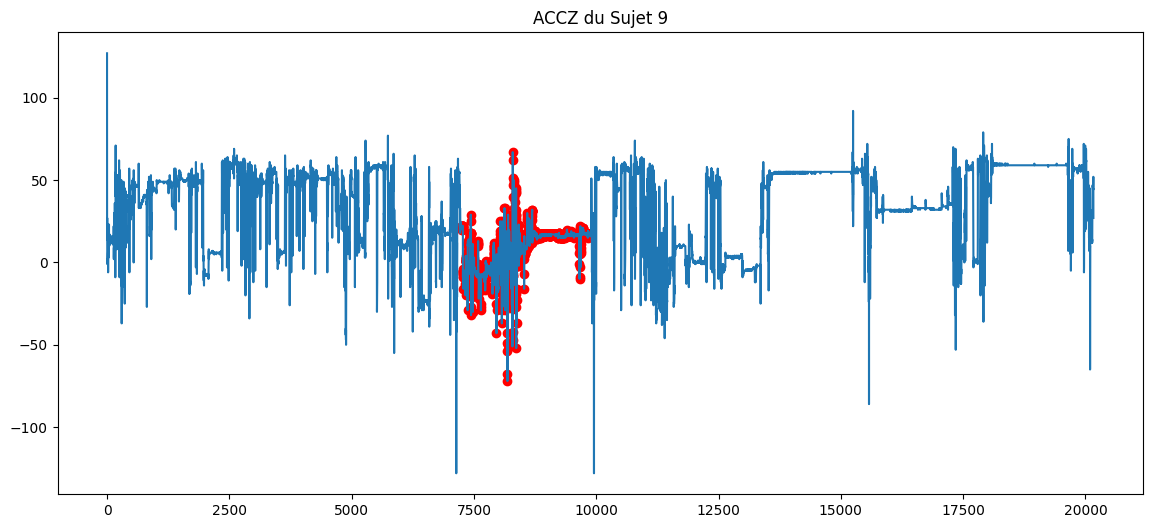

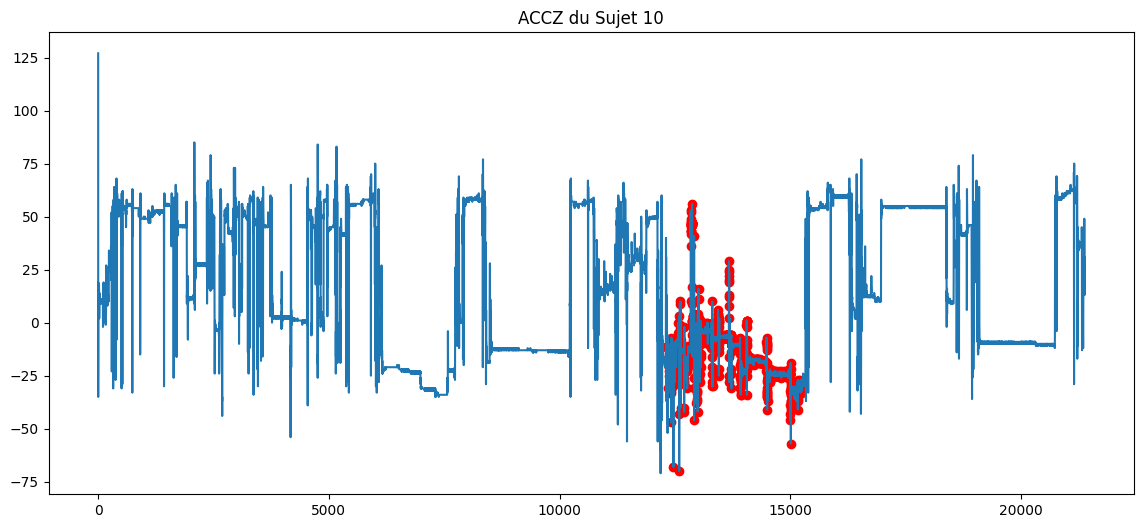

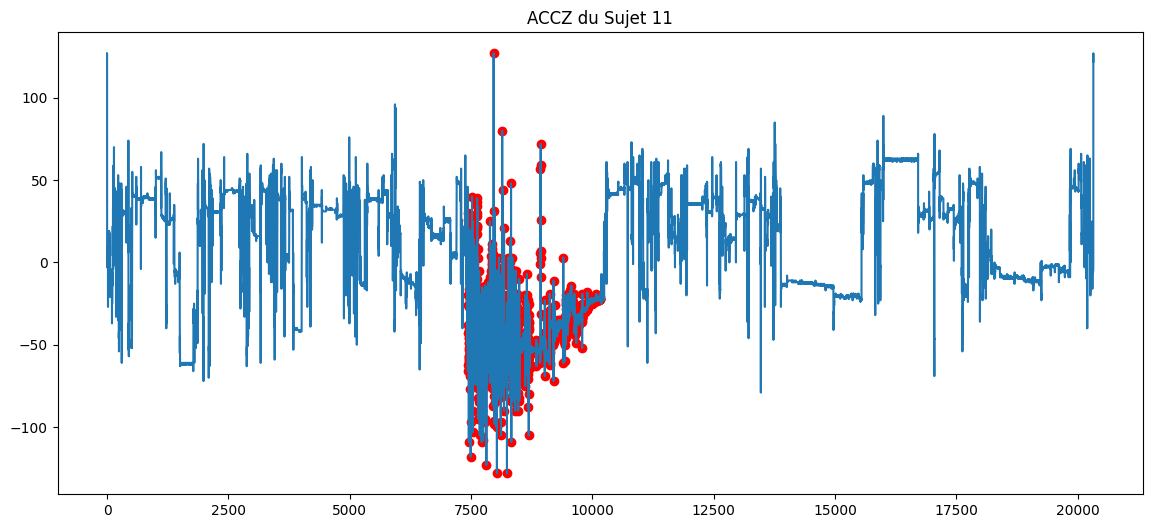

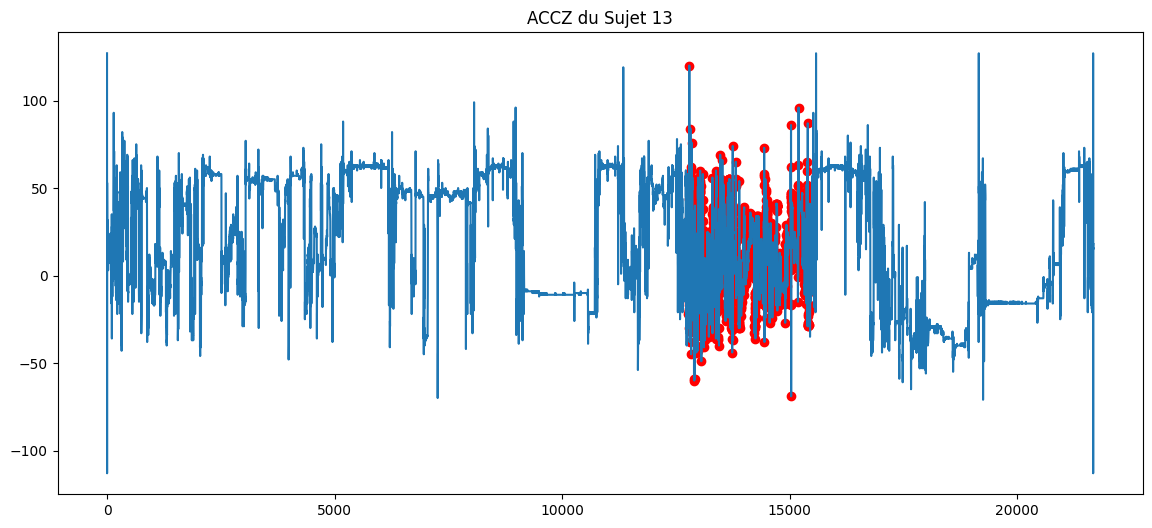

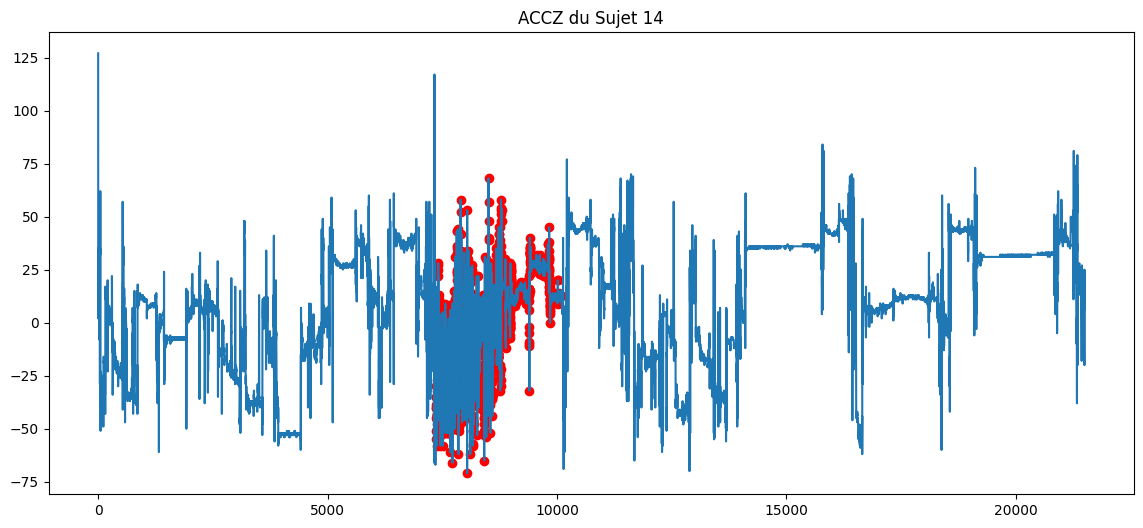

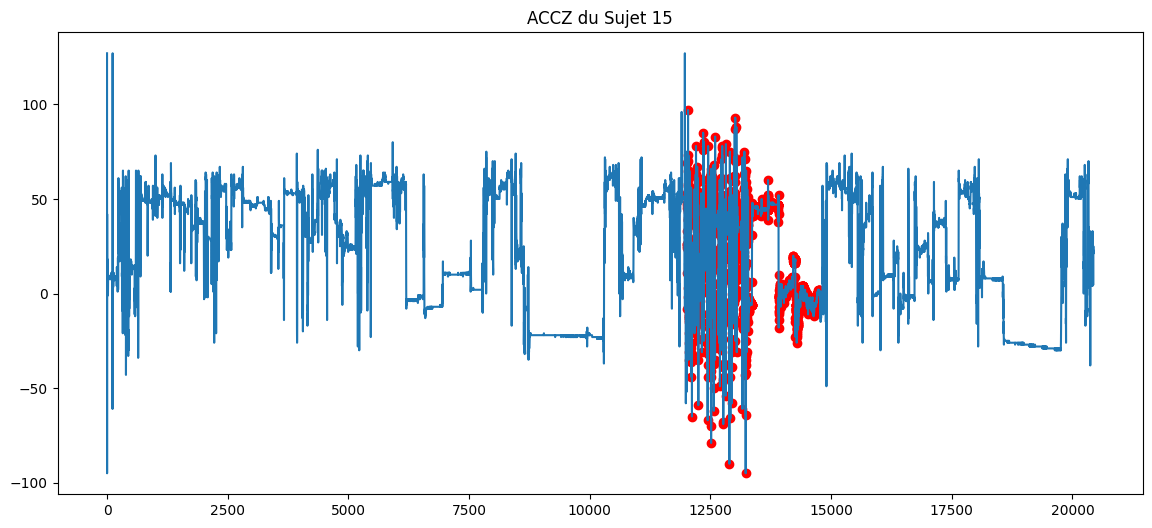

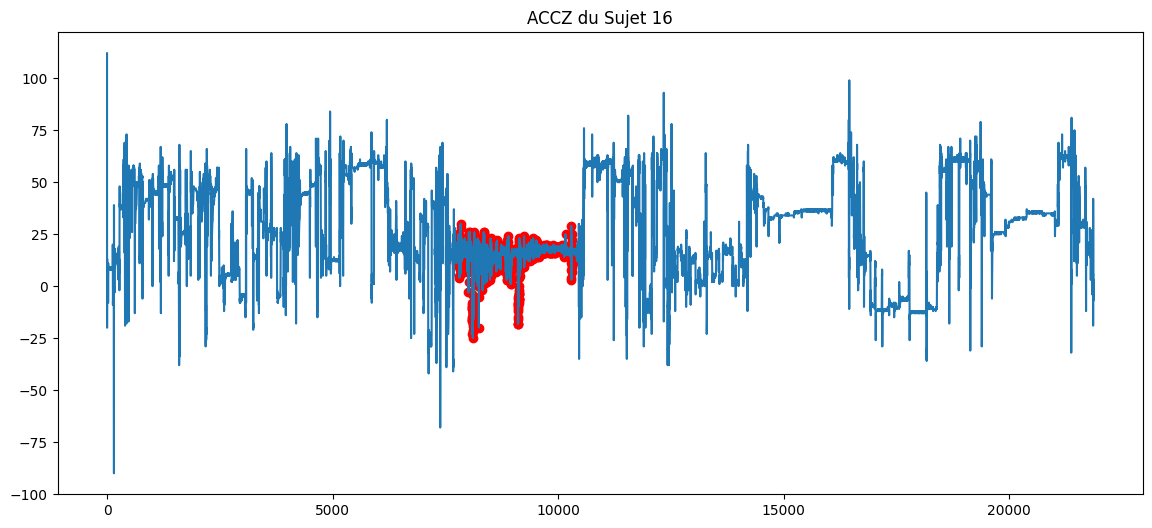

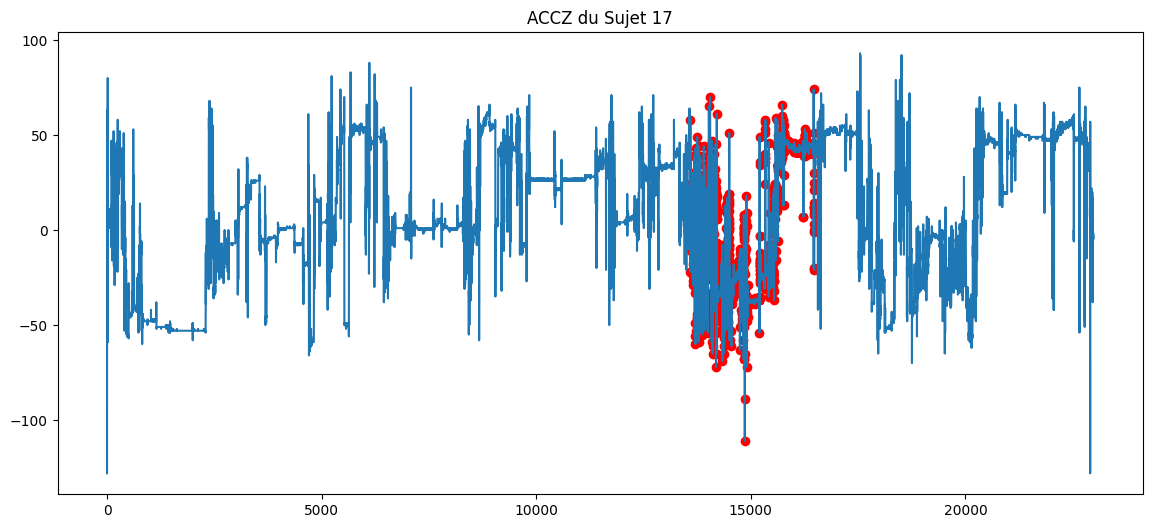

In [63]:
for key in DF_Wrist[2]:
    for i in range(2,18):
        if i != 12:
            N = np.arange(0,len(DF_Wrist[i]))

            plt.figure(figsize=(14, 6))
            plt.title(f'{key} du Sujet {i}')
            plt.plot(N, DF_Wrist[i][key].iloc[N])


            Y1_indices = DF_Wrist[i]['Label'][DF_Wrist[i]['Label']==2].index
            plt.scatter(Y1_indices, DF_Wrist[i][key].iloc[Y1_indices], color='red', marker='o', label='Vrai stress')

            plt.show()

In [115]:
# 25% avant le stress, 50% pendant le stress et 25% après le stress

for i in range(2, 18):
    if i != 12:
        df_indices = DF_Chest[i]['Label'].eq(2)
        first_index = df_indices.idxmax()
        last_index = df_indices.iloc[::-1].idxmax()
        DF_Chest[i] = DF_Chest[i].iloc[int(first_index - (last_index - first_index)/2) : int(last_index + (last_index - first_index)/2)]
        DF_Chest[i].reset_index(drop=True, inplace=True)
        DF_Chest[i].index = DF_Chest[i].index + 1

In [137]:
"""for i in range(2,18):
    if i != 12:
        L = [n for n in range(0,len(DF_Chest[i])-1)]
        random.shuffle(L)
        DF_Chest[i] = DF_Chest[i].iloc[L]"""

In [81]:
# Normalisation

"""for i in range(2, 18):
    if i != 12:
        cle_chest = list(DF_Chest[i].keys())
        for cle in cle_chest:
            DF_Chest[i][cle] = (DF_Chest[i][cle] - DF_Chest[i][cle].mean()) / DF_Chest[i][cle].std()"""

In [11]:
# On met tous les DF_Chest[i] à la même taille

"""l = len(DF_Chest[2])
for i in range(2,18):
    if i != 12:
        if len(DF_Chest[i]) < l:
            l = len(DF_Chest[i])
            s = i
print(l)
print(s)
for i in range(2,18):
    if i != 12:
            DF_Chest[i] = DF_Chest[i][len(DF_Chest[i]) - len(DF_Chest[s]): ]"""

3528700
9


In [31]:
# On garde une donnée sur deux (échantillonnage régulier)

for i in range(2,18):
    if i != 12:
        DF_Chest[i] = DF_Chest[i][::100]
        DF_Chest[i].reset_index(drop=True, inplace=True)
        DF_Chest[i].index = DF_Chest[i].index + 1

In [5]:
# Faire une moyenne glissante sur des intervalles réguliers

T = 2    # Taille intervalles

for i in range(2, 18):
    if i != 12:
        DF_Chest[i] = DF_Chest[i].rolling(window=T, min_periods=1).mean().iloc[::T]
        # Indiçage des données
        DF_Chest[i].reset_index(drop=True, inplace=True)
        DF_Chest[i].index = DF_Chest[i].index + 1

In [6]:
np.shape(DF_Chest[2])

(4165000, 9)

Sujet 2 :


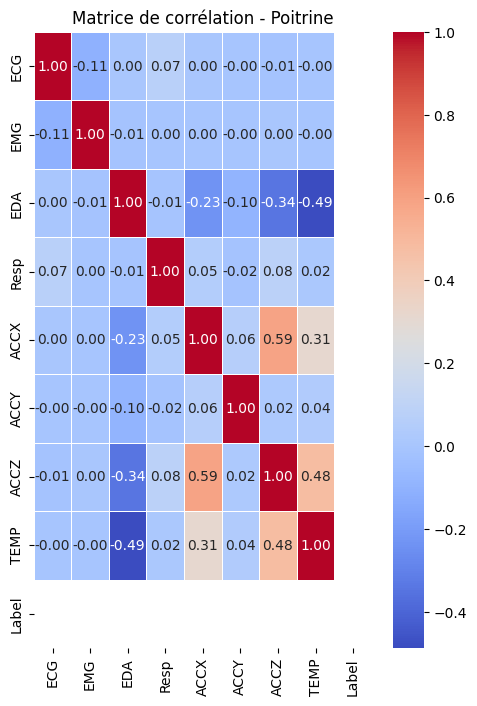

Sujet 3 :


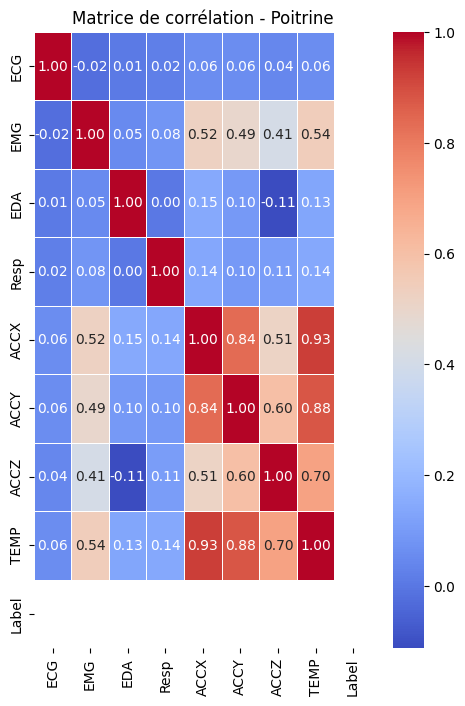

Sujet 4 :


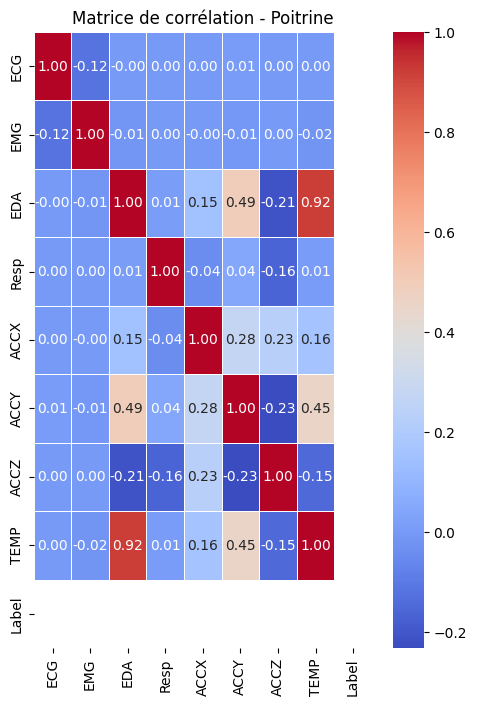

Sujet 5 :


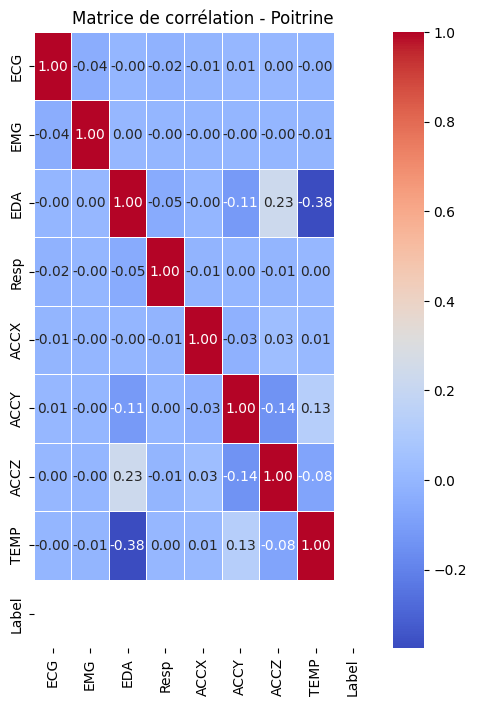

Sujet 6 :


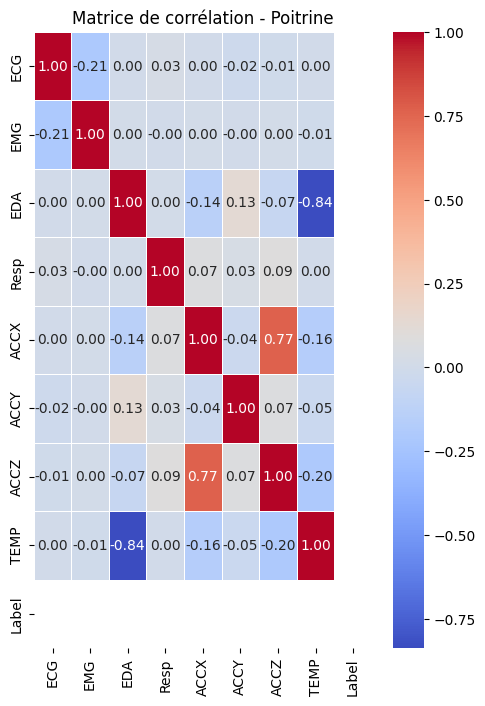

Sujet 7 :


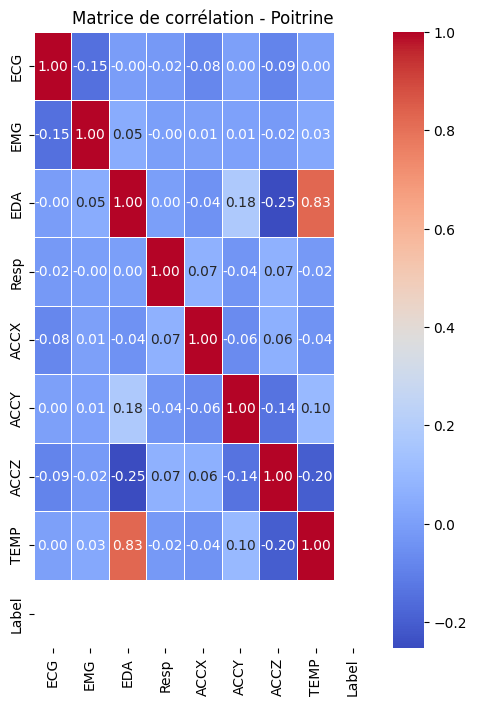

Sujet 8 :


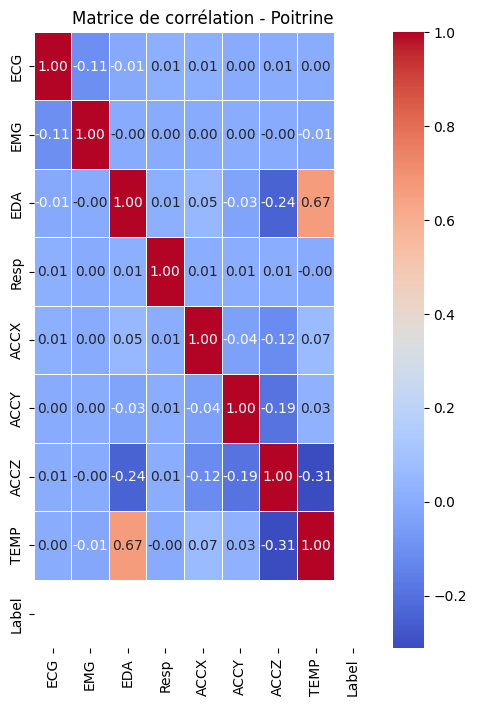

Sujet 9 :


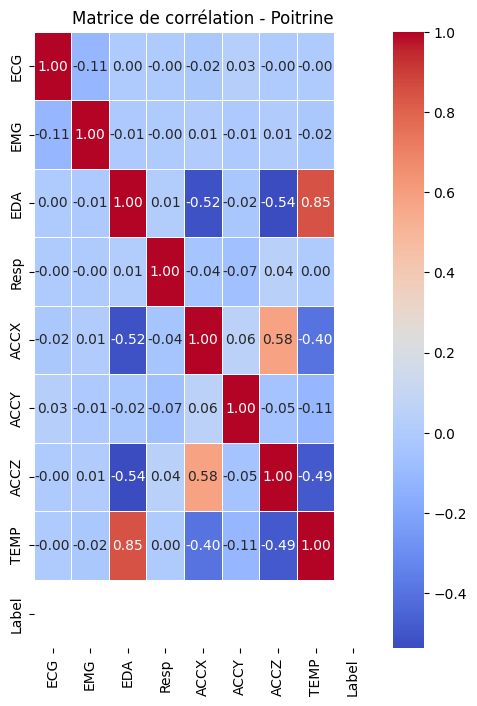

Sujet 10 :


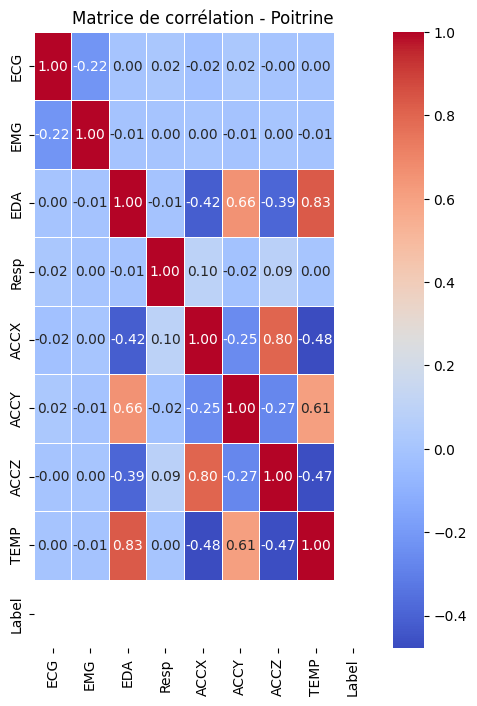

Sujet 11 :


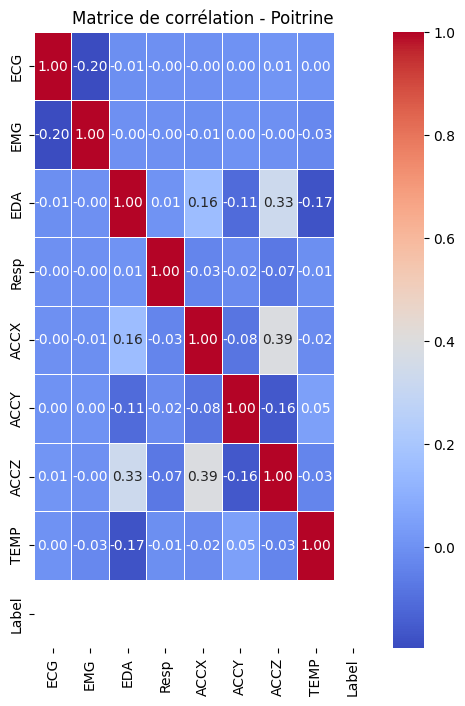

Sujet 13 :


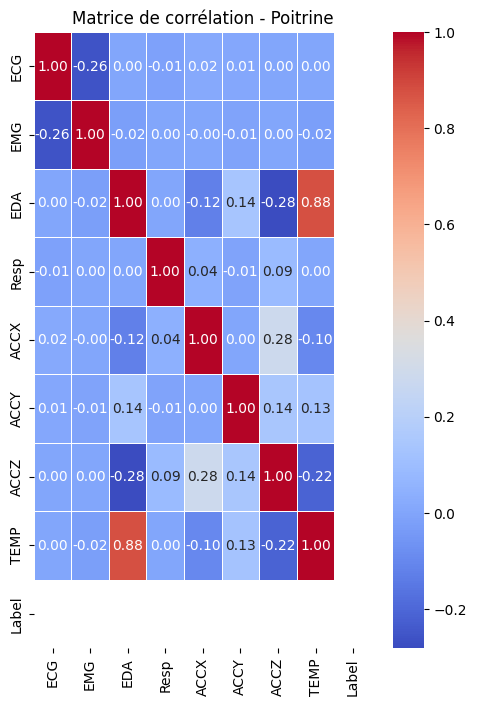

Sujet 14 :


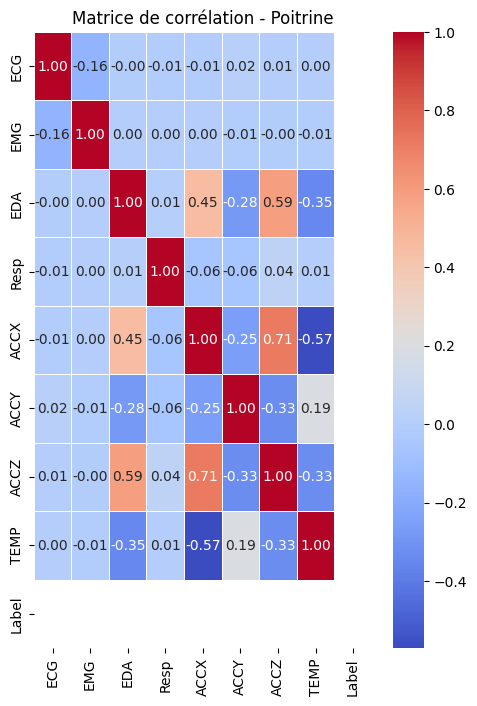

Sujet 15 :


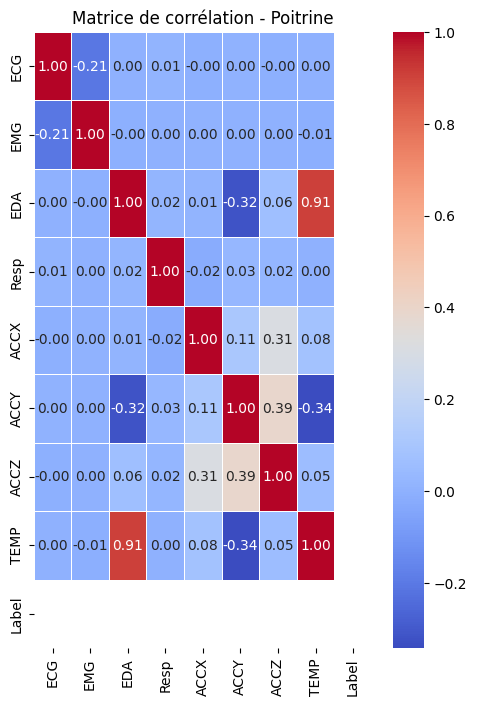

Sujet 16 :


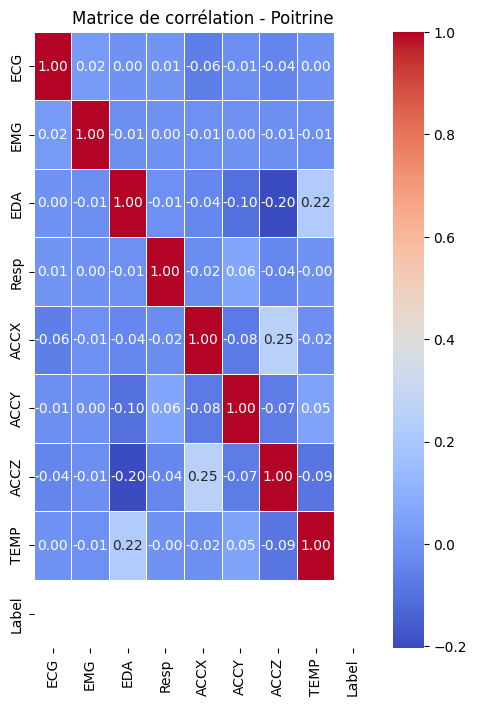

Sujet 17 :


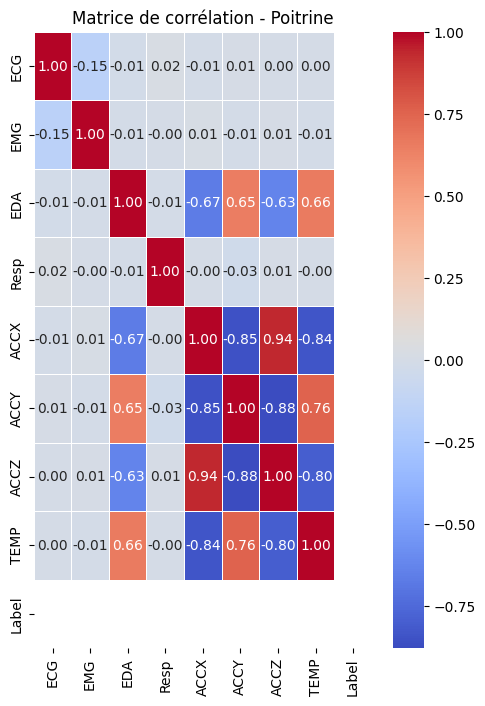

In [8]:
for i in range(2,18):
    if i != 12:
        print("Sujet",i,":")
        CorrelationChest(DF_Chest[i][DF_Chest[i]['Label']==2]) # Correlation sur le stress pour chaque sujet

Sujet 2 :


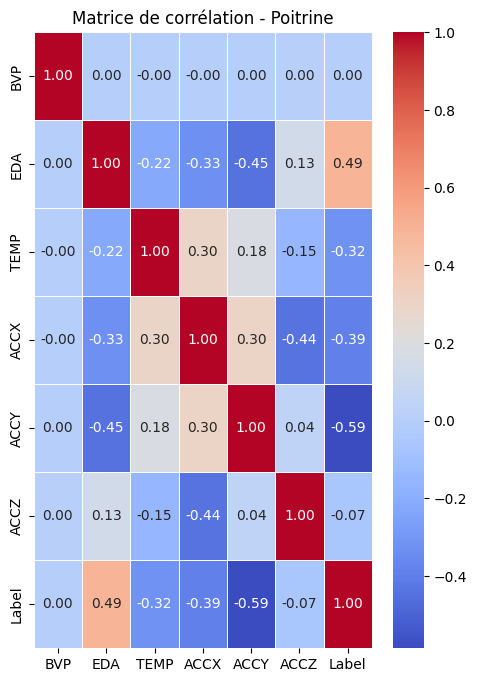

Sujet 3 :


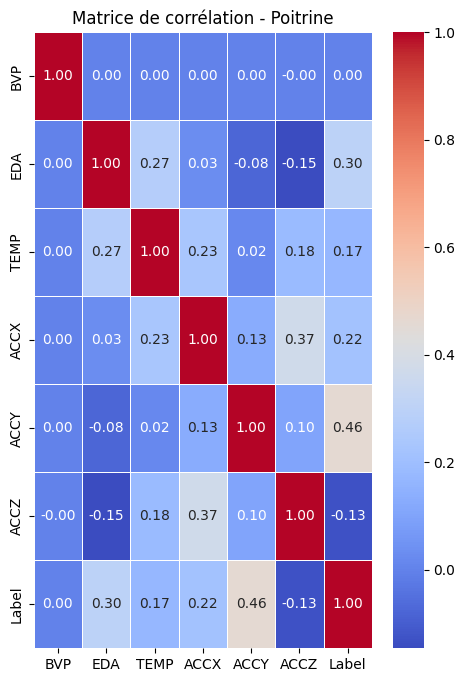

Sujet 4 :


In [50]:
for i in range(2,18):
    if i != 12:
        print("Sujet",i,":")
        CorrelationChest(DF_Wrist[i]) # Correlation sur le stress pour chaque sujet

In [24]:
# Dictionnaire commun Chest et Wrist

df_w = {i+17: v for i, v in DF_Wrist.items()}

df_wcomm = {}
for i in range(19,35):
    if i != 29:
        df_wcomm[i] = df_w[i][['EDA','TEMP','ACCX','ACCY','ACCZ','Label']]

df_ccomm = {}
for i in range(2,18):
    if i != 12:
        df_ccomm[i] = DF_Chest[i][['EDA','TEMP','ACCX','ACCY','ACCZ','Label']]

df_ccomm.update(df_wcomm)

DF_Commun = df_ccomm

In [27]:
DF_Commun.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34])

In [40]:
from sklearn.metrics import classification_report

def RandomForest(DF, n_estimators, SujetTest1, SujetTest2, SujetTest3):
    """
    # Définissez la liste des sujets que vous souhaitez utiliser pour l'entraînement
    sujets = [i for i in range(2, 18) if i != 12]
    random.shuffle(sujets)
    """

    sujets = [i for i in range(2, 18) if i != 12 if i != SujetTest1 if i != SujetTest2 if i != SujetTest3]
    sujets.append(SujetTest1)
    sujets.append(SujetTest2)
    sujets.append(SujetTest3)

    # Divisez les données en ensembles d'entraînement et de test
    I = int(len(sujets)*12/15)
    df_train = pd.concat([DF[i] for i in sujets[0:I]])
    df_test = pd.concat([DF[i] for i in sujets[I:len(sujets)]])

    # Créez les labels pour l'entraînement et le test
    y_train = (df_train['Label']).astype(int)
    y_test = (df_test['Label']).astype(int)

    # Séparez les features (X) pour l'entraînement et le test
    X_train = df_train.drop('Label', axis=1)
    X_test = df_test.drop('Label', axis=1)

    # Initialisez et entraînez le modèle RandomForest
    weight0 = (len(DF[SujetTest1])+len(DF[SujetTest2])+len(DF[SujetTest3]))/(len(DF[SujetTest1].loc[DF[SujetTest1]['Label']==2])+len(DF[SujetTest2].loc[DF[SujetTest2]['Label']==2])+len(DF[SujetTest3].loc[DF[SujetTest3]['Label']==2]))
    weight2 = (len(DF[SujetTest1])+len(DF[SujetTest2])+len(DF[SujetTest3]))/(len(DF[SujetTest1].loc[DF[SujetTest1]['Label']==0])+len(DF[SujetTest2].loc[DF[SujetTest2]['Label']==0])+len(DF[SujetTest3].loc[DF[SujetTest3]['Label']==0]))

    class_weights = {0: 1, 2: 1}
    model = RandomForestClassifier(n_estimators=n_estimators, class_weight=class_weights, random_state=42)
    model.fit(X_train, y_train)

    # Faites des prédictions sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Évaluez les performances du modèle
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)  # Obtiens le rapport de classification
    print("Sujets Train :", [sujets[i] for i in range(0,I)])
    print("Sujets Test :", [sujets[i] for i in range(I,len(sujets))])
    print(f"Précision du modèle : {accuracy}")
    print("Rapport de classification :")
    print(report)
    return y_test, y_pred, SujetTest1, SujetTest2, SujetTest3

In [ ]:
# Faire crossvalidation

# Essayer avec d'autres variables (par exemple : uniquement EDA et TEMP)

In [24]:
sujets = [i for i in range(2, 18) if i != 12]
random.shuffle(sujets)
print(sujets[:3])

[9, 13, 15]


In [30]:
DF_Chest[2].keys()

Index(['ECG', 'EMG', 'EDA', 'Resp', 'ACCX', 'ACCY', 'ACCZ', 'TEMP', 'Label'], dtype='object')

Sujets Train : [2, 3, 5, 6, 7, 8, 10, 11, 14, 15, 16, 17]
Sujets Test : [4, 13, 9]
Précision du modèle : 0.7593521624459069
Rapport de classification :
              precision    recall  f1-score   support

           0       0.89      0.84      0.86  10355100
           2       0.13      0.18      0.15   1360800

    accuracy                           0.76  11715900
   macro avg       0.51      0.51      0.50  11715900
weighted avg       0.80      0.76      0.78  11715900



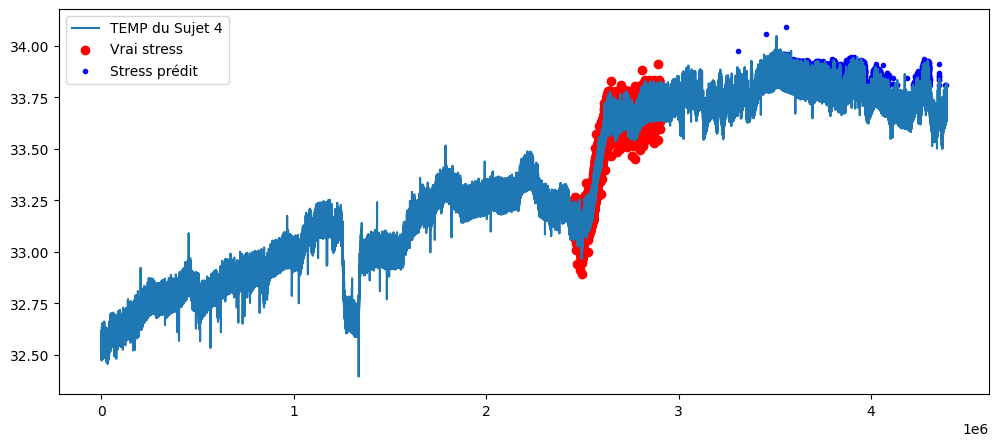

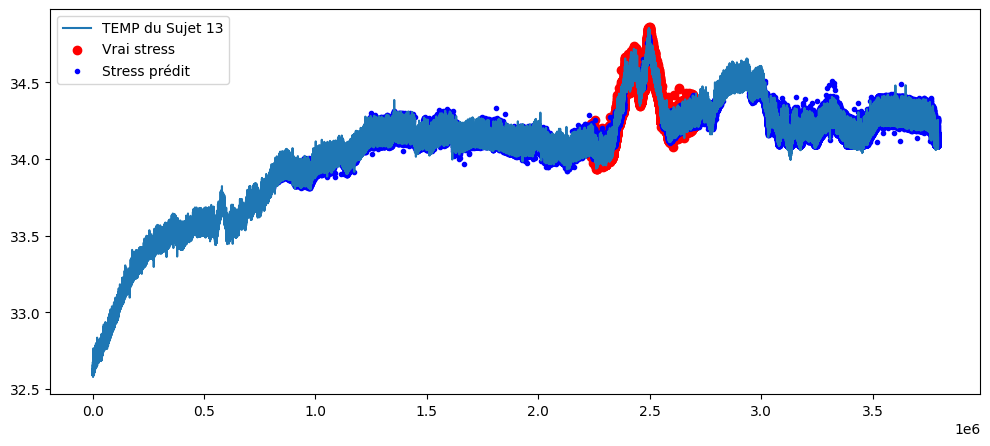

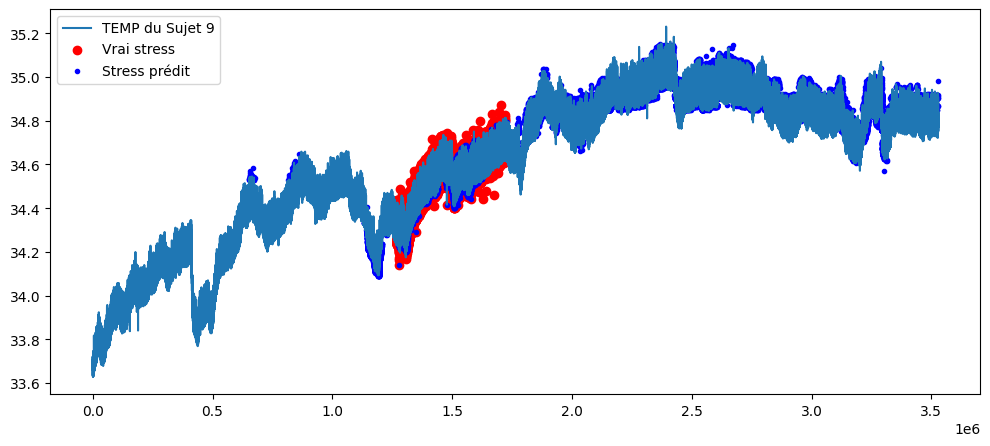

In [31]:
DF_Chest2 = {}
for i in range(2,18):
    if i != 12:
        DF_Chest2[i] = DF_Chest[i][['EDA','TEMP','Label']]

Y_TEST, Y_PRED, SujetTest1, SujetTest2, SujetTest3 = RandomForest(DF_Chest2, 70, 4, 13, 9)

Y_PRED1 = Y_PRED[: len(DF_Chest2[SujetTest1])]
Y_PRED2 = Y_PRED[len(DF_Chest2[SujetTest1]) : len(DF_Chest2[SujetTest1]) + len(DF_Chest2[SujetTest2])]
Y_PRED3 = Y_PRED[len(DF_Chest2[SujetTest1]) + len(DF_Chest2[SujetTest2]) :]

Y_TEST1 = Y_TEST[: len(DF_Chest2[SujetTest1])]
Y_TEST2 = Y_TEST[len(DF_Chest2[SujetTest1]) : len(DF_Chest2[SujetTest1]) + len(DF_Chest2[SujetTest2])]
Y_TEST3 = Y_TEST[len(DF_Chest2[SujetTest1]) + len(DF_Chest2[SujetTest2]) :]

pred = [Y_PRED1, Y_PRED2, Y_PRED3]
test = [Y_TEST1, Y_TEST2, Y_TEST3]
sujettest = [SujetTest1, SujetTest2, SujetTest3]

for i in [0,1,2]:
    N = np.arange(0, len(DF_Chest2[sujettest[i]]), 10)

    plt.figure(figsize=(12, 5))

    plt.plot(N, DF_Chest2[sujettest[i]]['TEMP'].iloc[N], label=f'TEMP du Sujet {sujettest[i]}')


    Y1_indices = test[i][test[i]==2].index
    plt.scatter(Y1_indices, DF_Chest2[sujettest[i]]['TEMP'].iloc[Y1_indices], color='red', marker='o', label='Vrai stress')


    Y2_indices = np.where(pred[i] == 2)[0]
    plt.scatter(Y2_indices, DF_Chest2[sujettest[i]]['TEMP'].iloc[Y2_indices], color='blue', marker='.', label='Stress prédit')

    plt.legend()
    plt.show()

Sujets Train : [6, 4, 17, 5, 10, 11, 14, 7, 13, 3, 2, 9, 16, 8]
Sujets Test : [15]
Précision du modèle : 0.8900643122780527


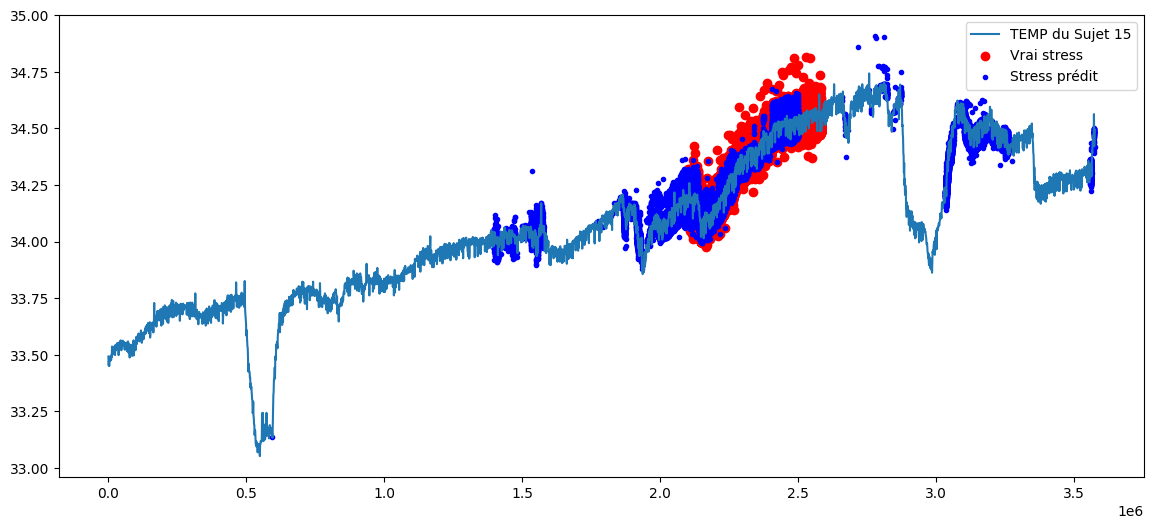

In [7]:
Y_TEST, Y_PRED, Sujet = RandomForest(DF_Chest, 70)

N = np.arange(0,len(DF_Chest[Sujet]),1000)

plt.figure(figsize=(14, 6))

plt.plot(N, DF_Chest[Sujet]['TEMP'].iloc[N], label=f'TEMP du Sujet {Sujet}')


Y1_indices = Y_TEST[Y_TEST==2].index
plt.scatter(Y1_indices, DF_Chest[Sujet]['TEMP'].iloc[Y1_indices], color='red', marker='o', label='Vrai stress')


Y2_indices = np.where(Y_PRED == 2)[0]
plt.scatter(Y2_indices, DF_Chest[Sujet]['TEMP'].iloc[Y2_indices], color='blue', marker='.', label='Stress prédit')

plt.legend()
plt.show()

Sujets Train : [3, 11, 7, 9, 13, 8, 10, 15, 17, 2, 4, 5, 14, 6]
Sujets Test : [16]
Précision du modèle : 0.8782264387643093


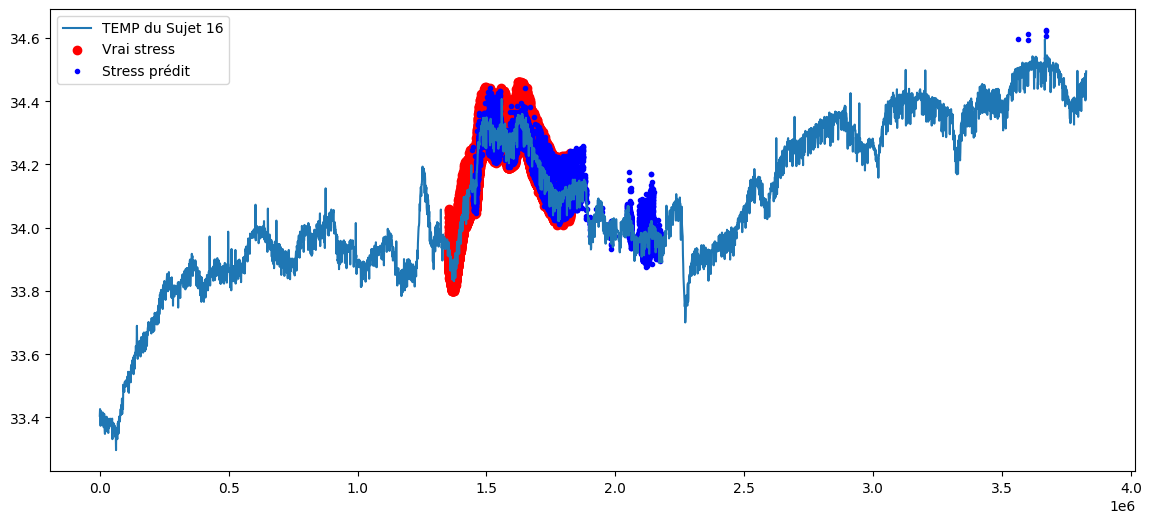

In [114]:
Y_TEST, Y_PRED, Sujet = RandomForest(DF_Chest, 50)

N = np.arange(0,len(DF_Chest[Sujet]),1000)

plt.figure(figsize=(14, 6))

plt.plot(N, DF_Chest[Sujet]['TEMP'].iloc[N], label=f'TEMP du Sujet {Sujet}')


Y1_indices = Y_TEST[Y_TEST==2].index
plt.scatter(Y1_indices, DF_Chest[Sujet]['TEMP'].iloc[Y1_indices], color='red', marker='o', label='Vrai stress')


Y2_indices = np.where(Y_PRED == 2)[0]
plt.scatter(Y2_indices, DF_Chest[Sujet]['TEMP'].iloc[Y2_indices], color='blue', marker='.', label='Stress prédit')

plt.legend()
plt.show()

In [20]:
DF_Wrist2[2].loc[DF_Wrist2[2]['Label']==2]

EDA   TEMP  Label
9096   0.790848  34.07      2
9097   0.795973  34.07      2
9098   0.801099  34.07      2
9099   0.807505  34.07      2
9100   0.790848  34.07      2
...         ...    ...    ...
11551  1.209913  32.61      2
11552  1.206069  32.61      2
11553  1.206069  32.59      2
11554  1.199662  32.59      2
11555  1.191974  32.59      2

[2460 rows x 3 columns]

In [42]:
def create_neural_network(input_size):
    model = nn.Sequential(
        nn.Linear(input_size, 64),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(32, 1),
        nn.Sigmoid()
    )
    return model

def train_neural_network(model, train_loader, criterion, optimizer, num_epochs, class_weights, test_loader=None):
    train_losses = []  # Pour enregistrer la perte à chaque époque

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0  # Perte totale pour cette époque
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            
            if class_weights:
                # Calculez la pondération de la perte en fonction des classes
                if class_weights == 'auto':
                    class_weights_tensor = torch.tensor(class_weights.compute_class_weight('balanced', np.unique(labels.numpy()), labels.numpy()), dtype=torch.float32)
                else:
                    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
                loss = criterion(outputs, labels.view(-1, 1)) * class_weights_tensor[labels.long()]
            else:
                loss = criterion(outputs, labels.view(-1, 1))
                
            loss = torch.mean(loss)  # Prenez la moyenne de la perte sur le lot
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()  # Accumulez la perte à chaque itération

        # Calculez la perte moyenne pour cette époque
        average_loss = epoch_loss / len(train_loader)
        train_losses.append(average_loss)  # Enregistrez la perte moyenne

        # Affichez la perte moyenne à la fin de chaque époque
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')

    # Tracé de la perte au fil des époques
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoques')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def evaluate_neural_network(model, test_loader):
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            predictions = model(inputs)
            all_predictions.extend(predictions.numpy())
    
    binary_predictions = (np.array(all_predictions) > 0.5).astype(float)
    return binary_predictions

def NeuralNetwork(DF, num_epochs, SujetTest1, SujetTest2, SujetTest3):

    sujets = [i for i in range(2, 18) if i != 12 if i != SujetTest1 if i != SujetTest2 if i != SujetTest3]
    sujets.append(SujetTest1)
    sujets.append(SujetTest2)
    sujets.append(SujetTest3)

    # Divisez les données en ensembles d'entraînement et de test
    I = int(len(sujets)*12/15)
    df_train = pd.concat([DF[i] for i in sujets[0:I]])
    df_test = pd.concat([DF[i] for i in sujets[I:len(sujets)]])

    X_train = df_train.drop('Label', axis=1).values
    y_train = df_train['Label'].values.astype(np.float32)

    X_test = df_test.drop('Label', axis=1).values
    y_test = df_test['Label'].values.astype(np.float32)

    y_train = (df_train['Label'] == 2).astype(int).values
    y_test = (df_test['Label'] == 2).astype(int).values

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    input_size = X_train.shape[1]
    model = create_neural_network(input_size)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    weight0 = (len(DF[SujetTest1])+len(DF[SujetTest2])+len(DF[SujetTest3]))/(len(DF[SujetTest1].loc[DF[SujetTest1]['Label']==2])+len(DF[SujetTest2].loc[DF[SujetTest2]['Label']==2])+len(DF[SujetTest3].loc[DF[SujetTest3]['Label']==2]))
    weight2 = (len(DF[SujetTest1])+len(DF[SujetTest2])+len(DF[SujetTest3]))/(len(DF[SujetTest1].loc[DF[SujetTest1]['Label']==0])+len(DF[SujetTest2].loc[DF[SujetTest2]['Label']==0])+len(DF[SujetTest3].loc[DF[SujetTest3]['Label']==0]))

    train_neural_network(model, train_loader, criterion, optimizer, num_epochs, [weight0, weight2], test_loader)

    y_pred = evaluate_neural_network(model, test_loader)

    # Évaluez les performances du modèle
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)  # Obtiens le rapport de classification
    print("Sujets Train :", [sujets[i] for i in range(0,I)])
    print("Sujets Test :", [sujets[i] for i in range(I,len(sujets))])
    print(f"Précision du modèle : {accuracy}")
    print("Rapport de classification :")
    print(report)
    return y_test, y_pred, SujetTest1, SujetTest2, SujetTest3

In [44]:
Y_TEST, Y_PRED, SujetTest1, SujetTest2, SujetTest3 = NeuralNetwork(DF_Wrist, 15, 4, 13, 10)

Y_PRED1 = Y_PRED[: len(DF_Wrist[SujetTest1])]
Y_PRED2 = Y_PRED[len(DF_Wrist[SujetTest1]) : len(DF_Wrist[SujetTest1]) + len(DF_Wrist[SujetTest2])]
Y_PRED3 = Y_PRED[len(DF_Wrist[SujetTest1]) + len(DF_Wrist[SujetTest2]) :]

Y_TEST1 = Y_TEST[: len(DF_Wrist[SujetTest1])]
Y_TEST2 = Y_TEST[len(DF_Wrist[SujetTest1]) : len(DF_Wrist[SujetTest1]) + len(DF_Wrist[SujetTest2])]
Y_TEST3 = Y_TEST[len(DF_Wrist[SujetTest1]) + len(DF_Wrist[SujetTest2]) :]

pred = [Y_PRED1, Y_PRED2, Y_PRED3]
test = [Y_TEST1, Y_TEST2, Y_TEST3]
sujettest = [SujetTest1, SujetTest2, SujetTest3]

for i in [0,1,2]:
    N = np.arange(0, len(DF_Wrist[sujettest[i]]), 100)

    plt.figure(figsize=(12, 5))

    plt.plot(N, DF_Wrist[sujettest[i]]['TEMP'].iloc[N], label=f'TEMP du Sujet {sujettest[i]}')


    Y1_indices = np.where(test[i] == 1)[0]
    plt.scatter(Y1_indices, DF_Wrist[sujettest[i]]['TEMP'].iloc[Y1_indices], color='red', marker='o', label='Vrai stress')


    Y2_indices = np.where(pred[i] == 1)[0]
    plt.scatter(Y2_indices, DF_Wrist[sujettest[i]]['TEMP'].iloc[Y2_indices], color='blue', marker='.', label='Stress prédit')

    plt.legend()
    plt.show()

KeyboardInterrupt: 

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import random

def RegressionLogistique(DF, SujetTest1, SujetTest2, SujetTest3):

    sujets = [i for i in range(2, 18) if i != 12 if i != SujetTest1 if i != SujetTest2 if i != SujetTest3]
    sujets.append(SujetTest1)
    sujets.append(SujetTest2)
    sujets.append(SujetTest3)

    # Divisez les données en ensembles d'entraînement et de test
    I = int(len(sujets)*12/15)
    df_train = pd.concat([DF[i] for i in sujets[0:I]])
    df_test = pd.concat([DF[i] for i in sujets[I:len(sujets)]])

    # Créez les labels pour l'entraînement et le test
    y_train = (df_train['Label']).astype(int)
    y_test = (df_test['Label']).astype(int)

    # Séparez les features (X) pour l'entraînement et le test
    X_train = df_train.drop('Label', axis=1)
    X_test = df_test.drop('Label', axis=1)

    # Initialisez et entraînez le modèle de régression logistique
    weight0 = (len(DF[SujetTest1])+len(DF[SujetTest2])+len(DF[SujetTest3]))/(len(DF[SujetTest1].loc[DF[SujetTest1]['Label']==2])+len(DF[SujetTest2].loc[DF[SujetTest2]['Label']==2])+len(DF[SujetTest3].loc[DF[SujetTest3]['Label']==2]))
    weight2 = (len(DF[SujetTest1])+len(DF[SujetTest2])+len(DF[SujetTest3]))/(len(DF[SujetTest1].loc[DF[SujetTest1]['Label']==0])+len(DF[SujetTest2].loc[DF[SujetTest2]['Label']==0])+len(DF[SujetTest3].loc[DF[SujetTest3]['Label']==0]))
    class_weights = {0: weight0, 2: weight2}
    model = LogisticRegression(class_weight=class_weights, random_state=42)
    model.fit(X_train, y_train)

    # Faites des prédictions sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Évaluez les performances du modèle
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)  # Obtiens le rapport de classification
    print("Sujets Train :", [sujets[i] for i in range(0,I)])
    print("Sujets Test :", [sujets[i] for i in range(I,len(sujets))])
    print(f"Précision du modèle : {accuracy}")
    print("Rapport de classification :")
    print(report)
    return y_test, y_pred, SujetTest1, SujetTest2, SujetTest3

Sujets Train : [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 17]
Sujets Test : [15, 16, 13]
Précision du modèle : 0.9082945563345688
Rapport de classification :
              precision    recall  f1-score   support

           0       0.91      1.00      0.95   9780399
           2       0.93      0.30      0.45   1416101

    accuracy                           0.91  11196500
   macro avg       0.92      0.65      0.70  11196500
weighted avg       0.91      0.91      0.89  11196500



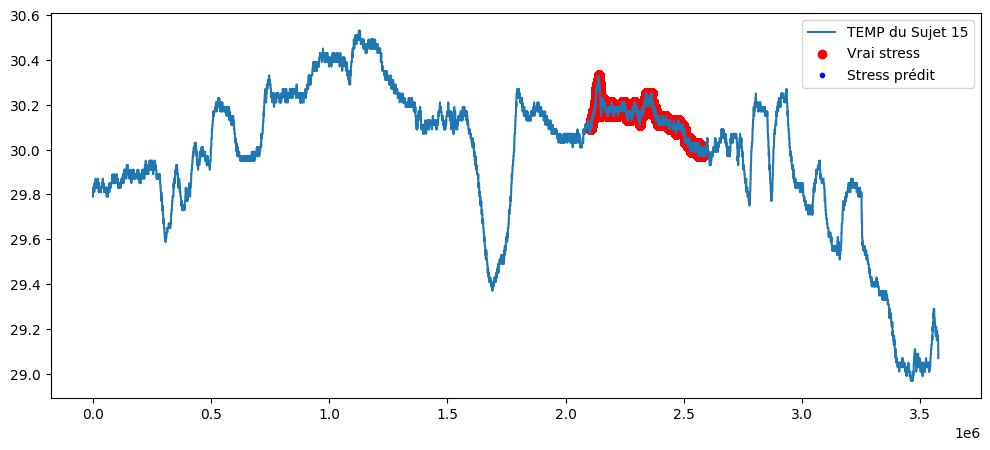

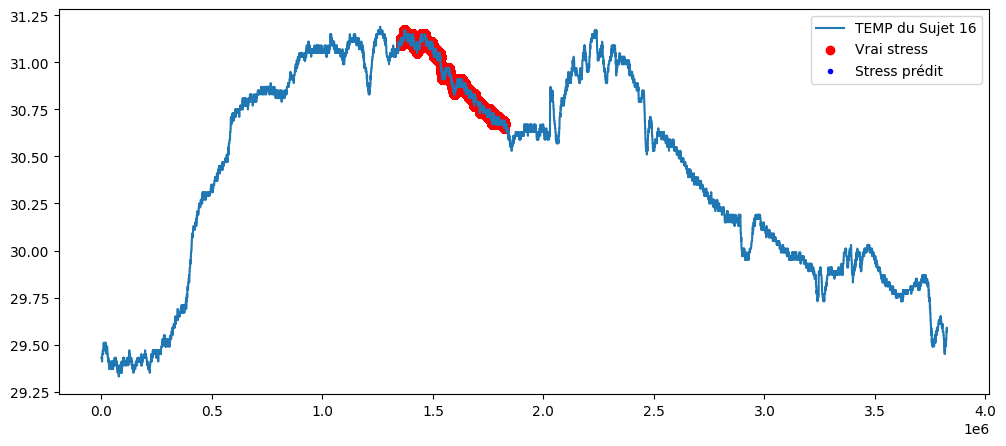

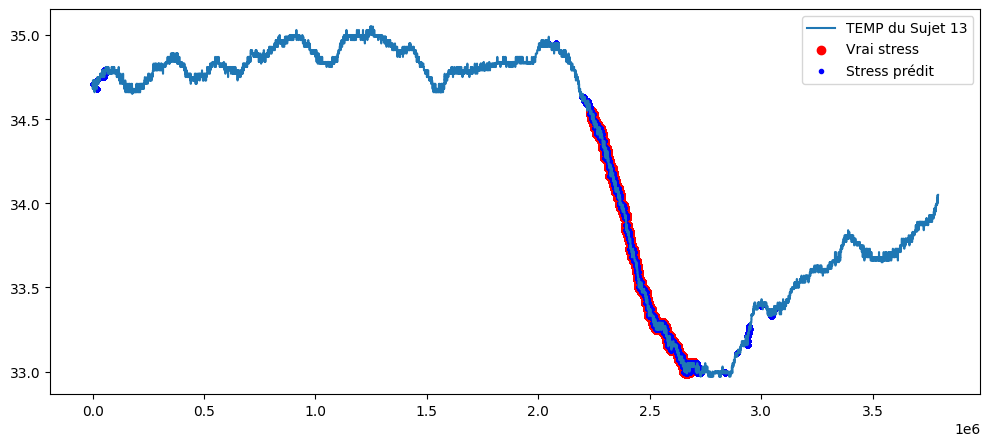

In [47]:
Y_TEST, Y_PRED, SujetTest1, SujetTest2, SujetTest3 = RegressionLogistique(DF_Wrist, 15, 16, 13)

Y_PRED1 = Y_PRED[: len(DF_Wrist[SujetTest1])]
Y_PRED2 = Y_PRED[len(DF_Wrist[SujetTest1]) : len(DF_Wrist[SujetTest1]) + len(DF_Wrist[SujetTest2])]
Y_PRED3 = Y_PRED[len(DF_Wrist[SujetTest1]) + len(DF_Wrist[SujetTest2]) :]

Y_TEST1 = Y_TEST[: len(DF_Wrist[SujetTest1])]
Y_TEST2 = Y_TEST[len(DF_Wrist[SujetTest1]) : len(DF_Wrist[SujetTest1]) + len(DF_Wrist[SujetTest2])]
Y_TEST3 = Y_TEST[len(DF_Wrist[SujetTest1]) + len(DF_Wrist[SujetTest2]) :]

pred = [Y_PRED1, Y_PRED2, Y_PRED3]
test = [Y_TEST1, Y_TEST2, Y_TEST3]
sujettest = [SujetTest1, SujetTest2, SujetTest3]

for i in [0,1,2]:
    N = np.arange(0, len(DF_Wrist[sujettest[i]]), 100)

    plt.figure(figsize=(12, 5))

    plt.plot(N, DF_Wrist[sujettest[i]]['TEMP'].iloc[N], label=f'TEMP du Sujet {sujettest[i]}')


    Y1_indices = test[i][test[i]==2].index
    plt.scatter(Y1_indices, DF_Wrist[sujettest[i]]['TEMP'].iloc[Y1_indices], color='red', marker='o', label='Vrai stress')


    Y2_indices = np.where(pred[i] == 2)[0]
    plt.scatter(Y2_indices, DF_Wrist[sujettest[i]]['TEMP'].iloc[Y2_indices], color='blue', marker='.', label='Stress prédit')

    plt.legend()
    plt.show()

In [103]:
sujets = [i for i in range(2, 18) if i != 12]
random.shuffle(sujets)
for i in range(0, 13,3):
        print(sujets[i:i+3])

[11, 3, 13]
[2, 5, 16]
[6, 15, 17]
[4, 9, 14]
[8, 10, 7]


In [16]:
Y_TEST, Y_PRED, SujetTest1, SujetTest2, SujetTest3 = NeuralNetwork(DF_Wrist, 15, 4, 3, 10)

Y_PRED1 = Y_PRED[: len(DF_Wrist[SujetTest1])]
Y_PRED2 = Y_PRED[len(DF_Wrist[SujetTest1]) : len(DF_Wrist[SujetTest1]) + len(DF_Wrist[SujetTest2])]
Y_PRED3 = Y_PRED[len(DF_Wrist[SujetTest1]) + len(DF_Wrist[SujetTest2]) :]

Y_TEST1 = Y_TEST[: len(DF_Wrist[SujetTest1])]
Y_TEST2 = Y_TEST[len(DF_Wrist[SujetTest1]) : len(DF_Wrist[SujetTest1]) + len(DF_Wrist[SujetTest2])]
Y_TEST3 = Y_TEST[len(DF_Wrist[SujetTest1]) + len(DF_Wrist[SujetTest2]) :]

pred = [Y_PRED1, Y_PRED2, Y_PRED3]
test = [Y_TEST1, Y_TEST2, Y_TEST3]
sujettest = [SujetTest1, SujetTest2, SujetTest3]

for i in [0,1,2]:
    N = np.arange(0, len(DF_Wrist[sujettest[i]]), 100)

    plt.figure(figsize=(12, 5))

    plt.plot(N, DF_Wrist[sujettest[i]]['TEMP'].iloc[N], label=f'TEMP du Sujet {sujettest[i]}')


    Y1_indices = np.where(test[i] == 1)[0]
    plt.scatter(Y1_indices, DF_Wrist[sujettest[i]]['TEMP'].iloc[Y1_indices], color='red', marker='o', label='Vrai stress')


    Y2_indices = np.where(pred[i] == 1)[0]
    plt.scatter(Y2_indices, DF_Wrist[sujettest[i]]['TEMP'].iloc[Y2_indices], color='blue', marker='.', label='Stress prédit')

    plt.legend()
    plt.show()

NameError: name 'NeuralNetwork' is not defined

In [ ]:
Y_TEST, Y_PRED, SujetTest1, SujetTest2, SujetTest3 = RandomForest(DF_Chest, 70, 4, 13, 9)

Y_PRED1 = Y_PRED[: len(DF_Chest[SujetTest1])]
Y_PRED2 = Y_PRED[len(DF_Chest[SujetTest1]) : len(DF_Chest[SujetTest1]) + len(DF_Chest[SujetTest2])]
Y_PRED3 = Y_PRED[len(DF_Chest[SujetTest1]) + len(DF_Chest[SujetTest2]) :]

Y_TEST1 = Y_TEST[: len(DF_Chest[SujetTest1])]
Y_TEST2 = Y_TEST[len(DF_Chest[SujetTest1]) : len(DF_Chest[SujetTest1]) + len(DF_Chest[SujetTest2])]
Y_TEST3 = Y_TEST[len(DF_Chest[SujetTest1]) + len(DF_Chest[SujetTest2]) :]

pred = [Y_PRED1, Y_PRED2, Y_PRED3]
test = [Y_TEST1, Y_TEST2, Y_TEST3]
sujettest = [SujetTest1, SujetTest2, SujetTest3]

for i in [0,1,2]:
    N = np.arange(0, len(DF_Chest[sujettest[i]]), 10)

    plt.figure(figsize=(12, 5))

    plt.plot(N, DF_Chest[sujettest[i]]['TEMP'].iloc[N], label=f'TEMP du Sujet {sujettest[i]}')


    Y1_indices = test[i][test[i]==2].index
    plt.scatter(Y1_indices, DF_Chest[sujettest[i]]['TEMP'].iloc[Y1_indices], color='red', marker='o', label='Vrai stress')


    Y2_indices = np.where(pred[i] == 2)[0]
    plt.scatter(Y2_indices, DF_Chest[sujettest[i]]['TEMP'].iloc[Y2_indices], color='blue', marker='.', label='Stress prédit')

    plt.legend()
    plt.show()

In [ ]:
Y_TEST, Y_PRED, SujetTest1, SujetTest2, SujetTest3 = RegressionLogistique(DF_Wrist, 4, 13, 9)

Y_PRED1 = Y_PRED[: len(DF_Wrist[SujetTest1])]
Y_PRED2 = Y_PRED[len(DF_Wrist[SujetTest1]) : len(DF_Wrist[SujetTest1]) + len(DF_Wrist[SujetTest2])]
Y_PRED3 = Y_PRED[len(DF_Wrist[SujetTest1]) + len(DF_Wrist[SujetTest2]) :]

Y_TEST1 = Y_TEST[: len(DF_Wrist[SujetTest1])]
Y_TEST2 = Y_TEST[len(DF_Wrist[SujetTest1]) : len(DF_Wrist[SujetTest1]) + len(DF_Wrist[SujetTest2])]
Y_TEST3 = Y_TEST[len(DF_Wrist[SujetTest1]) + len(DF_Wrist[SujetTest2]) :]

pred = [Y_PRED1, Y_PRED2, Y_PRED3]
test = [Y_TEST1, Y_TEST2, Y_TEST3]
sujettest = [SujetTest1, SujetTest2, SujetTest3]

for i in [0,1,2]:
    N = np.arange(0, len(DF_Wrist[sujettest[i]]), 100)

    plt.figure(figsize=(12, 5))

    plt.plot(N, DF_Wrist[sujettest[i]]['TEMP'].iloc[N], label=f'TEMP du Sujet {sujettest[i]}')


    Y1_indices = test[i][test[i]==2].index
    plt.scatter(Y1_indices, DF_Wrist[sujettest[i]]['TEMP'].iloc[Y1_indices], color='red', marker='o', label='Vrai stress')


    Y2_indices = np.where(pred[i] == 2)[0]
    plt.scatter(Y2_indices, DF_Wrist[sujettest[i]]['TEMP'].iloc[Y2_indices], color='blue', marker='.', label='Stress prédit')

    plt.legend()
    plt.show()